In [6]:
# import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import link_bot_notebooks.toy_problem_optimization_common as tpoc
import open3d as o3d
import numpy as np
import copy
from time import time

np.set_printoptions(suppress=True, linewidth=200, precision=2)

In [7]:
plt.style.use('slides')
plt.style.use('slides')

In [8]:
data=np.load("./data/250_50_sdf_based_collision.npz")
# data=np.load("./data/10000_50_collision.npz")

In [9]:
sdf_data = np.load("./data/obstacles_1_sdf.npz")
res = np.expand_dims(sdf_data['sdf_resolution'], axis=1)
sdf = sdf_data['sdf'].squeeze()
origin = np.expand_dims(np.array(sdf.shape, dtype=np.int32) / 2, axis=1)

In [10]:
actions = data['actions']
states = data['states']
tail = data['states'][:, :, 0:2]
mid = data['states'][:, :, 2:4]
head = data['states'][:, :, 4:6]
constraints = data['constraints']
T = states.shape[1]

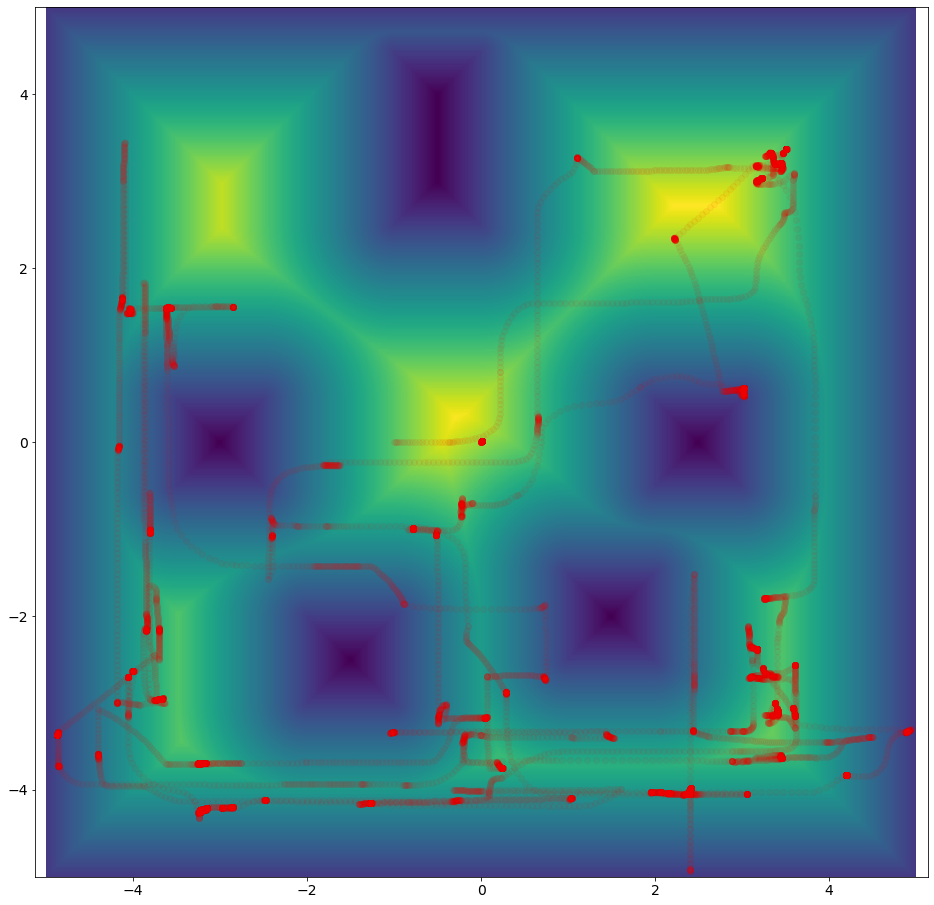

In [11]:
# show all location of the tail overlayed on the SDF
plt.figure(figsize=(16,16))
plt.imshow(np.flipud(sdf.T), extent=[-5,5,-5,5])
plt.scatter(tail[:,:,0], tail[:,:,1], c='r', alpha=0.05)
plt.axis("equal");

In [12]:
# iterate over the data and find the data points which are on the boundary of collision, and take their average
data_at_threshold = []
for state_traj, constraint_traj in zip(states, constraints):
    for t_idx in range(T - 1):
        current_constraint = constraint_traj[t_idx]
        next_constraint = constraint_traj[t_idx + 1]
        # xor operator
        if bool(current_constraint) ^ bool(next_constraint): 
            average_state = (state_traj[t_idx] + state_traj[t_idx + 1]) / 2
            data_at_threshold.append(average_state)
data_at_threshold = np.array(data_at_threshold)

In [53]:
threshold = 0.201
sdf_points_at_threshold = []
for row, col in np.ndindex(sdf.shape):
    d = sdf[row, col]
    if abs(d - threshold) < 0.005:
        point = tpoc.sdf_idx_to_point(row, col, res, origin)
        sdf_points_at_threshold.append(point)
sdf_points_at_threshold = np.array(sdf_points_at_threshold).squeeze()
np.random.shuffle(sdf_points_at_threshold)

In [54]:
print(sdf_points_at_threshold.shape)

(6624, 2)


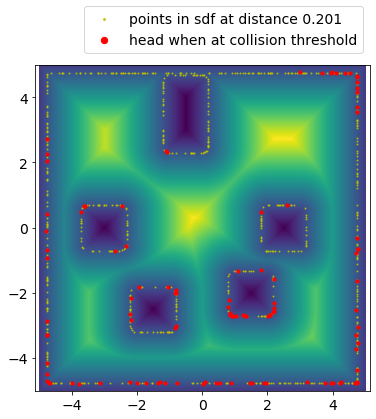

In [55]:
# show all location of the tail overlayed on the SDF
plt.figure(figsize=(6,6))
subsample = 10
plt.imshow(np.flipud(sdf.T), extent=[-5,5,-5,5])
plt.scatter(sdf_points_at_threshold[::subsample,0], sdf_points_at_threshold[::subsample,1], c='y', s=1, alpha=0.8, label='points in sdf at distance {}'.format(threshold))
plt.scatter(data_at_threshold[:,4], data_at_threshold[:,5], c='r', s=10, label='head when at collision threshold')
plt.legend(loc='upper right', bbox_to_anchor=(1.0,1.20))
plt.axis("equal");

# LM-ICP

We will solve the following optimization problem with LM


$$
R_j^*, j^* = \arg\min_{a,j} \sum_{i=1}^{N_d} \min_j||m_j - R_kd_i||^2_2
$$

Where we have a $N_d$ points (6D, rope configuration) $\{d_1, \dots, d_{N_d}\}$ and $N_m$ states $\{m_1, \dots, m_{N_m}\}$ (2D, at constraint boundary). We also have that $N_m>N_d$ The optimization variable $R_k$ is a matrix transforming a 6D point into 2D space.

In [56]:
from scipy.optimize import root
from scipy.spatial import cKDTree

In [81]:
kdtree = cKDTree(data=sdf_points_at_threshold)

def Rk(params):
    a1 = params[0]
    a2 = params[1]
    a3 = params[2]
    return np.array([
        [a1, 0],
        [0, a1],
        [a2, 0],
        [0, a2],
        [a3, 0],
        [0, a3],
    ])

def nn_correspondences(source, target):
    """
    source is a N_d by 2 matrix of points in R^2, which are the result of transforming data_at_threshold by R_k 
    target is a N_m by 2 matrix of points in R^2, which is sdf_points_at_threshold
    N_d < N_m
    the kdtree is build using the sdf points at threshold, of which there are more points.
    We will use the tree to find nearest points in the SDF to points from the rope data.
    """
    n_d = source.shape[0]
    n_m = target.shape[0]
    assert n_d < n_m, 'N_d {} must be < N_m {}'.format(n_d, n_m)
    distances, indeces = kdtree.query(source)
    return indeces
    
def func(params):
    print(params)
    R_k = Rk(params)
    transformed_data = data_at_threshold @ R_k
    correspondance_guess = nn_correspondences(transformed_data, sdf_points_at_threshold)
    corresponding_sdf_points = sdf_points_at_threshold[correspondance_guess]
    error = np.linalg.norm(corresponding_sdf_points - transformed_data, axis=1)
    return error

In [82]:
initial_a = [1, 0, 0]
initial_R_k = Rk(initial_a)
initial_transformed_data = data_at_threshold @ initial_R_k
initial_correspondance_guess = nn_correspondences(initial_transformed_data, sdf_points_at_threshold)
sol = root(func, initial_a, jac=None, method='lm')
if sol.success:
    print("Solution: ")
    print("R_k:")
    solution_R_k = Rk(sol.x)
    mean_error = np.mean(sol.fun)
#     final_errors.append(mean_error)
    print(solution_R_k) 
    print("mean error: {:0.3f} m".format(mean_error))
else:
    print(sol.status)
    print(sol.message)
    print(sol.nit)

[1 0 0]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[0.78 0.21 0.09]
[0.78 0.21 0.09]
[0.78 0.21 0.09]
[0.78 0.21 0.09]
[0.57 0.42 0.16]
[0.57 0.42 0.16]
[0.57 0.42 0.16]
[0.57 0.42 0.16]
[0.51 0.35 0.29]
[0.51 0.35 0.29]
[0.51 0.35 0.29]
[0.51 0.35 0.29]
[0.4  0.33 0.41]
[0.4  0.33 0.41]
[0.4  0.33 0.41]
[0.4  0.33 0.41]
[0.3  0.3  0.51]
[0.3  0.3  0.51]
[0.3  0.3  0.51]
[0.3  0.3  0.51]
[0.08 0.27 0.7 ]
[0.08 0.27 0.7 ]
[0.08 0.27 0.7 ]
[0.08 0.27 0.7 ]
[0.01 0.05 0.95]
[0.01 0.05 0.95]
[0.01 0.05 0.95]
[0.01 0.05 0.95]
[0.01 0.01 0.99]
[0.01 0.01 0.99]
[0.01 0.01 0.99]
[0.01 0.01 0.99]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1

In [59]:
failures = 0
exact_solutions = 0
success_threshold = 0.02
n_runs = 1000
iterations = np.ndarray(n_runs)
final_errors = np.ndarray(n_runs)
for i in range(n_runs):
    initial_a = np.random.randn(3)
    initial_R_k = Rk(initial_a)
    initial_transformed_data = data_at_threshold @ initial_R_k
    initial_correspondance_guess = nn_correspondences(initial_transformed_data, sdf_points_at_threshold)
    sol = root(func, initial_a, jac=None, method='lm')
    if sol.success:
        mean_error = np.mean(sol.fun)
        final_errors[i] = mean_error
        if np.linalg.norm(sol.x - [0, 0, 1.0]) < 0.01:
            exact_solutions += 1
        iterations[i] = sol.nfev
    else:
        failures += 1
        
n_success = np.count_nonzero(final_errors < success_threshold)

print("# Failures: {}".format(failures))
print("Exact Solutions: {}".format(exact_solutions / n_runs * 100))
print("mean number of optimization iterations: {}".format(np.mean(iterations)))
print("median number of optimization iterations: {}".format(np.median(iterations)))
print("runs with less than {}m error {:4.1f}%".format(success_threshold, n_success / n_runs * 100))

[[-2.46 -1.82]
 [-2.54 -2.06]] [[-2.18 -1.91]
 [-2.2  -2.06]]
[[-2.46 -1.82]
 [-2.54 -2.06]] [[-2.18 -1.91]
 [-2.2  -2.06]]
[[-2.46 -1.82]
 [-2.54 -2.06]] [[-2.18 -1.91]
 [-2.2  -2.06]]
[[-2.46 -1.82]
 [-2.54 -2.06]] [[-2.18 -1.91]
 [-2.2  -2.06]]
[[-2.46 -1.82]
 [-2.54 -2.06]] [[-2.18 -1.91]
 [-2.2  -2.06]]
[[-2.46 -1.82]
 [-2.54 -2.06]] [[-2.18 -1.91]
 [-2.2  -2.06]]
[[-2.39 -1.8 ]
 [-2.45 -2.04]] [[-2.18 -1.91]
 [-2.2  -2.03]]
[[-2.39 -1.8 ]
 [-2.45 -2.04]] [[-2.18 -1.91]
 [-2.2  -2.03]]
[[-2.39 -1.8 ]
 [-2.45 -2.04]] [[-2.18 -1.91]
 [-2.2  -2.03]]
[[-2.39 -1.8 ]
 [-2.45 -2.04]] [[-2.18 -1.91]
 [-2.2  -2.03]]
[[-2.36 -1.82]
 [-2.38 -2.06]] [[-2.18 -1.91]
 [-2.2  -2.06]]
[[-2.36 -1.82]
 [-2.38 -2.06]] [[-2.18 -1.91]
 [-2.2  -2.06]]
[[-2.36 -1.82]
 [-2.38 -2.06]] [[-2.18 -1.91]
 [-2.2  -2.06]]
[[-2.36 -1.82]
 [-2.38 -2.06]] [[-2.18 -1.91]
 [-2.2  -2.06]]
[[-2.38 -1.85]
 [-2.4  -2.09]] [[-2.18 -1.91]
 [-2.2  -2.09]]
[[-2.38 -1.85]
 [-2.4  -2.09]] [[-2.18 -1.91]
 [-2.2  -2.09]]
[[-2.38 

[[2.08 1.67]
 [2.06 1.88]] [[2.08 0.68]
 [2.06 0.68]]
[[2.08 1.67]
 [2.06 1.88]] [[2.08 0.68]
 [2.06 0.68]]
[[2.08 1.67]
 [2.07 1.88]] [[2.08 0.68]
 [2.06 0.68]]
[[2.08 1.67]
 [2.07 1.88]] [[2.08 0.68]
 [2.06 0.68]]
[[2.08 1.67]
 [2.07 1.88]] [[2.08 0.68]
 [2.06 0.68]]
[[2.08 1.67]
 [2.07 1.88]] [[2.08 0.68]
 [2.06 0.68]]
[[2.08 1.67]
 [2.06 1.88]] [[2.08 0.68]
 [2.06 0.68]]
[[2.08 1.67]
 [2.06 1.88]] [[2.08 0.68]
 [2.06 0.68]]
[[2.08 1.67]
 [2.06 1.88]] [[2.08 0.68]
 [2.06 0.68]]
[[2.08 1.67]
 [2.06 1.88]] [[2.08 0.68]
 [2.06 0.68]]
[[2.08 1.67]
 [2.07 1.88]] [[2.08 0.68]
 [2.06 0.68]]
[[2.08 1.67]
 [2.07 1.88]] [[2.08 0.68]
 [2.06 0.68]]
[[2.08 1.67]
 [2.07 1.88]] [[2.08 0.68]
 [2.06 0.68]]
[[2.08 1.67]
 [2.07 1.88]] [[2.08 0.68]
 [2.06 0.68]]
[[2.08 1.67]
 [2.07 1.88]] [[2.08 0.68]
 [2.06 0.68]]
[[2.08 1.67]
 [2.07 1.88]] [[2.08 0.68]
 [2.06 0.68]]
[[2.08 1.67]
 [2.07 1.88]] [[2.08 0.68]
 [2.06 0.68]]
[[2.08 1.67]
 [2.07 1.88]] [[2.08 0.68]
 [2.06 0.68]]
[[2.08 1.67]
 [2.07 1.88]] [

[[-1.92 -0.98]
 [-2.28 -1.11]] [[-2.36 -0.64]
 [-2.41 -0.68]]
[[-1.92 -0.98]
 [-2.28 -1.11]] [[-2.36 -0.64]
 [-2.41 -0.68]]
[[-1.92 -0.98]
 [-2.28 -1.11]] [[-2.36 -0.64]
 [-2.41 -0.68]]
[[-1.91 -0.97]
 [-2.28 -1.11]] [[-2.36 -0.64]
 [-2.41 -0.68]]
[[-1.91 -0.97]
 [-2.28 -1.11]] [[-2.36 -0.64]
 [-2.41 -0.68]]
[[-1.91 -0.97]
 [-2.28 -1.11]] [[-2.36 -0.64]
 [-2.41 -0.68]]
[[-1.91 -0.97]
 [-2.28 -1.11]] [[-2.36 -0.64]
 [-2.41 -0.68]]
[[-1.91 -0.97]
 [-2.28 -1.11]] [[-2.36 -0.64]
 [-2.41 -0.68]]
[[-1.91 -0.97]
 [-2.28 -1.11]] [[-2.36 -0.64]
 [-2.41 -0.68]]
[[-1.91 -0.97]
 [-2.28 -1.11]] [[-2.36 -0.64]
 [-2.41 -0.68]]
[[-1.91 -0.97]
 [-2.28 -1.11]] [[-2.36 -0.64]
 [-2.41 -0.68]]
[[-1.91 -0.97]
 [-2.28 -1.11]] [[-2.36 -0.64]
 [-2.41 -0.68]]
[[-1.91 -0.97]
 [-2.28 -1.11]] [[-2.36 -0.64]
 [-2.41 -0.68]]
[[-1.91 -0.97]
 [-2.28 -1.11]] [[-2.36 -0.64]
 [-2.41 -0.68]]
[[-1.91 -0.97]
 [-2.28 -1.11]] [[-2.36 -0.64]
 [-2.41 -0.68]]
[[-1.91 -0.97]
 [-2.28 -1.11]] [[-2.36 -0.64]
 [-2.41 -0.68]]
[[-1.91 

[[-4.71 -3.74]
 [-4.67 -4.21]] [[-4.76 -3.73]
 [-4.76 -4.2 ]]
[[-4.71 -3.74]
 [-4.67 -4.21]] [[-4.76 -3.73]
 [-4.76 -4.2 ]]
[[-4.71 -3.74]
 [-4.67 -4.21]] [[-4.76 -3.73]
 [-4.76 -4.2 ]]
[[-4.71 -3.74]
 [-4.67 -4.21]] [[-4.76 -3.73]
 [-4.76 -4.2 ]]
[[-4.71 -3.74]
 [-4.67 -4.21]] [[-4.76 -3.73]
 [-4.76 -4.2 ]]
[[-4.71 -3.74]
 [-4.67 -4.21]] [[-4.76 -3.73]
 [-4.76 -4.2 ]]
[[-4.71 -3.74]
 [-4.67 -4.21]] [[-4.76 -3.73]
 [-4.76 -4.2 ]]
[[-4.71 -3.74]
 [-4.67 -4.21]] [[-4.76 -3.73]
 [-4.76 -4.2 ]]
[[-4.71 -3.74]
 [-4.67 -4.21]] [[-4.76 -3.73]
 [-4.76 -4.2 ]]
[[-4.71 -3.74]
 [-4.67 -4.21]] [[-4.76 -3.73]
 [-4.76 -4.2 ]]
[[-4.71 -3.74]
 [-4.67 -4.21]] [[-4.76 -3.73]
 [-4.76 -4.2 ]]
[[-4.71 -3.74]
 [-4.67 -4.21]] [[-4.76 -3.73]
 [-4.76 -4.2 ]]
[[-4.71 -3.74]
 [-4.67 -4.21]] [[-4.76 -3.73]
 [-4.76 -4.2 ]]
[[-4.71 -3.74]
 [-4.67 -4.21]] [[-4.76 -3.73]
 [-4.76 -4.2 ]]
[[-4.71 -3.74]
 [-4.67 -4.21]] [[-4.76 -3.73]
 [-4.76 -4.2 ]]
[[-4.71 -3.74]
 [-4.67 -4.21]] [[-4.76 -3.73]
 [-4.76 -4.2 ]]
[[-4.71 

[[-4.28 -3.  ]
 [-4.51 -3.38]] [[-4.76 -2.99]
 [-4.76 -3.38]]
[[-4.28 -3.  ]
 [-4.51 -3.38]] [[-4.76 -2.99]
 [-4.76 -3.38]]
[[-4.28 -3.  ]
 [-4.51 -3.38]] [[-4.76 -2.99]
 [-4.76 -3.38]]
[[-4.28 -3.  ]
 [-4.51 -3.38]] [[-4.76 -2.99]
 [-4.76 -3.38]]
[[-4.34 -3.06]
 [-4.55 -3.45]] [[-4.76 -3.05]
 [-4.76 -3.44]]
[[-4.34 -3.06]
 [-4.55 -3.45]] [[-4.76 -3.05]
 [-4.76 -3.44]]
[[-4.34 -3.06]
 [-4.55 -3.45]] [[-4.76 -3.05]
 [-4.76 -3.44]]
[[-4.34 -3.06]
 [-4.55 -3.45]] [[-4.76 -3.05]
 [-4.76 -3.44]]
[[-4.43 -3.16]
 [-4.62 -3.56]] [[-4.76 -3.15]
 [-4.76 -3.55]]
[[-4.43 -3.16]
 [-4.62 -3.56]] [[-4.76 -3.15]
 [-4.76 -3.55]]
[[-4.43 -3.16]
 [-4.62 -3.56]] [[-4.76 -3.15]
 [-4.76 -3.55]]
[[-4.43 -3.16]
 [-4.62 -3.56]] [[-4.76 -3.15]
 [-4.76 -3.55]]
[[-4.47 -3.2 ]
 [-4.65 -3.61]] [[-4.76 -3.2 ]
 [-4.76 -3.6 ]]
[[-4.47 -3.2 ]
 [-4.65 -3.61]] [[-4.76 -3.2 ]
 [-4.76 -3.6 ]]
[[-4.47 -3.2 ]
 [-4.65 -3.61]] [[-4.76 -3.2 ]
 [-4.76 -3.6 ]]
[[-4.47 -3.2 ]
 [-4.65 -3.61]] [[-4.76 -3.2 ]
 [-4.76 -3.6 ]]
[[-4.54 

[[-4.6  -3.36]
 [-4.74 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.74 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.74 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.74 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.74 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.74 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.74 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.74 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.74 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.74 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.74 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-5.18 -4.13]
 [-5.12 -4.66]] [[-4.76 -4.13]
 [-4.76 -4.65]]
[[-5.18 -4.13]
 [-5.12 -4.66]] [[-4.76 -4.13]
 [-4.76 -4.65]]
[[-5.18 -4.13]
 [-5.12 -4.66]] [[-4.76 -4.13]
 [-4.76 -4.65]]
[[-5.18 -4.13]
 [-5.12 -4.66]] [[-4.76 -4.13]
 [-4.76 -4.65]]
[[-5.18 -4.13]
 [-5.12 -4.66]] [[-4.76 -4.13]
 [-4.76 -4.65]]
[[-5.18 

[[-4.73 -3.73]
 [-4.69 -4.2 ]] [[-4.76 -3.73]
 [-4.76 -4.2 ]]
[[-4.73 -3.73]
 [-4.69 -4.2 ]] [[-4.76 -3.73]
 [-4.76 -4.2 ]]
[[-4.73 -3.73]
 [-4.69 -4.2 ]] [[-4.76 -3.73]
 [-4.76 -4.2 ]]
[[-4.73 -3.73]
 [-4.69 -4.2 ]] [[-4.76 -3.73]
 [-4.76 -4.2 ]]
[[-4.73 -3.73]
 [-4.69 -4.2 ]] [[-4.76 -3.73]
 [-4.76 -4.2 ]]
[[-4.73 -3.73]
 [-4.69 -4.2 ]] [[-4.76 -3.73]
 [-4.76 -4.2 ]]
[[-4.73 -3.73]
 [-4.69 -4.2 ]] [[-4.76 -3.73]
 [-4.76 -4.2 ]]
[[-4.73 -3.73]
 [-4.69 -4.2 ]] [[-4.76 -3.73]
 [-4.76 -4.2 ]]
[[-4.73 -3.73]
 [-4.69 -4.2 ]] [[-4.76 -3.73]
 [-4.76 -4.2 ]]
[[-4.73 -3.73]
 [-4.69 -4.2 ]] [[-4.76 -3.73]
 [-4.76 -4.2 ]]
[[-4.73 -3.73]
 [-4.69 -4.2 ]] [[-4.76 -3.73]
 [-4.76 -4.2 ]]
[[-4.73 -3.73]
 [-4.69 -4.2 ]] [[-4.76 -3.73]
 [-4.76 -4.2 ]]
[[-4.73 -3.73]
 [-4.69 -4.2 ]] [[-4.76 -3.73]
 [-4.76 -4.2 ]]
[[-4.73 -3.73]
 [-4.69 -4.2 ]] [[-4.76 -3.73]
 [-4.76 -4.2 ]]
[[-4.73 -3.73]
 [-4.69 -4.2 ]] [[-4.76 -3.73]
 [-4.76 -4.2 ]]
[[-4.73 -3.73]
 [-4.69 -4.2 ]] [[-4.76 -3.73]
 [-4.76 -4.2 ]]
[[-4.73 

[[4.32 3.04]
 [4.54 3.43]] [[4.74 3.03]
 [4.74 3.42]]
[[4.34 3.06]
 [4.55 3.45]] [[4.74 3.06]
 [4.74 3.45]]
[[4.34 3.06]
 [4.55 3.45]] [[4.74 3.06]
 [4.74 3.45]]
[[4.34 3.06]
 [4.55 3.45]] [[4.74 3.06]
 [4.74 3.45]]
[[4.34 3.06]
 [4.55 3.45]] [[4.74 3.06]
 [4.74 3.45]]
[[4.35 3.08]
 [4.55 3.48]] [[4.74 3.08]
 [4.74 3.47]]
[[4.35 3.08]
 [4.55 3.48]] [[4.74 3.08]
 [4.74 3.47]]
[[4.35 3.08]
 [4.55 3.48]] [[4.74 3.08]
 [4.74 3.47]]
[[4.35 3.08]
 [4.55 3.48]] [[4.74 3.08]
 [4.74 3.47]]
[[4.34 3.08]
 [4.55 3.47]] [[4.74 3.07]
 [4.74 3.47]]
[[4.34 3.08]
 [4.55 3.47]] [[4.74 3.07]
 [4.74 3.47]]
[[4.34 3.08]
 [4.55 3.47]] [[4.74 3.07]
 [4.74 3.47]]
[[4.34 3.08]
 [4.55 3.47]] [[4.74 3.07]
 [4.74 3.47]]
[[4.34 3.08]
 [4.55 3.47]] [[4.74 3.07]
 [4.74 3.47]]
[[4.34 3.08]
 [4.55 3.47]] [[4.74 3.07]
 [4.74 3.47]]
[[4.34 3.08]
 [4.55 3.47]] [[4.74 3.07]
 [4.74 3.47]]
[[4.34 3.08]
 [4.55 3.47]] [[4.74 3.07]
 [4.74 3.47]]
[[4.34 3.08]
 [4.55 3.47]] [[4.74 3.07]
 [4.74 3.47]]
[[4.34 3.08]
 [4.55 3.47]] [

[[-4.69 -3.53]
 [-4.76 -3.98]] [[-4.76 -3.53]
 [-4.76 -3.97]]
[[-4.69 -3.53]
 [-4.76 -3.98]] [[-4.76 -3.53]
 [-4.76 -3.97]]
[[-4.69 -3.53]
 [-4.76 -3.98]] [[-4.76 -3.53]
 [-4.76 -3.97]]
[[-4.62 -3.46]
 [-4.71 -3.9 ]] [[-4.76 -3.45]
 [-4.76 -3.89]]
[[-4.62 -3.46]
 [-4.71 -3.9 ]] [[-4.76 -3.45]
 [-4.76 -3.89]]
[[-4.62 -3.46]
 [-4.71 -3.9 ]] [[-4.76 -3.45]
 [-4.76 -3.89]]
[[-4.62 -3.46]
 [-4.71 -3.9 ]] [[-4.76 -3.45]
 [-4.76 -3.89]]
[[-4.6  -3.43]
 [-4.7  -3.86]] [[-4.76 -3.42]
 [-4.76 -3.86]]
[[-4.6  -3.43]
 [-4.7  -3.86]] [[-4.76 -3.42]
 [-4.76 -3.86]]
[[-4.6  -3.43]
 [-4.7  -3.86]] [[-4.76 -3.42]
 [-4.76 -3.86]]
[[-4.6  -3.43]
 [-4.7  -3.86]] [[-4.76 -3.42]
 [-4.76 -3.86]]
[[-4.59 -3.4 ]
 [-4.7  -3.83]] [[-4.76 -3.39]
 [-4.76 -3.82]]
[[-4.59 -3.4 ]
 [-4.7  -3.83]] [[-4.76 -3.39]
 [-4.76 -3.82]]
[[-4.59 -3.4 ]
 [-4.7  -3.83]] [[-4.76 -3.39]
 [-4.76 -3.82]]
[[-4.59 -3.4 ]
 [-4.7  -3.83]] [[-4.76 -3.39]
 [-4.76 -3.82]]
[[-4.56 -3.35]
 [-4.69 -3.77]] [[-4.76 -3.34]
 [-4.76 -3.77]]
[[-4.56 

[[-1.68 -1.  ]
 [-1.87 -1.13]] [[-2.33 -0.6 ]
 [-2.36 -0.64]]
[[-1.68 -1.  ]
 [-1.87 -1.13]] [[-2.33 -0.6 ]
 [-2.36 -0.64]]
[[-1.73 -1.01]
 [-1.93 -1.14]] [[-2.33 -0.6 ]
 [-2.37 -0.65]]
[[-1.73 -1.01]
 [-1.93 -1.14]] [[-2.33 -0.6 ]
 [-2.37 -0.65]]
[[-1.73 -1.01]
 [-1.93 -1.14]] [[-2.33 -0.6 ]
 [-2.37 -0.65]]
[[-1.73 -1.01]
 [-1.93 -1.14]] [[-2.33 -0.6 ]
 [-2.37 -0.65]]
[[-1.78 -1.04]
 [-1.99 -1.17]] [[-2.33 -0.6 ]
 [-2.37 -0.65]]
[[-1.78 -1.04]
 [-1.99 -1.17]] [[-2.33 -0.6 ]
 [-2.37 -0.65]]
[[-1.78 -1.04]
 [-1.99 -1.17]] [[-2.33 -0.6 ]
 [-2.37 -0.65]]
[[-1.78 -1.04]
 [-1.99 -1.17]] [[-2.33 -0.6 ]
 [-2.37 -0.65]]
[[-1.78 -1.04]
 [-1.99 -1.17]] [[-2.33 -0.6 ]
 [-2.37 -0.65]]
[[-1.78 -1.04]
 [-1.99 -1.17]] [[-2.33 -0.6 ]
 [-2.37 -0.65]]
[[-1.78 -1.04]
 [-1.99 -1.17]] [[-2.33 -0.6 ]
 [-2.37 -0.65]]
[[-1.78 -1.04]
 [-1.99 -1.17]] [[-2.33 -0.6 ]
 [-2.37 -0.65]]
[[-1.81 -1.04]
 [-2.03 -1.17]] [[-2.36 -0.64]
 [-2.41 -0.68]]
[[-1.81 -1.04]
 [-2.03 -1.17]] [[-2.36 -0.64]
 [-2.41 -0.68]]
[[-1.81 

[[1.38 1.45]
 [1.16 1.64]] [[1.89 0.66]
 [1.89 0.66]]
[[1.38 1.45]
 [1.16 1.64]] [[1.89 0.66]
 [1.89 0.66]]
[[1.38 1.45]
 [1.16 1.63]] [[1.89 0.66]
 [1.89 0.66]]
[[1.38 1.45]
 [1.16 1.63]] [[1.89 0.66]
 [1.89 0.66]]
[[1.38 1.45]
 [1.16 1.63]] [[1.89 0.66]
 [1.89 0.66]]
[[1.38 1.45]
 [1.16 1.63]] [[1.89 0.66]
 [1.89 0.66]]
[[1.38 1.44]
 [1.16 1.63]] [[1.89 0.66]
 [1.89 0.66]]
[[1.38 1.44]
 [1.16 1.63]] [[1.89 0.66]
 [1.89 0.66]]
[[1.38 1.44]
 [1.16 1.63]] [[1.89 0.66]
 [1.89 0.66]]
[[1.38 1.44]
 [1.16 1.63]] [[1.89 0.66]
 [1.89 0.66]]
[[1.38 1.45]
 [1.16 1.63]] [[1.89 0.66]
 [1.89 0.66]]
[[1.38 1.45]
 [1.16 1.63]] [[1.89 0.66]
 [1.89 0.66]]
[[1.38 1.45]
 [1.16 1.63]] [[1.89 0.66]
 [1.89 0.66]]
[[1.38 1.45]
 [1.16 1.63]] [[1.89 0.66]
 [1.89 0.66]]
[[1.38 1.45]
 [1.16 1.63]] [[1.89 0.66]
 [1.89 0.66]]
[[1.38 1.44]
 [1.16 1.63]] [[1.89 0.66]
 [1.89 0.66]]
[[1.38 1.44]
 [1.16 1.63]] [[1.89 0.66]
 [1.89 0.66]]
[[1.38 1.44]
 [1.16 1.63]] [[1.89 0.66]
 [1.89 0.66]]
[[1.38 1.44]
 [1.16 1.63]] [

[[1.54 1.36]
 [1.38 1.52]] [[1.89 0.66]
 [1.89 0.66]]
[[1.54 1.36]
 [1.38 1.52]] [[1.89 0.66]
 [1.89 0.66]]
[[1.54 1.36]
 [1.38 1.52]] [[1.89 0.66]
 [1.89 0.66]]
[[1.54 1.36]
 [1.38 1.52]] [[1.89 0.66]
 [1.89 0.66]]
[[1.54 1.36]
 [1.38 1.52]] [[1.89 0.66]
 [1.89 0.66]]
[[1.54 1.36]
 [1.38 1.52]] [[1.89 0.66]
 [1.89 0.66]]
[[1.54 1.36]
 [1.38 1.52]] [[1.89 0.66]
 [1.89 0.66]]
[[-5.36 -4.02]
 [-5.48 -4.53]] [[-4.76 -4.01]
 [-4.76 -4.53]]
[[-5.36 -4.02]
 [-5.48 -4.53]] [[-4.76 -4.01]
 [-4.76 -4.53]]
[[-5.36 -4.02]
 [-5.48 -4.53]] [[-4.76 -4.01]
 [-4.76 -4.53]]
[[-5.36 -4.02]
 [-5.48 -4.53]] [[-4.76 -4.01]
 [-4.76 -4.53]]
[[-5.36 -4.02]
 [-5.48 -4.53]] [[-4.76 -4.01]
 [-4.76 -4.53]]
[[-5.36 -4.02]
 [-5.48 -4.53]] [[-4.76 -4.01]
 [-4.76 -4.53]]
[[-4.64 -3.41]
 [-4.78 -3.85]] [[-4.76 -3.41]
 [-4.76 -3.84]]
[[-4.64 -3.41]
 [-4.78 -3.85]] [[-4.76 -3.41]
 [-4.76 -3.84]]
[[-4.64 -3.41]
 [-4.78 -3.85]] [[-4.76 -3.41]
 [-4.76 -3.84]]
[[-4.64 -3.41]
 [-4.78 -3.85]] [[-4.76 -3.41]
 [-4.76 -3.84]]
[[

[[-4.57 -3.31]
 [-4.72 -3.73]] [[-4.76 -3.31]
 [-4.76 -3.72]]
[[-4.59 -3.34]
 [-4.73 -3.77]] [[-4.76 -3.34]
 [-4.76 -3.76]]
[[-4.59 -3.34]
 [-4.73 -3.77]] [[-4.76 -3.34]
 [-4.76 -3.76]]
[[-4.59 -3.34]
 [-4.73 -3.77]] [[-4.76 -3.34]
 [-4.76 -3.76]]
[[-4.59 -3.34]
 [-4.73 -3.77]] [[-4.76 -3.34]
 [-4.76 -3.76]]
[[-4.6  -3.35]
 [-4.74 -3.78]] [[-4.76 -3.35]
 [-4.76 -3.77]]
[[-4.6  -3.35]
 [-4.74 -3.78]] [[-4.76 -3.35]
 [-4.76 -3.77]]
[[-4.6  -3.35]
 [-4.74 -3.78]] [[-4.76 -3.35]
 [-4.76 -3.77]]
[[-4.6  -3.35]
 [-4.74 -3.78]] [[-4.76 -3.35]
 [-4.76 -3.77]]
[[-4.6  -3.36]
 [-4.74 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.74 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.74 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.74 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.73 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.73 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.73 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  

[[-7.15 -5.5 ]
 [-7.21 -6.2 ]] [[-4.76 -4.76]
 [-4.76 -4.76]]
[[-7.15 -5.5 ]
 [-7.21 -6.2 ]] [[-4.76 -4.76]
 [-4.76 -4.76]]
[[-4.76 -3.51]
 [-4.9  -3.96]] [[-4.76 -3.51]
 [-4.76 -3.96]]
[[-4.76 -3.51]
 [-4.9  -3.96]] [[-4.76 -3.51]
 [-4.76 -3.96]]
[[-4.76 -3.51]
 [-4.9  -3.96]] [[-4.76 -3.51]
 [-4.76 -3.96]]
[[-4.76 -3.51]
 [-4.9  -3.96]] [[-4.76 -3.51]
 [-4.76 -3.96]]
[[-4.58 -3.38]
 [-4.72 -3.81]] [[-4.76 -3.37]
 [-4.76 -3.81]]
[[-4.58 -3.38]
 [-4.72 -3.81]] [[-4.76 -3.37]
 [-4.76 -3.81]]
[[-4.58 -3.38]
 [-4.72 -3.81]] [[-4.76 -3.37]
 [-4.76 -3.81]]
[[-4.58 -3.38]
 [-4.72 -3.81]] [[-4.76 -3.37]
 [-4.76 -3.81]]
[[-4.57 -3.38]
 [-4.7  -3.81]] [[-4.76 -3.37]
 [-4.76 -3.8 ]]
[[-4.57 -3.38]
 [-4.7  -3.81]] [[-4.76 -3.37]
 [-4.76 -3.8 ]]
[[-4.57 -3.38]
 [-4.7  -3.81]] [[-4.76 -3.37]
 [-4.76 -3.8 ]]
[[-4.57 -3.38]
 [-4.7  -3.81]] [[-4.76 -3.37]
 [-4.76 -3.8 ]]
[[-4.58 -3.39]
 [-4.7  -3.82]] [[-4.76 -3.38]
 [-4.76 -3.82]]
[[-4.58 -3.39]
 [-4.7  -3.82]] [[-4.76 -3.38]
 [-4.76 -3.82]]
[[-4.58 

[[-4.6  -3.38]
 [-4.74 -3.81]] [[-4.76 -3.38]
 [-4.76 -3.81]]
[[-4.6  -3.38]
 [-4.74 -3.81]] [[-4.76 -3.38]
 [-4.76 -3.81]]
[[-4.52 -3.33]
 [-4.66 -3.76]] [[-4.76 -3.32]
 [-4.76 -3.75]]
[[-4.52 -3.33]
 [-4.66 -3.76]] [[-4.76 -3.32]
 [-4.76 -3.75]]
[[-4.52 -3.33]
 [-4.66 -3.76]] [[-4.76 -3.32]
 [-4.76 -3.75]]
[[-4.52 -3.33]
 [-4.66 -3.76]] [[-4.76 -3.32]
 [-4.76 -3.75]]
[[-4.54 -3.35]
 [-4.67 -3.78]] [[-4.76 -3.35]
 [-4.76 -3.78]]
[[-4.54 -3.35]
 [-4.67 -3.78]] [[-4.76 -3.35]
 [-4.76 -3.78]]
[[-4.54 -3.35]
 [-4.67 -3.78]] [[-4.76 -3.35]
 [-4.76 -3.78]]
[[-4.54 -3.35]
 [-4.67 -3.78]] [[-4.76 -3.35]
 [-4.76 -3.78]]
[[-4.58 -3.39]
 [-4.7  -3.82]] [[-4.76 -3.38]
 [-4.76 -3.81]]
[[-4.58 -3.39]
 [-4.7  -3.82]] [[-4.76 -3.38]
 [-4.76 -3.81]]
[[-4.58 -3.39]
 [-4.7  -3.82]] [[-4.76 -3.38]
 [-4.76 -3.81]]
[[-4.58 -3.39]
 [-4.7  -3.82]] [[-4.76 -3.38]
 [-4.76 -3.81]]
[[-4.58 -3.39]
 [-4.7  -3.82]] [[-4.76 -3.38]
 [-4.76 -3.82]]
[[-4.58 -3.39]
 [-4.7  -3.82]] [[-4.76 -3.38]
 [-4.76 -3.82]]
[[-4.58 

[[-4.81 -4.17]
 [-4.51 -4.69]] [[-4.76 -4.16]
 [-4.5  -4.76]]
[[-4.81 -4.17]
 [-4.51 -4.69]] [[-4.76 -4.16]
 [-4.5  -4.76]]
[[-4.81 -4.17]
 [-4.51 -4.69]] [[-4.76 -4.16]
 [-4.5  -4.76]]
[[-4.78 -4.16]
 [-4.48 -4.69]] [[-4.76 -4.16]
 [-4.48 -4.76]]
[[-4.78 -4.16]
 [-4.48 -4.69]] [[-4.76 -4.16]
 [-4.48 -4.76]]
[[-4.78 -4.16]
 [-4.48 -4.69]] [[-4.76 -4.16]
 [-4.48 -4.76]]
[[-4.78 -4.16]
 [-4.48 -4.69]] [[-4.76 -4.16]
 [-4.48 -4.76]]
[[-4.79 -4.17]
 [-4.48 -4.69]] [[-4.76 -4.16]
 [-4.48 -4.76]]
[[-4.79 -4.17]
 [-4.48 -4.69]] [[-4.76 -4.16]
 [-4.48 -4.76]]
[[-4.79 -4.17]
 [-4.48 -4.69]] [[-4.76 -4.16]
 [-4.48 -4.76]]
[[-4.79 -4.17]
 [-4.48 -4.69]] [[-4.76 -4.16]
 [-4.48 -4.76]]
[[-4.79 -4.17]
 [-4.48 -4.69]] [[-4.76 -4.16]
 [-4.48 -4.76]]
[[-4.79 -4.17]
 [-4.48 -4.69]] [[-4.76 -4.16]
 [-4.48 -4.76]]
[[-4.79 -4.17]
 [-4.48 -4.69]] [[-4.76 -4.16]
 [-4.48 -4.76]]
[[-4.79 -4.17]
 [-4.48 -4.69]] [[-4.76 -4.16]
 [-4.48 -4.76]]
[[-4.79 -4.17]
 [-4.48 -4.69]] [[-4.76 -4.16]
 [-4.48 -4.76]]
[[-4.79 

[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [

[[9.21 6.9 ]
 [9.4  7.78]] [[4.74 4.74]
 [4.74 4.74]]
[[4.87 3.56]
 [5.04 4.02]] [[4.74 3.55]
 [4.74 4.01]]
[[4.87 3.56]
 [5.04 4.02]] [[4.74 3.55]
 [4.74 4.01]]
[[4.87 3.56]
 [5.04 4.02]] [[4.74 3.55]
 [4.74 4.01]]
[[4.87 3.56]
 [5.04 4.02]] [[4.74 3.55]
 [4.74 4.01]]
[[4.51 3.26]
 [4.67 3.68]] [[4.74 3.26]
 [4.74 3.67]]
[[4.51 3.26]
 [4.67 3.68]] [[4.74 3.26]
 [4.74 3.67]]
[[4.51 3.26]
 [4.67 3.68]] [[4.74 3.26]
 [4.74 3.67]]
[[4.51 3.26]
 [4.67 3.68]] [[4.74 3.26]
 [4.74 3.67]]
[[4.46 3.22]
 [4.62 3.64]] [[4.74 3.22]
 [4.74 3.63]]
[[4.46 3.22]
 [4.62 3.64]] [[4.74 3.22]
 [4.74 3.63]]
[[4.46 3.22]
 [4.62 3.64]] [[4.74 3.22]
 [4.74 3.63]]
[[4.46 3.22]
 [4.62 3.64]] [[4.74 3.22]
 [4.74 3.63]]
[[4.46 3.23]
 [4.63 3.64]] [[4.74 3.22]
 [4.74 3.63]]
[[4.46 3.23]
 [4.63 3.64]] [[4.74 3.22]
 [4.74 3.63]]
[[4.46 3.23]
 [4.63 3.64]] [[4.74 3.22]
 [4.74 3.63]]
[[4.46 3.23]
 [4.63 3.64]] [[4.74 3.22]
 [4.74 3.63]]
[[4.46 3.23]
 [4.63 3.64]] [[4.74 3.22]
 [4.74 3.63]]
[[4.46 3.23]
 [4.63 3.64]] [

[[2.13 1.63]
 [2.15 1.84]] [[2.13 0.68]
 [2.15 0.68]]
[[2.13 1.63]
 [2.15 1.83]] [[2.13 0.68]
 [2.15 0.68]]
[[2.13 1.63]
 [2.15 1.83]] [[2.13 0.68]
 [2.15 0.68]]
[[2.13 1.63]
 [2.15 1.83]] [[2.13 0.68]
 [2.15 0.68]]
[[2.13 1.63]
 [2.15 1.83]] [[2.13 0.68]
 [2.15 0.68]]
[[2.13 1.63]
 [2.15 1.83]] [[2.13 0.68]
 [2.15 0.68]]
[[2.13 1.63]
 [2.15 1.84]] [[2.13 0.68]
 [2.15 0.68]]
[[2.13 1.63]
 [2.15 1.84]] [[2.13 0.68]
 [2.15 0.68]]
[[2.13 1.63]
 [2.15 1.84]] [[2.13 0.68]
 [2.15 0.68]]
[[2.13 1.63]
 [2.15 1.84]] [[2.13 0.68]
 [2.15 0.68]]
[[2.13 1.63]
 [2.15 1.83]] [[2.13 0.68]
 [2.15 0.68]]
[[2.13 1.63]
 [2.15 1.83]] [[2.13 0.68]
 [2.15 0.68]]
[[2.13 1.63]
 [2.15 1.83]] [[2.13 0.68]
 [2.15 0.68]]
[[2.13 1.63]
 [2.15 1.83]] [[2.13 0.68]
 [2.15 0.68]]
[[2.13 1.63]
 [2.15 1.83]] [[2.13 0.68]
 [2.15 0.68]]
[[2.13 1.63]
 [2.15 1.84]] [[2.13 0.68]
 [2.15 0.68]]
[[2.13 1.63]
 [2.15 1.84]] [[2.13 0.68]
 [2.15 0.68]]
[[2.13 1.63]
 [2.15 1.84]] [[2.13 0.68]
 [2.15 0.68]]
[[2.13 1.63]
 [2.15 1.84]] [

[[-4.28 -3.01]
 [-4.5  -3.39]] [[-4.76 -3.  ]
 [-4.76 -3.38]]
[[-4.28 -3.01]
 [-4.5  -3.39]] [[-4.76 -3.  ]
 [-4.76 -3.38]]
[[-4.28 -3.01]
 [-4.5  -3.39]] [[-4.76 -3.  ]
 [-4.76 -3.38]]
[[-4.38 -3.11]
 [-4.57 -3.5 ]] [[-4.76 -3.1 ]
 [-4.76 -3.5 ]]
[[-4.38 -3.11]
 [-4.57 -3.5 ]] [[-4.76 -3.1 ]
 [-4.76 -3.5 ]]
[[-4.38 -3.11]
 [-4.57 -3.5 ]] [[-4.76 -3.1 ]
 [-4.76 -3.5 ]]
[[-4.38 -3.11]
 [-4.57 -3.5 ]] [[-4.76 -3.1 ]
 [-4.76 -3.5 ]]
[[-4.46 -3.19]
 [-4.64 -3.6 ]] [[-4.76 -3.19]
 [-4.76 -3.59]]
[[-4.46 -3.19]
 [-4.64 -3.6 ]] [[-4.76 -3.19]
 [-4.76 -3.59]]
[[-4.46 -3.19]
 [-4.64 -3.6 ]] [[-4.76 -3.19]
 [-4.76 -3.59]]
[[-4.46 -3.19]
 [-4.64 -3.6 ]] [[-4.76 -3.19]
 [-4.76 -3.59]]
[[-4.56 -3.3 ]
 [-4.71 -3.72]] [[-4.76 -3.3 ]
 [-4.76 -3.72]]
[[-4.56 -3.3 ]
 [-4.71 -3.72]] [[-4.76 -3.3 ]
 [-4.76 -3.72]]
[[-4.56 -3.3 ]
 [-4.71 -3.72]] [[-4.76 -3.3 ]
 [-4.76 -3.72]]
[[-4.56 -3.3 ]
 [-4.71 -3.72]] [[-4.76 -3.3 ]
 [-4.76 -3.72]]
[[-4.59 -3.34]
 [-4.73 -3.77]] [[-4.76 -3.34]
 [-4.76 -3.76]]
[[-4.59 

[[-4.59 -3.34]
 [-4.73 -3.77]] [[-4.76 -3.34]
 [-4.76 -3.76]]
[[-4.59 -3.34]
 [-4.73 -3.77]] [[-4.76 -3.34]
 [-4.76 -3.76]]
[[-4.59 -3.34]
 [-4.73 -3.77]] [[-4.76 -3.34]
 [-4.76 -3.76]]
[[-4.59 -3.34]
 [-4.73 -3.77]] [[-4.76 -3.34]
 [-4.76 -3.76]]
[[-4.59 -3.34]
 [-4.73 -3.77]] [[-4.76 -3.34]
 [-4.76 -3.76]]
[[-4.59 -3.34]
 [-4.73 -3.77]] [[-4.76 -3.34]
 [-4.76 -3.76]]
[[-4.59 -3.34]
 [-4.73 -3.77]] [[-4.76 -3.34]
 [-4.76 -3.76]]
[[-4.59 -3.34]
 [-4.73 -3.77]] [[-4.76 -3.34]
 [-4.76 -3.76]]
[[-4.59 -3.34]
 [-4.73 -3.77]] [[-4.76 -3.34]
 [-4.76 -3.76]]
[[-4.59 -3.34]
 [-4.73 -3.77]] [[-4.76 -3.34]
 [-4.76 -3.76]]
[[-4.59 -3.34]
 [-4.73 -3.77]] [[-4.76 -3.34]
 [-4.76 -3.76]]
[[-4.59 -3.34]
 [-4.73 -3.77]] [[-4.76 -3.34]
 [-4.76 -3.76]]
[[-4.59 -3.34]
 [-4.73 -3.77]] [[-4.76 -3.34]
 [-4.76 -3.76]]
[[-4.59 -3.34]
 [-4.73 -3.77]] [[-4.76 -3.34]
 [-4.76 -3.76]]
[[-4.59 -3.34]
 [-4.73 -3.77]] [[-4.76 -3.34]
 [-4.76 -3.76]]
[[-4.59 -3.34]
 [-4.73 -3.77]] [[-4.76 -3.34]
 [-4.76 -3.76]]
[[-4.59 

[[1.2  0.56]
 [1.51 0.64]] [[1.79 0.52]
 [1.8  0.55]]
[[1.2  0.56]
 [1.51 0.64]] [[1.79 0.52]
 [1.8  0.55]]
[[1.2  0.56]
 [1.51 0.64]] [[1.79 0.52]
 [1.8  0.55]]
[[1.2  0.56]
 [1.51 0.64]] [[1.79 0.52]
 [1.8  0.55]]
[[1.2  0.56]
 [1.51 0.64]] [[1.79 0.52]
 [1.8  0.55]]
[[1.2  0.56]
 [1.51 0.64]] [[1.79 0.52]
 [1.8  0.55]]
[[1.2  0.56]
 [1.51 0.64]] [[1.79 0.52]
 [1.8  0.55]]
[[1.2  0.56]
 [1.51 0.64]] [[1.79 0.52]
 [1.8  0.55]]
[[1.2  0.56]
 [1.51 0.64]] [[1.79 0.52]
 [1.8  0.55]]
[[1.2  0.56]
 [1.51 0.64]] [[1.79 0.52]
 [1.8  0.55]]
[[1.2  0.56]
 [1.51 0.64]] [[1.79 0.52]
 [1.8  0.55]]
[[1.2  0.56]
 [1.51 0.64]] [[1.79 0.52]
 [1.8  0.55]]
[[1.2  0.56]
 [1.51 0.64]] [[1.79 0.52]
 [1.8  0.55]]
[[1.2  0.56]
 [1.51 0.64]] [[1.79 0.52]
 [1.8  0.55]]
[[1.2  0.56]
 [1.51 0.64]] [[1.79 0.52]
 [1.8  0.55]]
[[1.2  0.56]
 [1.51 0.64]] [[1.79 0.52]
 [1.8  0.55]]
[[1.2  0.56]
 [1.51 0.64]] [[1.79 0.52]
 [1.8  0.55]]
[[1.2  0.56]
 [1.51 0.64]] [[1.79 0.52]
 [1.8  0.55]]
[[1.2  0.56]
 [1.51 0.64]] [

[[4.4  3.15]
 [4.59 3.56]] [[4.74 3.15]
 [4.74 3.55]]
[[4.4  3.15]
 [4.59 3.56]] [[4.74 3.15]
 [4.74 3.55]]
[[4.4  3.15]
 [4.59 3.56]] [[4.74 3.15]
 [4.74 3.55]]
[[4.4  3.15]
 [4.59 3.56]] [[4.74 3.15]
 [4.74 3.55]]
[[4.4  3.15]
 [4.59 3.56]] [[4.74 3.15]
 [4.74 3.55]]
[[4.4  3.15]
 [4.59 3.55]] [[4.74 3.15]
 [4.74 3.55]]
[[4.4  3.15]
 [4.59 3.55]] [[4.74 3.15]
 [4.74 3.55]]
[[4.4  3.15]
 [4.59 3.55]] [[4.74 3.15]
 [4.74 3.55]]
[[4.4  3.15]
 [4.59 3.55]] [[4.74 3.15]
 [4.74 3.55]]
[[4.4  3.15]
 [4.59 3.55]] [[4.74 3.15]
 [4.74 3.55]]
[[4.4  3.15]
 [4.59 3.55]] [[4.74 3.15]
 [4.74 3.55]]
[[4.4  3.15]
 [4.59 3.55]] [[4.74 3.15]
 [4.74 3.55]]
[[4.4  3.15]
 [4.59 3.55]] [[4.74 3.15]
 [4.74 3.55]]
[[4.4  3.15]
 [4.59 3.55]] [[4.74 3.15]
 [4.74 3.55]]
[[4.4  3.15]
 [4.59 3.55]] [[4.74 3.15]
 [4.74 3.55]]
[[4.4  3.15]
 [4.59 3.55]] [[4.74 3.15]
 [4.74 3.55]]
[[4.4  3.15]
 [4.59 3.55]] [[4.74 3.15]
 [4.74 3.55]]
[[4.4  3.15]
 [4.59 3.55]] [[4.74 3.15]
 [4.74 3.55]]
[[4.4  3.15]
 [4.59 3.55]] [

[[1.66 1.27]
 [1.71 1.45]] [[1.89 0.66]
 [1.95 0.68]]
[[1.66 1.27]
 [1.71 1.45]] [[1.89 0.66]
 [1.95 0.68]]
[[1.66 1.27]
 [1.71 1.45]] [[1.89 0.66]
 [1.95 0.68]]
[[1.62 1.24]
 [1.68 1.41]] [[1.89 0.66]
 [1.92 0.67]]
[[1.62 1.24]
 [1.68 1.41]] [[1.89 0.66]
 [1.92 0.67]]
[[1.62 1.24]
 [1.68 1.41]] [[1.89 0.66]
 [1.92 0.67]]
[[1.62 1.24]
 [1.68 1.41]] [[1.89 0.66]
 [1.92 0.67]]
[[1.58 1.2 ]
 [1.64 1.36]] [[1.89 0.66]
 [1.89 0.66]]
[[1.58 1.2 ]
 [1.64 1.36]] [[1.89 0.66]
 [1.89 0.66]]
[[1.58 1.2 ]
 [1.64 1.36]] [[1.89 0.66]
 [1.89 0.66]]
[[1.58 1.2 ]
 [1.64 1.36]] [[1.89 0.66]
 [1.89 0.66]]
[[1.58 1.2 ]
 [1.64 1.37]] [[1.89 0.66]
 [1.89 0.66]]
[[1.58 1.2 ]
 [1.64 1.37]] [[1.89 0.66]
 [1.89 0.66]]
[[1.58 1.2 ]
 [1.64 1.37]] [[1.89 0.66]
 [1.89 0.66]]
[[1.58 1.2 ]
 [1.64 1.37]] [[1.89 0.66]
 [1.89 0.66]]
[[1.58 1.2 ]
 [1.64 1.36]] [[1.89 0.66]
 [1.89 0.66]]
[[1.58 1.2 ]
 [1.64 1.36]] [[1.89 0.66]
 [1.89 0.66]]
[[1.58 1.2 ]
 [1.64 1.36]] [[1.89 0.66]
 [1.89 0.66]]
[[1.58 1.2 ]
 [1.64 1.36]] [

[[1.51 0.88]
 [1.7  0.99]] [[1.84 0.62]
 [1.89 0.66]]
[[1.51 0.88]
 [1.7  0.99]] [[1.84 0.62]
 [1.89 0.66]]
[[1.51 0.88]
 [1.7  0.99]] [[1.84 0.62]
 [1.89 0.66]]
[[1.51 0.88]
 [1.7  0.99]] [[1.84 0.62]
 [1.89 0.66]]
[[1.51 0.88]
 [1.7  0.99]] [[1.84 0.62]
 [1.89 0.66]]
[[1.51 0.88]
 [1.7  0.99]] [[1.84 0.62]
 [1.89 0.66]]
[[1.51 0.88]
 [1.7  0.99]] [[1.84 0.62]
 [1.89 0.66]]
[[1.51 0.88]
 [1.7  0.99]] [[1.84 0.62]
 [1.89 0.66]]
[[1.51 0.88]
 [1.7  0.99]] [[1.84 0.62]
 [1.89 0.66]]
[[1.51 0.88]
 [1.7  0.99]] [[1.84 0.62]
 [1.89 0.66]]
[[1.51 0.88]
 [1.7  0.99]] [[1.84 0.62]
 [1.89 0.66]]
[[1.51 0.88]
 [1.7  0.99]] [[1.84 0.62]
 [1.89 0.66]]
[[1.51 0.88]
 [1.7  0.99]] [[1.84 0.62]
 [1.89 0.66]]
[[1.51 0.88]
 [1.7  0.99]] [[1.84 0.62]
 [1.89 0.66]]
[[1.51 0.88]
 [1.7  0.99]] [[1.84 0.62]
 [1.89 0.66]]
[[1.51 0.88]
 [1.7  0.99]] [[1.84 0.62]
 [1.89 0.66]]
[[1.51 0.88]
 [1.7  0.99]] [[1.84 0.62]
 [1.89 0.66]]
[[1.51 0.88]
 [1.7  0.99]] [[1.84 0.62]
 [1.89 0.66]]
[[1.51 0.88]
 [1.7  0.99]] [

[[-13.69 -10.46]
 [-13.8  -11.78]] [[-4.76 -4.76]
 [-4.76 -4.76]]
[[-13.69 -10.46]
 [-13.8  -11.78]] [[-4.76 -4.76]
 [-4.76 -4.76]]
[[-13.69 -10.46]
 [-13.8  -11.78]] [[-4.76 -4.76]
 [-4.76 -4.76]]
[[-13.69 -10.46]
 [-13.8  -11.78]] [[-4.76 -4.76]
 [-4.76 -4.76]]
[[-5.09 -3.74]
 [-5.24 -4.22]] [[-4.76 -3.74]
 [-4.76 -4.21]]
[[-5.09 -3.74]
 [-5.24 -4.22]] [[-4.76 -3.74]
 [-4.76 -4.21]]
[[-5.09 -3.74]
 [-5.24 -4.22]] [[-4.76 -3.74]
 [-4.76 -4.21]]
[[-5.09 -3.74]
 [-5.24 -4.22]] [[-4.76 -3.74]
 [-4.76 -4.21]]
[[-4.62 -3.33]
 [-4.79 -3.76]] [[-4.76 -3.33]
 [-4.76 -3.75]]
[[-4.62 -3.33]
 [-4.79 -3.76]] [[-4.76 -3.33]
 [-4.76 -3.75]]
[[-4.62 -3.33]
 [-4.79 -3.76]] [[-4.76 -3.33]
 [-4.76 -3.75]]
[[-4.62 -3.33]
 [-4.79 -3.76]] [[-4.76 -3.33]
 [-4.76 -3.75]]
[[-4.57 -3.31]
 [-4.73 -3.73]] [[-4.76 -3.31]
 [-4.76 -3.73]]
[[-4.57 -3.31]
 [-4.73 -3.73]] [[-4.76 -3.31]
 [-4.76 -3.73]]
[[-4.57 -3.31]
 [-4.73 -3.73]] [[-4.76 -3.31]
 [-4.76 -3.73]]
[[-4.57 -3.31]
 [-4.73 -3.73]] [[-4.76 -3.31]
 [-4.76 

[[4.76 3.71]
 [4.76 4.18]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [

[[-1.91 -0.97]
 [-2.28 -1.11]] [[-2.36 -0.64]
 [-2.41 -0.68]]
[[-1.91 -0.97]
 [-2.28 -1.11]] [[-2.36 -0.64]
 [-2.41 -0.68]]
[[-1.91 -0.97]
 [-2.28 -1.11]] [[-2.36 -0.64]
 [-2.41 -0.68]]
[[-1.91 -0.97]
 [-2.28 -1.11]] [[-2.36 -0.64]
 [-2.41 -0.68]]
[[-1.91 -0.97]
 [-2.28 -1.11]] [[-2.36 -0.64]
 [-2.41 -0.68]]
[[-1.91 -0.97]
 [-2.28 -1.11]] [[-2.36 -0.64]
 [-2.41 -0.68]]
[[-1.91 -0.97]
 [-2.28 -1.11]] [[-2.36 -0.64]
 [-2.41 -0.68]]
[[-1.91 -0.97]
 [-2.28 -1.11]] [[-2.36 -0.64]
 [-2.41 -0.68]]
[[-1.91 -0.97]
 [-2.28 -1.11]] [[-2.36 -0.64]
 [-2.41 -0.68]]
[[-1.91 -0.97]
 [-2.28 -1.11]] [[-2.36 -0.64]
 [-2.41 -0.68]]
[[-1.91 -0.97]
 [-2.28 -1.11]] [[-2.36 -0.64]
 [-2.41 -0.68]]
[[-1.91 -0.97]
 [-2.28 -1.11]] [[-2.36 -0.64]
 [-2.41 -0.68]]
[[-1.91 -0.97]
 [-2.28 -1.11]] [[-2.36 -0.64]
 [-2.41 -0.68]]
[[6.77 5.2 ]
 [6.84 5.87]] [[4.74 4.74]
 [4.74 4.74]]
[[6.77 5.2 ]
 [6.84 5.87]] [[4.74 4.74]
 [4.74 4.74]]
[[6.77 5.2 ]
 [6.84 5.87]] [[4.74 4.74]
 [4.74 4.74]]
[[6.77 5.2 ]
 [6.84 5.87]] [[4.7

[[-0.97 -0.75]
 [-0.96 -0.84]] [[-0.97 -1.81]
 [-0.97 -1.81]]
[[-0.97 -0.75]
 [-0.96 -0.84]] [[-0.97 -1.81]
 [-0.97 -1.81]]
[[-0.97 -0.75]
 [-0.96 -0.84]] [[-0.97 -1.81]
 [-0.97 -1.81]]
[[-0.97 -0.75]
 [-0.96 -0.84]] [[-0.97 -1.81]
 [-0.97 -1.81]]
[[-0.97 -0.75]
 [-0.96 -0.84]] [[-0.97 -1.81]
 [-0.97 -1.81]]
[[-0.97 -0.75]
 [-0.96 -0.84]] [[-0.97 -1.81]
 [-0.97 -1.81]]
[[-2.15 -1.72]
 [-2.08 -1.92]] [[-2.1  -1.83]
 [-2.13 -1.86]]
[[-2.15 -1.72]
 [-2.08 -1.92]] [[-2.1  -1.83]
 [-2.13 -1.86]]
[[-2.15 -1.72]
 [-2.08 -1.92]] [[-2.1  -1.83]
 [-2.13 -1.86]]
[[-2.15 -1.72]
 [-2.08 -1.92]] [[-2.1  -1.83]
 [-2.13 -1.86]]
[[-2.09 -1.71]
 [-1.98 -1.91]] [[-2.04 -1.81]
 [-1.98 -1.81]]
[[-2.09 -1.71]
 [-1.98 -1.91]] [[-2.04 -1.81]
 [-1.98 -1.81]]
[[-2.09 -1.71]
 [-1.98 -1.91]] [[-2.04 -1.81]
 [-1.98 -1.81]]
[[-2.09 -1.71]
 [-1.98 -1.91]] [[-2.04 -1.81]
 [-1.98 -1.81]]
[[-1.97 -1.64]
 [-1.83 -1.84]] [[-1.96 -1.81]
 [-1.83 -1.81]]
[[-1.97 -1.64]
 [-1.83 -1.84]] [[-1.96 -1.81]
 [-1.83 -1.81]]
[[-1.97 

[[1.19 1.34]
 [0.93 1.51]] [[1.85 0.63]
 [0.12 2.34]]
[[1.19 1.34]
 [0.93 1.51]] [[1.85 0.63]
 [0.12 2.34]]
[[11.07  7.95]
 [11.55  8.97]] [[4.74 4.74]
 [4.74 4.74]]
[[11.07  7.95]
 [11.55  8.97]] [[4.74 4.74]
 [4.74 4.74]]
[[11.07  7.95]
 [11.55  8.97]] [[4.74 4.74]
 [4.74 4.74]]
[[11.07  7.95]
 [11.55  8.97]] [[4.74 4.74]
 [4.74 4.74]]
[[11.07  7.95]
 [11.55  8.97]] [[4.74 4.74]
 [4.74 4.74]]
[[11.07  7.95]
 [11.55  8.97]] [[4.74 4.74]
 [4.74 4.74]]
[[4.69 3.32]
 [4.92 3.75]] [[4.74 3.32]
 [4.74 3.75]]
[[4.69 3.32]
 [4.92 3.75]] [[4.74 3.32]
 [4.74 3.75]]
[[4.69 3.32]
 [4.92 3.75]] [[4.74 3.32]
 [4.74 3.75]]
[[4.69 3.32]
 [4.92 3.75]] [[4.74 3.32]
 [4.74 3.75]]
[[4.34 3.06]
 [4.56 3.45]] [[4.74 3.05]
 [4.74 3.44]]
[[4.34 3.06]
 [4.56 3.45]] [[4.74 3.05]
 [4.74 3.44]]
[[4.34 3.06]
 [4.56 3.45]] [[4.74 3.05]
 [4.74 3.44]]
[[4.34 3.06]
 [4.56 3.45]] [[4.74 3.05]
 [4.74 3.44]]
[[4.33 3.05]
 [4.54 3.44]] [[4.74 3.05]
 [4.74 3.44]]
[[4.33 3.05]
 [4.54 3.44]] [[4.74 3.05]
 [4.74 3.44]]
[[4.

[[-2.32 -1.9 ]
 [-2.3  -2.16]] [[-2.19 -1.94]
 [-2.2  -2.15]]
[[-2.32 -1.9 ]
 [-2.3  -2.16]] [[-2.19 -1.94]
 [-2.2  -2.15]]
[[-2.32 -1.9 ]
 [-2.3  -2.16]] [[-2.19 -1.94]
 [-2.2  -2.15]]
[[-2.32 -1.9 ]
 [-2.3  -2.16]] [[-2.19 -1.94]
 [-2.2  -2.15]]
[[-2.32 -1.9 ]
 [-2.3  -2.16]] [[-2.19 -1.94]
 [-2.2  -2.15]]
[[-2.32 -1.9 ]
 [-2.3  -2.16]] [[-2.19 -1.94]
 [-2.2  -2.15]]
[[-2.32 -1.9 ]
 [-2.3  -2.16]] [[-2.19 -1.94]
 [-2.2  -2.15]]
[[-2.32 -1.9 ]
 [-2.3  -2.16]] [[-2.19 -1.94]
 [-2.2  -2.15]]
[[-2.32 -1.9 ]
 [-2.3  -2.16]] [[-2.19 -1.94]
 [-2.2  -2.15]]
[[-2.32 -1.9 ]
 [-2.3  -2.16]] [[-2.19 -1.94]
 [-2.2  -2.15]]
[[9.58 6.88]
 [9.98 7.76]] [[4.74 4.74]
 [4.74 4.74]]
[[9.58 6.88]
 [9.98 7.76]] [[4.74 4.74]
 [4.74 4.74]]
[[9.58 6.88]
 [9.98 7.76]] [[4.74 4.74]
 [4.74 4.74]]
[[9.58 6.88]
 [9.98 7.76]] [[4.74 4.74]
 [4.74 4.74]]
[[9.58 6.88]
 [9.98 7.76]] [[4.74 4.74]
 [4.74 4.74]]
[[9.58 6.88]
 [9.98 7.76]] [[4.74 4.74]
 [4.74 4.74]]
[[4.61 3.25]
 [4.85 3.66]] [[4.74 3.24]
 [4.74 3.66]]
[[

[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[-4.25 -3.3 ]
 [-4.23 -3.71]] [[-4.76 -3.3 ]
 [-4.76 -3.71]]
[[-4.25 -3.3 ]
 [-4.23 -3.71]] [[-4.76 -3.3 ]
 [-4.76 -3.71]]
[[-4.25 -3.3 ]
 [-4.23 -3.71]] [[-4.76 -3.3 ]
 [-4.76 -3.71]]
[[-4.25 -3.3 ]
 [-4.23 -3.71]] [[-4.76 -3.3 ]
 [-4.76 -3.71]]
[[-4.25 -3.3 ]
 [-4.23 -3.71]] [[-4.76 -3.3 ]
 [-4.76 -3.71]]
[[-4.25 -3.3 ]
 [-4.23 -3.71]] [[-4.76 -3.3 ]
 [-4.76 -3.71]]
[[-4.6  -3.55]
 [-4.58 -3.99]] [[-4.76 -3.54]
 [-4.76 -3.99]]
[[-4.6  -3.55]
 [-4.58 -3.

[[-4.73 -3.73]
 [-4.69 -4.2 ]] [[-4.76 -3.73]
 [-4.76 -4.2 ]]
[[-4.73 -3.73]
 [-4.69 -4.2 ]] [[-4.76 -3.73]
 [-4.76 -4.2 ]]
[[-4.73 -3.73]
 [-4.69 -4.2 ]] [[-4.76 -3.73]
 [-4.76 -4.2 ]]
[[-4.73 -3.73]
 [-4.69 -4.2 ]] [[-4.76 -3.73]
 [-4.76 -4.2 ]]
[[-4.73 -3.73]
 [-4.69 -4.2 ]] [[-4.76 -3.73]
 [-4.76 -4.2 ]]
[[-4.73 -3.73]
 [-4.69 -4.2 ]] [[-4.76 -3.73]
 [-4.76 -4.2 ]]
[[-4.73 -3.73]
 [-4.69 -4.2 ]] [[-4.76 -3.73]
 [-4.76 -4.2 ]]
[[-4.73 -3.73]
 [-4.69 -4.2 ]] [[-4.76 -3.73]
 [-4.76 -4.2 ]]
[[-4.73 -3.73]
 [-4.69 -4.2 ]] [[-4.76 -3.73]
 [-4.76 -4.2 ]]
[[-4.73 -3.73]
 [-4.69 -4.2 ]] [[-4.76 -3.73]
 [-4.76 -4.2 ]]
[[-4.73 -3.73]
 [-4.69 -4.2 ]] [[-4.76 -3.73]
 [-4.76 -4.2 ]]
[[-4.73 -3.73]
 [-4.69 -4.2 ]] [[-4.76 -3.73]
 [-4.76 -4.2 ]]
[[-4.73 -3.73]
 [-4.69 -4.2 ]] [[-4.76 -3.73]
 [-4.76 -4.2 ]]
[[-4.73 -3.73]
 [-4.69 -4.2 ]] [[-4.76 -3.73]
 [-4.76 -4.2 ]]
[[-4.73 -3.73]
 [-4.69 -4.2 ]] [[-4.76 -3.73]
 [-4.76 -4.2 ]]
[[-4.73 -3.73]
 [-4.69 -4.2 ]] [[-4.76 -3.73]
 [-4.76 -4.2 ]]
[[-4.73 

[[-1.98 -1.85]
 [-1.79 -2.09]] [[-1.97 -1.81]
 [-1.78 -1.81]]
[[-1.68 -1.65]
 [-1.47 -1.86]] [[-1.68 -1.81]
 [-1.47 -1.81]]
[[-1.68 -1.65]
 [-1.47 -1.86]] [[-1.68 -1.81]
 [-1.47 -1.81]]
[[-1.68 -1.65]
 [-1.47 -1.86]] [[-1.68 -1.81]
 [-1.47 -1.81]]
[[-1.68 -1.65]
 [-1.47 -1.86]] [[-1.68 -1.81]
 [-1.47 -1.81]]
[[-1.53 -1.56]
 [-1.3  -1.76]] [[-1.53 -1.81]
 [-1.3  -1.81]]
[[-1.53 -1.56]
 [-1.3  -1.76]] [[-1.53 -1.81]
 [-1.3  -1.81]]
[[-1.53 -1.56]
 [-1.3  -1.76]] [[-1.53 -1.81]
 [-1.3  -1.81]]
[[-1.53 -1.56]
 [-1.3  -1.76]] [[-1.53 -1.81]
 [-1.3  -1.81]]
[[-1.53 -1.58]
 [-1.28 -1.78]] [[-1.52 -1.81]
 [-1.28 -1.81]]
[[-1.53 -1.58]
 [-1.28 -1.78]] [[-1.52 -1.81]
 [-1.28 -1.81]]
[[-1.53 -1.58]
 [-1.28 -1.78]] [[-1.52 -1.81]
 [-1.28 -1.81]]
[[-1.53 -1.58]
 [-1.28 -1.78]] [[-1.52 -1.81]
 [-1.28 -1.81]]
[[-1.45 -1.51]
 [-1.2  -1.7 ]] [[-1.44 -1.81]
 [-1.2  -1.81]]
[[-1.45 -1.51]
 [-1.2  -1.7 ]] [[-1.44 -1.81]
 [-1.2  -1.81]]
[[-1.45 -1.51]
 [-1.2  -1.7 ]] [[-1.44 -1.81]
 [-1.2  -1.81]]
[[-1.45 

[[-1.56 -1.46]
 [-1.33 -1.63]] [[-1.55 -1.81]
 [-1.32 -1.81]]
[[-1.56 -1.46]
 [-1.33 -1.63]] [[-1.55 -1.81]
 [-1.32 -1.81]]
[[-1.56 -1.46]
 [-1.33 -1.63]] [[-1.55 -1.81]
 [-1.32 -1.81]]
[[-1.56 -1.46]
 [-1.33 -1.63]] [[-1.55 -1.81]
 [-1.32 -1.81]]
[[-1.56 -1.46]
 [-1.33 -1.63]] [[-1.55 -1.81]
 [-1.33 -1.81]]
[[-1.56 -1.46]
 [-1.33 -1.63]] [[-1.55 -1.81]
 [-1.33 -1.81]]
[[-1.56 -1.46]
 [-1.33 -1.63]] [[-1.55 -1.81]
 [-1.33 -1.81]]
[[-1.56 -1.46]
 [-1.33 -1.63]] [[-1.55 -1.81]
 [-1.33 -1.81]]
[[-1.56 -1.46]
 [-1.33 -1.63]] [[-1.55 -1.81]
 [-1.32 -1.81]]
[[-1.56 -1.46]
 [-1.33 -1.63]] [[-1.55 -1.81]
 [-1.32 -1.81]]
[[-1.56 -1.46]
 [-1.33 -1.63]] [[-1.55 -1.81]
 [-1.32 -1.81]]
[[-1.56 -1.46]
 [-1.33 -1.63]] [[-1.55 -1.81]
 [-1.32 -1.81]]
[[-1.56 -1.46]
 [-1.33 -1.63]] [[-1.55 -1.81]
 [-1.32 -1.81]]
[[-1.56 -1.46]
 [-1.33 -1.63]] [[-1.55 -1.81]
 [-1.33 -1.81]]
[[-1.56 -1.46]
 [-1.33 -1.63]] [[-1.55 -1.81]
 [-1.33 -1.81]]
[[-1.56 -1.46]
 [-1.33 -1.63]] [[-1.55 -1.81]
 [-1.32 -1.81]]
[[-1.56 

[[-4.6  -3.36]
 [-4.74 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.74 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.74 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.74 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.74 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[12.72  9.55]
 [12.95 10.76]] [[4.74 4.74]
 [4.74 4.74]]
[[12.72  9.55]
 [12.95 10.76]] [[4.74 4.74]
 [4.74 4.74]]
[[12.72  9.55]
 [12.95 10.76]] [[4.74 4.74]
 [4.74 4.74]]
[[12.72  9.55]
 [12.95 10.76]] [[4.74 4.74]
 [4.74 4.74]]
[[12.72  9.55]
 [12.95 10.76]] [[4.74 4.74]
 [4.74 4.74]]
[[12.72  9.55]
 [12.95 10.76]] [[4.74 4.74]
 [4.74 4.74]]
[[5.01 3.64]
 [5.18 4.1 ]] [[4.74 3.63]
 [4.74 4.1 ]]
[[5.01 3.64]
 [5.18 4.1 ]] [[4.74 3.63]
 [4.74 4.1 ]]
[[5.01 3.64]
 [5.18 4.1 ]] [[4.74 3.63]
 [4.74 4.1 ]]
[[5.01 3.64]
 [5.18 4.1 ]] [[4.74 3.63]
 [4.74 4.1 ]]
[[4.48 3.2 ]
 [4.67 3.61]] [[4.74 3.2 ]
 [4.74 3.61]]
[[4.48 3.2 ]
 [4.67 3.61]] [[4.74 3.2 ]
 [4.74 3.61]]
[[4.48 3.2 ]
 [4.6

[[-4.56 -3.31]
 [-4.71 -3.73]] [[-4.76 -3.3 ]
 [-4.76 -3.72]]
[[-4.59 -3.35]
 [-4.73 -3.77]] [[-4.76 -3.34]
 [-4.76 -3.76]]
[[-4.59 -3.35]
 [-4.73 -3.77]] [[-4.76 -3.34]
 [-4.76 -3.76]]
[[-4.59 -3.35]
 [-4.73 -3.77]] [[-4.76 -3.34]
 [-4.76 -3.76]]
[[-4.59 -3.35]
 [-4.73 -3.77]] [[-4.76 -3.34]
 [-4.76 -3.76]]
[[-4.6  -3.35]
 [-4.74 -3.78]] [[-4.76 -3.35]
 [-4.76 -3.77]]
[[-4.6  -3.35]
 [-4.74 -3.78]] [[-4.76 -3.35]
 [-4.76 -3.77]]
[[-4.6  -3.35]
 [-4.74 -3.78]] [[-4.76 -3.35]
 [-4.76 -3.77]]
[[-4.6  -3.35]
 [-4.74 -3.78]] [[-4.76 -3.35]
 [-4.76 -3.77]]
[[-4.6  -3.36]
 [-4.73 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.73 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.73 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.73 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.73 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.73 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.73 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  

[[12.62  9.15]
 [13.08 10.32]] [[4.74 4.74]
 [4.74 4.74]]
[[4.8  3.4 ]
 [5.03 3.84]] [[4.74 3.4 ]
 [4.74 3.83]]
[[4.8  3.4 ]
 [5.03 3.84]] [[4.74 3.4 ]
 [4.74 3.83]]
[[4.8  3.4 ]
 [5.03 3.84]] [[4.74 3.4 ]
 [4.74 3.83]]
[[4.8  3.4 ]
 [5.03 3.84]] [[4.74 3.4 ]
 [4.74 3.83]]
[[4.37 3.07]
 [4.59 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.37 3.07]
 [4.59 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.37 3.07]
 [4.59 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.37 3.07]
 [4.59 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.34 3.06]
 [4.55 3.45]] [[4.74 3.06]
 [4.74 3.45]]
[[4.34 3.06]
 [4.55 3.45]] [[4.74 3.06]
 [4.74 3.45]]
[[4.34 3.06]
 [4.55 3.45]] [[4.74 3.06]
 [4.74 3.45]]
[[4.34 3.06]
 [4.55 3.45]] [[4.74 3.06]
 [4.74 3.45]]
[[4.35 3.09]
 [4.56 3.48]] [[4.74 3.08]
 [4.74 3.47]]
[[4.35 3.09]
 [4.56 3.48]] [[4.74 3.08]
 [4.74 3.47]]
[[4.35 3.09]
 [4.56 3.48]] [[4.74 3.08]
 [4.74 3.47]]
[[4.35 3.09]
 [4.56 3.48]] [[4.74 3.08]
 [4.74 3.47]]
[[4.34 3.08]
 [4.55 3.47]] [[4.74 3.07]
 [4.74 3.47]]
[[4.34 3.08]
 [4.55 3.47

[[1.51 0.88]
 [1.7  0.99]] [[1.84 0.62]
 [1.89 0.66]]
[[1.51 0.88]
 [1.7  0.99]] [[1.84 0.62]
 [1.89 0.66]]
[[1.51 0.88]
 [1.7  0.99]] [[1.84 0.62]
 [1.89 0.66]]
[[1.51 0.88]
 [1.7  0.99]] [[1.84 0.62]
 [1.89 0.66]]
[[1.51 0.88]
 [1.7  0.99]] [[1.84 0.62]
 [1.89 0.66]]
[[1.51 0.88]
 [1.7  0.99]] [[1.84 0.62]
 [1.89 0.66]]
[[1.51 0.88]
 [1.7  0.99]] [[1.84 0.62]
 [1.89 0.66]]
[[1.51 0.88]
 [1.7  0.99]] [[1.84 0.62]
 [1.89 0.66]]
[[1.65 1.09]
 [1.78 1.23]] [[1.89 0.66]
 [1.95 0.68]]
[[1.65 1.09]
 [1.78 1.23]] [[1.89 0.66]
 [1.95 0.68]]
[[1.65 1.09]
 [1.78 1.23]] [[1.89 0.66]
 [1.95 0.68]]
[[1.65 1.09]
 [1.78 1.23]] [[1.89 0.66]
 [1.95 0.68]]
[[1.65 1.09]
 [1.78 1.23]] [[1.89 0.66]
 [1.95 0.68]]
[[1.65 1.09]
 [1.78 1.23]] [[1.89 0.66]
 [1.95 0.68]]
[[1.59 1.01]
 [1.75 1.14]] [[1.85 0.63]
 [1.89 0.66]]
[[1.59 1.01]
 [1.75 1.14]] [[1.85 0.63]
 [1.89 0.66]]
[[1.59 1.01]
 [1.75 1.14]] [[1.85 0.63]
 [1.89 0.66]]
[[1.59 1.01]
 [1.75 1.14]] [[1.85 0.63]
 [1.89 0.66]]
[[1.53 0.96]
 [1.69 1.08]] [

[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[5.26 3.9 ]
 [5.38 4.4 ]] [[4.74 3.9 ]
 [4.74 4.39]]
[[5.26 3.9 ]
 [5.38 4.4 ]] [[4.74 3.9 ]
 [4.74 4.39]]
[[5.26 3.9 ]
 [5.38 4.4 ]] [[4.74 3.9 ]
 [4.74 4.39]]
[[5.26 3.9 ]
 [5.38 4.4 ]] [[4.74 3.9 ]
 [4.74 4.39]]
[[5.26 3.9 ]
 [5.38 4.4 ]] [

[[-2.18 -1.6 ]
 [-2.23 -1.8 ]] [[-2.1  -1.83]
 [-2.15 -1.87]]
[[-2.18 -1.6 ]
 [-2.23 -1.8 ]] [[-2.1  -1.83]
 [-2.15 -1.87]]
[[-2.29 -1.65]
 [-2.34 -1.85]] [[-2.14 -1.86]
 [-2.18 -1.91]]
[[-2.29 -1.65]
 [-2.34 -1.85]] [[-2.14 -1.86]
 [-2.18 -1.91]]
[[-2.29 -1.65]
 [-2.34 -1.85]] [[-2.14 -1.86]
 [-2.18 -1.91]]
[[-2.29 -1.65]
 [-2.34 -1.85]] [[-2.14 -1.86]
 [-2.18 -1.91]]
[[-2.2  -1.57]
 [-2.26 -1.76]] [[-2.1  -1.83]
 [-2.15 -1.87]]
[[-2.2  -1.57]
 [-2.26 -1.76]] [[-2.1  -1.83]
 [-2.15 -1.87]]
[[-2.2  -1.57]
 [-2.26 -1.76]] [[-2.1  -1.83]
 [-2.15 -1.87]]
[[-2.2  -1.57]
 [-2.26 -1.76]] [[-2.1  -1.83]
 [-2.15 -1.87]]
[[-2.25 -1.61]
 [-2.31 -1.8 ]] [[-2.1  -1.83]
 [-2.18 -1.91]]
[[-2.25 -1.61]
 [-2.31 -1.8 ]] [[-2.1  -1.83]
 [-2.18 -1.91]]
[[-2.25 -1.61]
 [-2.31 -1.8 ]] [[-2.1  -1.83]
 [-2.18 -1.91]]
[[-2.25 -1.61]
 [-2.31 -1.8 ]] [[-2.1  -1.83]
 [-2.18 -1.91]]
[[-2.22 -1.59]
 [-2.29 -1.78]] [[-2.1  -1.83]
 [-2.15 -1.87]]
[[-2.22 -1.59]
 [-2.29 -1.78]] [[-2.1  -1.83]
 [-2.15 -1.87]]
[[-2.22 

[[4.36 3.08]
 [4.57 3.48]] [[4.74 3.08]
 [4.74 3.47]]
[[4.36 3.08]
 [4.57 3.48]] [[4.74 3.08]
 [4.74 3.47]]
[[4.35 3.08]
 [4.55 3.47]] [[4.74 3.08]
 [4.74 3.47]]
[[4.35 3.08]
 [4.55 3.47]] [[4.74 3.08]
 [4.74 3.47]]
[[4.35 3.08]
 [4.55 3.47]] [[4.74 3.08]
 [4.74 3.47]]
[[4.35 3.08]
 [4.55 3.47]] [[4.74 3.08]
 [4.74 3.47]]
[[4.34 3.08]
 [4.55 3.47]] [[4.74 3.07]
 [4.74 3.47]]
[[4.34 3.08]
 [4.55 3.47]] [[4.74 3.07]
 [4.74 3.47]]
[[4.34 3.08]
 [4.55 3.47]] [[4.74 3.07]
 [4.74 3.47]]
[[4.34 3.08]
 [4.55 3.47]] [[4.74 3.07]
 [4.74 3.47]]
[[4.34 3.08]
 [4.55 3.47]] [[4.74 3.07]
 [4.74 3.47]]
[[4.34 3.08]
 [4.55 3.47]] [[4.74 3.07]
 [4.74 3.47]]
[[4.34 3.08]
 [4.55 3.47]] [[4.74 3.07]
 [4.74 3.47]]
[[4.34 3.08]
 [4.55 3.47]] [[4.74 3.07]
 [4.74 3.47]]
[[4.34 3.08]
 [4.55 3.47]] [[4.74 3.07]
 [4.74 3.47]]
[[4.34 3.08]
 [4.55 3.47]] [[4.74 3.07]
 [4.74 3.47]]
[[4.34 3.08]
 [4.55 3.47]] [[4.74 3.07]
 [4.74 3.47]]
[[4.34 3.08]
 [4.55 3.47]] [[4.74 3.07]
 [4.74 3.47]]
[[4.34 3.08]
 [4.55 3.47]] [

[[1.63 0.82]
 [1.96 0.94]] [[1.84 0.62]
 [1.95 0.68]]
[[1.63 0.82]
 [1.96 0.94]] [[1.84 0.62]
 [1.95 0.68]]
[[1.63 0.82]
 [1.96 0.94]] [[1.84 0.62]
 [1.95 0.68]]
[[1.59 0.77]
 [1.92 0.88]] [[1.81 0.58]
 [1.95 0.68]]
[[1.59 0.77]
 [1.92 0.88]] [[1.81 0.58]
 [1.95 0.68]]
[[1.59 0.77]
 [1.92 0.88]] [[1.81 0.58]
 [1.95 0.68]]
[[1.59 0.77]
 [1.92 0.88]] [[1.81 0.58]
 [1.95 0.68]]
[[1.51 0.7 ]
 [1.85 0.8 ]] [[1.81 0.58]
 [1.89 0.66]]
[[1.51 0.7 ]
 [1.85 0.8 ]] [[1.81 0.58]
 [1.89 0.66]]
[[1.51 0.7 ]
 [1.85 0.8 ]] [[1.81 0.58]
 [1.89 0.66]]
[[1.51 0.7 ]
 [1.85 0.8 ]] [[1.81 0.58]
 [1.89 0.66]]
[[1.55 0.74]
 [1.89 0.85]] [[1.81 0.58]
 [1.95 0.68]]
[[1.55 0.74]
 [1.89 0.85]] [[1.81 0.58]
 [1.95 0.68]]
[[1.55 0.74]
 [1.89 0.85]] [[1.81 0.58]
 [1.95 0.68]]
[[1.55 0.74]
 [1.89 0.85]] [[1.81 0.58]
 [1.95 0.68]]
[[1.52 0.71]
 [1.86 0.82]] [[1.81 0.58]
 [1.92 0.67]]
[[1.52 0.71]
 [1.86 0.82]] [[1.81 0.58]
 [1.92 0.67]]
[[1.52 0.71]
 [1.86 0.82]] [[1.81 0.58]
 [1.92 0.67]]
[[1.52 0.71]
 [1.86 0.82]] [

[[-4.6  -3.36]
 [-4.74 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.74 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.74 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.74 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.74 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.74 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.74 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.74 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.74 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.74 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-7.95 -5.96]
 [-8.11 -6.71]] [[-4.76 -4.76]
 [-4.76 -4.76]]
[[-7.95 -5.96]
 [-8.11 -6.71]] [[-4.76 -4.76]
 [-4.76 -4.76]]
[[-7.95 -5.96]
 [-8.11 -6.71]] [[-4.76 -4.76]
 [-4.76 -4.76]]
[[-7.95 -5.96]
 [-8.11 -6.71]] [[-4.76 -4.76]
 [-4.76 -4.76]]
[[-7.95 -5.96]
 [-8.11 -6.71]] [[-4.76 -4.76]
 [-4.76 -4.76]]
[[-7.95 -5.96]
 [-8.11 -6.71]] [[-4.76 -4.76]
 [-4.76 -4.76]]
[[-4.81 

[[4.33 3.08]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.08]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.08]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.08]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.08]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.08]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.08]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.08]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.07]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.07]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.07]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.07]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.08]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.08]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.08]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.08]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.08]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.08]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.07]
 [4.53 3.47]] [

 [1.92 0.85]] [[1.81 0.58]
 [1.95 0.68]]
[[1.57 0.74]
 [1.92 0.85]] [[1.81 0.58]
 [1.95 0.68]]
[[1.57 0.74]
 [1.92 0.85]] [[1.81 0.58]
 [1.95 0.68]]
[[1.56 0.73]
 [1.91 0.83]] [[1.81 0.58]
 [1.95 0.68]]
[[1.56 0.73]
 [1.91 0.83]] [[1.81 0.58]
 [1.95 0.68]]
[[1.56 0.73]
 [1.91 0.83]] [[1.81 0.58]
 [1.95 0.68]]
[[1.56 0.73]
 [1.91 0.83]] [[1.81 0.58]
 [1.95 0.68]]
[[1.57 0.74]
 [1.91 0.84]] [[1.81 0.58]
 [1.95 0.68]]
[[1.57 0.74]
 [1.91 0.84]] [[1.81 0.58]
 [1.95 0.68]]
[[1.57 0.74]
 [1.91 0.84]] [[1.81 0.58]
 [1.95 0.68]]
[[1.57 0.74]
 [1.91 0.84]] [[1.81 0.58]
 [1.95 0.68]]
[[1.56 0.73]
 [1.91 0.84]] [[1.81 0.58]
 [1.95 0.68]]
[[1.56 0.73]
 [1.91 0.84]] [[1.81 0.58]
 [1.95 0.68]]
[[1.56 0.73]
 [1.91 0.84]] [[1.81 0.58]
 [1.95 0.68]]
[[1.56 0.73]
 [1.91 0.84]] [[1.81 0.58]
 [1.95 0.68]]
[[1.56 0.74]
 [1.91 0.84]] [[1.81 0.58]
 [1.95 0.68]]
[[1.56 0.74]
 [1.91 0.84]] [[1.81 0.58]
 [1.95 0.68]]
[[1.56 0.74]
 [1.91 0.84]] [[1.81 0.58]
 [1.95 0.68]]
[[1.56 0.74]
 [1.91 0.84]] [[1.81 0.58]
 

[[4.33 3.08]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.07]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.07]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.07]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.07]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.08]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.08]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.08]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.08]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.08]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.07]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.07]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.07]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.07]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.08]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.08]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.08]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.08]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.08]
 [4.53 3.47]] [

[[-1.58 -1.47]
 [-1.35 -1.64]] [[-1.57 -1.81]
 [-1.34 -1.81]]
[[-1.58 -1.47]
 [-1.35 -1.64]] [[-1.57 -1.81]
 [-1.34 -1.81]]
[[-1.58 -1.47]
 [-1.35 -1.64]] [[-1.57 -1.81]
 [-1.34 -1.81]]
[[-1.58 -1.47]
 [-1.35 -1.64]] [[-1.57 -1.81]
 [-1.34 -1.81]]
[[-1.58 -1.47]
 [-1.35 -1.64]] [[-1.57 -1.81]
 [-1.34 -1.81]]
[[-1.58 -1.47]
 [-1.35 -1.64]] [[-1.57 -1.81]
 [-1.34 -1.81]]
[[-1.58 -1.47]
 [-1.35 -1.64]] [[-1.57 -1.81]
 [-1.34 -1.81]]
[[13.48 10.01]
 [13.81 11.29]] [[4.74 4.74]
 [4.74 4.74]]
[[13.48 10.01]
 [13.81 11.29]] [[4.74 4.74]
 [4.74 4.74]]
[[13.48 10.01]
 [13.81 11.29]] [[4.74 4.74]
 [4.74 4.74]]
[[13.48 10.01]
 [13.81 11.29]] [[4.74 4.74]
 [4.74 4.74]]
[[13.48 10.01]
 [13.81 11.29]] [[4.74 4.74]
 [4.74 4.74]]
[[13.48 10.01]
 [13.81 11.29]] [[4.74 4.74]
 [4.74 4.74]]
[[4.98 3.6 ]
 [5.16 4.06]] [[4.74 3.59]
 [4.74 4.05]]
[[4.98 3.6 ]
 [5.16 4.06]] [[4.74 3.59]
 [4.74 4.05]]
[[4.98 3.6 ]
 [5.16 4.06]] [[4.74 3.59]
 [4.74 4.05]]
[[4.98 3.6 ]
 [5.16 4.06]] [[4.74 3.59]
 [4.74 4.05]]
[[

[[4.4  3.15]
 [4.59 3.55]] [[4.74 3.15]
 [4.74 3.55]]
[[4.4  3.15]
 [4.59 3.55]] [[4.74 3.15]
 [4.74 3.55]]
[[4.4  3.15]
 [4.59 3.55]] [[4.74 3.15]
 [4.74 3.55]]
[[4.4  3.15]
 [4.59 3.55]] [[4.74 3.15]
 [4.74 3.55]]
[[4.4  3.15]
 [4.59 3.55]] [[4.74 3.15]
 [4.74 3.55]]
[[4.4  3.15]
 [4.59 3.55]] [[4.74 3.15]
 [4.74 3.55]]
[[4.4  3.15]
 [4.59 3.55]] [[4.74 3.15]
 [4.74 3.55]]
[[-1.31 -0.95]
 [-1.38 -1.08]] [[-1.31 -1.81]
 [-1.37 -1.81]]
[[-1.31 -0.95]
 [-1.38 -1.08]] [[-1.31 -1.81]
 [-1.37 -1.81]]
[[-1.31 -0.95]
 [-1.38 -1.08]] [[-1.31 -1.81]
 [-1.37 -1.81]]
[[-1.31 -0.95]
 [-1.38 -1.08]] [[-1.31 -1.81]
 [-1.37 -1.81]]
[[-1.31 -0.95]
 [-1.38 -1.08]] [[-1.31 -1.81]
 [-1.37 -1.81]]
[[-1.31 -0.95]
 [-1.38 -1.08]] [[-1.31 -1.81]
 [-1.37 -1.81]]
[[-1.64 -1.15]
 [-1.76 -1.31]] [[-1.64 -1.81]
 [-1.75 -1.81]]
[[-1.64 -1.15]
 [-1.76 -1.31]] [[-1.64 -1.81]
 [-1.75 -1.81]]
[[-1.64 -1.15]
 [-1.76 -1.31]] [[-1.64 -1.81]
 [-1.75 -1.81]]
[[-1.64 -1.15]
 [-1.76 -1.31]] [[-1.64 -1.81]
 [-1.75 -1.81]]
[[

[[-4.71 -3.74]
 [-4.67 -4.21]] [[-4.76 -3.73]
 [-4.76 -4.2 ]]
[[-4.71 -3.74]
 [-4.67 -4.21]] [[-4.76 -3.73]
 [-4.76 -4.2 ]]
[[-4.71 -3.74]
 [-4.67 -4.21]] [[-4.76 -3.73]
 [-4.76 -4.2 ]]
[[-4.71 -3.74]
 [-4.67 -4.21]] [[-4.76 -3.73]
 [-4.76 -4.2 ]]
[[-4.71 -3.74]
 [-4.67 -4.21]] [[-4.76 -3.73]
 [-4.76 -4.2 ]]
[[-4.71 -3.74]
 [-4.67 -4.21]] [[-4.76 -3.73]
 [-4.76 -4.2 ]]
[[-4.71 -3.74]
 [-4.67 -4.21]] [[-4.76 -3.73]
 [-4.76 -4.2 ]]
[[-4.71 -3.74]
 [-4.67 -4.21]] [[-4.76 -3.73]
 [-4.76 -4.2 ]]
[[-4.71 -3.74]
 [-4.67 -4.21]] [[-4.76 -3.73]
 [-4.76 -4.2 ]]
[[-4.71 -3.74]
 [-4.67 -4.21]] [[-4.76 -3.73]
 [-4.76 -4.2 ]]
[[-4.71 -3.74]
 [-4.67 -4.21]] [[-4.76 -3.73]
 [-4.76 -4.2 ]]
[[-4.71 -3.74]
 [-4.67 -4.21]] [[-4.76 -3.73]
 [-4.76 -4.2 ]]
[[-4.71 -3.74]
 [-4.67 -4.21]] [[-4.76 -3.73]
 [-4.76 -4.2 ]]
[[-4.71 -3.74]
 [-4.67 -4.21]] [[-4.76 -3.73]
 [-4.76 -4.2 ]]
[[-4.71 -3.74]
 [-4.67 -4.21]] [[-4.76 -3.73]
 [-4.76 -4.2 ]]
[[-4.71 -3.74]
 [-4.67 -4.21]] [[-4.76 -3.73]
 [-4.76 -4.2 ]]
[[7.21 5

[[1.26 1.33]
 [0.96 1.48]] [[1.85 0.63]
 [0.12 2.34]]
[[1.26 1.33]
 [0.96 1.48]] [[1.85 0.63]
 [0.12 2.34]]
[[1.26 1.33]
 [0.96 1.48]] [[1.85 0.63]
 [0.12 2.34]]
[[1.26 1.33]
 [0.96 1.48]] [[1.85 0.63]
 [0.12 2.34]]
[[1.23 1.3 ]
 [0.93 1.44]] [[1.85 0.63]
 [0.12 2.34]]
[[1.23 1.3 ]
 [0.93 1.44]] [[1.85 0.63]
 [0.12 2.34]]
[[1.23 1.3 ]
 [0.93 1.44]] [[1.85 0.63]
 [0.12 2.34]]
[[1.23 1.3 ]
 [0.93 1.44]] [[1.85 0.63]
 [0.12 2.34]]
[[1.21 1.29]
 [0.92 1.43]] [[1.85 0.63]
 [0.12 2.34]]
[[1.21 1.29]
 [0.92 1.43]] [[1.85 0.63]
 [0.12 2.34]]
[[1.21 1.29]
 [0.92 1.43]] [[1.85 0.63]
 [0.12 2.34]]
[[1.21 1.29]
 [0.92 1.43]] [[1.85 0.63]
 [0.12 2.34]]
[[1.22 1.29]
 [0.92 1.43]] [[1.85 0.63]
 [0.12 2.34]]
[[1.22 1.29]
 [0.92 1.43]] [[1.85 0.63]
 [0.12 2.34]]
[[1.22 1.29]
 [0.92 1.43]] [[1.85 0.63]
 [0.12 2.34]]
[[1.22 1.29]
 [0.92 1.43]] [[1.85 0.63]
 [0.12 2.34]]
[[1.22 1.29]
 [0.92 1.43]] [[1.85 0.63]
 [0.12 2.34]]
[[1.22 1.29]
 [0.92 1.43]] [[1.85 0.63]
 [0.12 2.34]]
[[1.22 1.29]
 [0.92 1.43]] [

[[-0.12 -0.54]
 [ 0.21 -0.6 ]] [[ 0.84 -1.37]
 [ 0.85 -1.36]]
[[-0.12 -0.54]
 [ 0.21 -0.6 ]] [[ 0.84 -1.37]
 [ 0.85 -1.36]]
[[-0.12 -0.54]
 [ 0.21 -0.6 ]] [[ 0.84 -1.37]
 [ 0.85 -1.36]]
[[-0.12 -0.55]
 [ 0.23 -0.61]] [[ 0.84 -1.37]
 [ 0.85 -1.36]]
[[-0.12 -0.55]
 [ 0.23 -0.61]] [[ 0.84 -1.37]
 [ 0.85 -1.36]]
[[-0.12 -0.55]
 [ 0.23 -0.61]] [[ 0.84 -1.37]
 [ 0.85 -1.36]]
[[-0.12 -0.55]
 [ 0.23 -0.61]] [[ 0.84 -1.37]
 [ 0.85 -1.36]]
[[-0.13 -0.6 ]
 [ 0.24 -0.66]] [[ 0.84 -1.37]
 [ 0.85 -1.36]]
[[-0.13 -0.6 ]
 [ 0.24 -0.66]] [[ 0.84 -1.37]
 [ 0.85 -1.36]]
[[-0.13 -0.6 ]
 [ 0.24 -0.66]] [[ 0.84 -1.37]
 [ 0.85 -1.36]]
[[-0.13 -0.6 ]
 [ 0.24 -0.66]] [[ 0.84 -1.37]
 [ 0.85 -1.36]]
[[-0.19 -0.67]
 [ 0.2  -0.75]] [[ 0.81 -1.41]
 [ 0.84 -1.37]]
[[-0.19 -0.67]
 [ 0.2  -0.75]] [[ 0.81 -1.41]
 [ 0.84 -1.37]]
[[-0.19 -0.67]
 [ 0.2  -0.75]] [[ 0.81 -1.41]
 [ 0.84 -1.37]]
[[-0.19 -0.67]
 [ 0.2  -0.75]] [[ 0.81 -1.41]
 [ 0.84 -1.37]]
[[-0.18 -0.68]
 [ 0.21 -0.75]] [[ 0.81 -1.41]
 [ 0.84 -1.37]]
[[-0.18 

[[-2.32 -1.9 ]
 [-2.3  -2.16]] [[-2.19 -1.94]
 [-2.2  -2.15]]
[[-2.32 -1.9 ]
 [-2.3  -2.16]] [[-2.19 -1.94]
 [-2.2  -2.15]]
[[-2.32 -1.9 ]
 [-2.3  -2.16]] [[-2.19 -1.94]
 [-2.2  -2.15]]
[[-2.32 -1.9 ]
 [-2.3  -2.16]] [[-2.19 -1.94]
 [-2.2  -2.15]]
[[-2.32 -1.9 ]
 [-2.3  -2.16]] [[-2.19 -1.94]
 [-2.2  -2.15]]
[[-2.32 -1.9 ]
 [-2.3  -2.16]] [[-2.19 -1.94]
 [-2.2  -2.15]]
[[-2.32 -1.9 ]
 [-2.3  -2.16]] [[-2.19 -1.94]
 [-2.2  -2.15]]
[[-2.32 -1.9 ]
 [-2.3  -2.16]] [[-2.19 -1.94]
 [-2.2  -2.15]]
[[-2.32 -1.9 ]
 [-2.3  -2.16]] [[-2.19 -1.94]
 [-2.2  -2.15]]
[[-2.32 -1.9 ]
 [-2.3  -2.16]] [[-2.19 -1.94]
 [-2.2  -2.15]]
[[-2.32 -1.9 ]
 [-2.3  -2.16]] [[-2.19 -1.94]
 [-2.2  -2.15]]
[[-2.32 -1.9 ]
 [-2.3  -2.16]] [[-2.19 -1.94]
 [-2.2  -2.15]]
[[-2.32 -1.9 ]
 [-2.3  -2.16]] [[-2.19 -1.94]
 [-2.2  -2.15]]
[[-2.32 -1.9 ]
 [-2.3  -2.16]] [[-2.19 -1.94]
 [-2.2  -2.15]]
[[-2.32 -1.9 ]
 [-2.3  -2.16]] [[-2.19 -1.94]
 [-2.2  -2.15]]
[[-2.32 -1.9 ]
 [-2.3  -2.16]] [[-2.19 -1.94]
 [-2.2  -2.15]]
[[-2.32 

[[-4.72 -3.63]
 [-4.72 -4.09]] [[-4.76 -3.63]
 [-4.76 -4.08]]
[[-4.72 -3.63]
 [-4.72 -4.09]] [[-4.76 -3.63]
 [-4.76 -4.08]]
[[-4.72 -3.63]
 [-4.72 -4.09]] [[-4.76 -3.63]
 [-4.76 -4.08]]
[[-4.72 -3.63]
 [-4.72 -4.09]] [[-4.76 -3.63]
 [-4.76 -4.08]]
[[-4.72 -3.63]
 [-4.72 -4.09]] [[-4.76 -3.63]
 [-4.76 -4.08]]
[[-4.72 -3.63]
 [-4.72 -4.09]] [[-4.76 -3.63]
 [-4.76 -4.08]]
[[-4.72 -3.63]
 [-4.72 -4.09]] [[-4.76 -3.63]
 [-4.76 -4.08]]
[[-4.72 -3.63]
 [-4.72 -4.09]] [[-4.76 -3.63]
 [-4.76 -4.08]]
[[-4.72 -3.63]
 [-4.72 -4.09]] [[-4.76 -3.63]
 [-4.76 -4.08]]
[[-4.72 -3.63]
 [-4.72 -4.09]] [[-4.76 -3.63]
 [-4.76 -4.08]]
[[-4.72 -3.63]
 [-4.72 -4.09]] [[-4.76 -3.63]
 [-4.76 -4.08]]
[[-4.72 -3.63]
 [-4.72 -4.09]] [[-4.76 -3.63]
 [-4.76 -4.08]]
[[-4.72 -3.63]
 [-4.72 -4.09]] [[-4.76 -3.63]
 [-4.76 -4.08]]
[[-4.72 -3.63]
 [-4.72 -4.09]] [[-4.76 -3.63]
 [-4.76 -4.08]]
[[-4.72 -3.63]
 [-4.72 -4.09]] [[-4.76 -3.63]
 [-4.76 -4.08]]
[[-4.72 -3.63]
 [-4.72 -4.09]] [[-4.76 -3.63]
 [-4.76 -4.08]]
[[-4.72 

[[-4.57 -3.34]
 [-4.71 -3.76]] [[-4.76 -3.33]
 [-4.76 -3.76]]
[[-4.57 -3.34]
 [-4.71 -3.76]] [[-4.76 -3.33]
 [-4.76 -3.76]]
[[-4.57 -3.34]
 [-4.71 -3.76]] [[-4.76 -3.33]
 [-4.76 -3.76]]
[[-4.57 -3.34]
 [-4.71 -3.76]] [[-4.76 -3.33]
 [-4.76 -3.76]]
[[-4.6  -3.36]
 [-4.74 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.74 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.74 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.74 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.74 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.74 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.74 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.74 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.74 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.74 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.74 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.74 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  

[[-4.6  -3.36]
 [-4.74 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.74 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.74 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-3.91 -2.76]
 [-4.14 -3.13]] [[-4.76 -2.76]
 [-4.76 -3.12]]
[[-3.91 -2.76]
 [-4.14 -3.13]] [[-4.76 -2.76]
 [-4.76 -3.12]]
[[-3.91 -2.76]
 [-4.14 -3.13]] [[-4.76 -2.76]
 [-4.76 -3.12]]
[[-3.91 -2.76]
 [-4.14 -3.13]] [[-4.76 -2.76]
 [-4.76 -3.12]]
[[-3.91 -2.76]
 [-4.14 -3.13]] [[-4.76 -2.76]
 [-4.76 -3.12]]
[[-3.91 -2.76]
 [-4.14 -3.13]] [[-4.76 -2.76]
 [-4.76 -3.12]]
[[-4.19 -2.96]
 [-4.41 -3.34]] [[-4.76 -2.95]
 [-4.76 -3.34]]
[[-4.19 -2.96]
 [-4.41 -3.34]] [[-4.76 -2.95]
 [-4.76 -3.34]]
[[-4.19 -2.96]
 [-4.41 -3.34]] [[-4.76 -2.95]
 [-4.76 -3.34]]
[[-4.19 -2.96]
 [-4.41 -3.34]] [[-4.76 -2.95]
 [-4.76 -3.34]]
[[-4.31 -3.05]
 [-4.52 -3.45]] [[-4.76 -3.05]
 [-4.76 -3.44]]
[[-4.31 -3.05]
 [-4.52 -3.45]] [[-4.76 -3.05]
 [-4.76 -3.44]]
[[-4.31 -3.05]
 [-4.52 -3.45]] [[-4.76 -3.05]
 [-4.76 -3.44]]
[[-4.31 

[[-4.6  -3.35]
 [-4.74 -3.78]] [[-4.76 -3.35]
 [-4.76 -3.77]]
[[-4.6  -3.36]
 [-4.74 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.74 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.74 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.74 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.73 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.73 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.73 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.73 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.74 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.74 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.74 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.74 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.73 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.73 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.73 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  

[[1.06 1.26]
 [0.74 1.4 ]] [[1.84 0.62]
 [0.08 2.31]]
[[1.06 1.26]
 [0.74 1.4 ]] [[1.84 0.62]
 [0.08 2.31]]
[[1.26 1.44]
 [0.93 1.61]] [[1.85 0.63]
 [0.13 2.35]]
[[1.26 1.44]
 [0.93 1.61]] [[1.85 0.63]
 [0.13 2.35]]
[[1.26 1.44]
 [0.93 1.61]] [[1.85 0.63]
 [0.13 2.35]]
[[1.26 1.44]
 [0.93 1.61]] [[1.85 0.63]
 [0.13 2.35]]
[[1.27 1.47]
 [0.93 1.64]] [[1.89 0.66]
 [0.13 2.35]]
[[1.27 1.47]
 [0.93 1.64]] [[1.89 0.66]
 [0.13 2.35]]
[[1.27 1.47]
 [0.93 1.64]] [[1.89 0.66]
 [0.13 2.35]]
[[1.27 1.47]
 [0.93 1.64]] [[1.89 0.66]
 [0.13 2.35]]
[[1.27 1.49]
 [0.91 1.67]] [[1.89 0.66]
 [0.13 2.35]]
[[1.27 1.49]
 [0.91 1.67]] [[1.89 0.66]
 [0.13 2.35]]
[[1.27 1.49]
 [0.91 1.67]] [[1.89 0.66]
 [0.13 2.35]]
[[1.27 1.49]
 [0.91 1.67]] [[1.89 0.66]
 [0.13 2.35]]
[[1.26 1.52]
 [0.87 1.7 ]] [[1.89 0.66]
 [0.13 2.35]]
[[1.26 1.52]
 [0.87 1.7 ]] [[1.89 0.66]
 [0.13 2.35]]
[[1.26 1.52]
 [0.87 1.7 ]] [[1.89 0.66]
 [0.13 2.35]]
[[1.26 1.52]
 [0.87 1.7 ]] [[1.89 0.66]
 [0.13 2.35]]
[[1.26 1.56]
 [0.84 1.75]] [

[[-1.59 -1.12]
 [-1.7  -1.27]] [[-1.59 -1.81]
 [-1.69 -1.81]]
[[-1.59 -1.12]
 [-1.7  -1.27]] [[-1.59 -1.81]
 [-1.69 -1.81]]
[[-1.59 -1.12]
 [-1.7  -1.27]] [[-1.59 -1.81]
 [-1.69 -1.81]]
[[-1.59 -1.12]
 [-1.7  -1.27]] [[-1.59 -1.81]
 [-1.69 -1.81]]
[[-1.59 -1.12]
 [-1.7  -1.27]] [[-1.59 -1.81]
 [-1.69 -1.81]]
[[-1.59 -1.12]
 [-1.7  -1.27]] [[-1.59 -1.81]
 [-1.69 -1.81]]
[[-1.59 -1.12]
 [-1.7  -1.27]] [[-1.59 -1.81]
 [-1.69 -1.81]]
[[-1.59 -1.12]
 [-1.7  -1.27]] [[-1.59 -1.81]
 [-1.69 -1.81]]
[[-1.59 -1.12]
 [-1.7  -1.27]] [[-1.59 -1.81]
 [-1.69 -1.81]]
[[-1.59 -1.12]
 [-1.7  -1.27]] [[-1.59 -1.81]
 [-1.69 -1.81]]
[[-1.59 -1.12]
 [-1.7  -1.27]] [[-1.59 -1.81]
 [-1.69 -1.81]]
[[-1.59 -1.12]
 [-1.7  -1.27]] [[-1.59 -1.81]
 [-1.69 -1.81]]
[[-1.59 -1.12]
 [-1.7  -1.27]] [[-1.59 -1.81]
 [-1.69 -1.81]]
[[-1.59 -1.12]
 [-1.7  -1.27]] [[-1.59 -1.81]
 [-1.69 -1.81]]
[[-1.59 -1.12]
 [-1.7  -1.27]] [[-1.59 -1.81]
 [-1.69 -1.81]]
[[-1.59 -1.12]
 [-1.7  -1.27]] [[-1.59 -1.81]
 [-1.69 -1.81]]
[[-1.59 

[[4.34 3.09]
 [4.54 3.48]] [[4.74 3.08]
 [4.74 3.48]]
[[4.34 3.09]
 [4.54 3.48]] [[4.74 3.08]
 [4.74 3.48]]
[[4.34 3.09]
 [4.54 3.48]] [[4.74 3.08]
 [4.74 3.48]]
[[4.34 3.09]
 [4.54 3.48]] [[4.74 3.08]
 [4.74 3.48]]
[[4.32 3.07]
 [4.52 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.32 3.07]
 [4.52 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.32 3.07]
 [4.52 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.32 3.07]
 [4.52 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.08]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.47]]
[[4.33 3.08]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.47]]
[[4.33 3.08]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.47]]
[[4.33 3.08]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.47]]
[[4.33 3.07]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.07]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.07]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.07]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.08]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.08]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.08]
 [4.53 3.47]] [

[[4.34 3.09]
 [4.54 3.49]] [[4.74 3.09]
 [4.74 3.48]]
[[4.32 3.07]
 [4.52 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.32 3.07]
 [4.52 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.32 3.07]
 [4.52 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.32 3.07]
 [4.52 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.08]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.47]]
[[4.33 3.08]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.47]]
[[4.33 3.08]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.47]]
[[4.33 3.08]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.47]]
[[4.33 3.07]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.07]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.07]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.07]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.08]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.08]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.08]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.08]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.08]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[-4.43 -3.31]
 [-4.5  -3.73

[[-4.6  -3.36]
 [-4.73 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.73 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.73 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.74 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.74 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.74 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.74 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.73 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.73 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.73 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.73 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.74 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.74 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.74 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.74 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.74 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  

[[4.77 3.89]
 [4.66 4.39]] [[4.74 3.89]
 [4.74 4.38]]
[[4.77 3.89]
 [4.66 4.39]] [[4.74 3.89]
 [4.74 4.38]]
[[4.77 3.86]
 [4.68 4.35]] [[4.74 3.85]
 [4.74 4.34]]
[[4.77 3.86]
 [4.68 4.35]] [[4.74 3.85]
 [4.74 4.34]]
[[4.77 3.86]
 [4.68 4.35]] [[4.74 3.85]
 [4.74 4.34]]
[[4.77 3.86]
 [4.68 4.35]] [[4.74 3.85]
 [4.74 4.34]]
[[4.78 3.84]
 [4.7  4.32]] [[4.74 3.83]
 [4.74 4.32]]
[[4.78 3.84]
 [4.7  4.32]] [[4.74 3.83]
 [4.74 4.32]]
[[4.78 3.84]
 [4.7  4.32]] [[4.74 3.83]
 [4.74 4.32]]
[[4.78 3.84]
 [4.7  4.32]] [[4.74 3.83]
 [4.74 4.32]]
[[4.79 3.79]
 [4.74 4.27]] [[4.74 3.79]
 [4.74 4.27]]
[[4.79 3.79]
 [4.74 4.27]] [[4.74 3.79]
 [4.74 4.27]]
[[4.79 3.79]
 [4.74 4.27]] [[4.74 3.79]
 [4.74 4.27]]
[[4.79 3.79]
 [4.74 4.27]] [[4.74 3.79]
 [4.74 4.27]]
[[4.78 3.73]
 [4.76 4.21]] [[4.74 3.73]
 [4.74 4.2 ]]
[[4.78 3.73]
 [4.76 4.21]] [[4.74 3.73]
 [4.74 4.2 ]]
[[4.78 3.73]
 [4.76 4.21]] [[4.74 3.73]
 [4.74 4.2 ]]
[[4.78 3.73]
 [4.76 4.21]] [[4.74 3.73]
 [4.74 4.2 ]]
[[4.76 3.71]
 [4.76 4.18]] [

[[4.62 3.41]
 [4.74 3.85]] [[4.74 3.41]
 [4.74 3.84]]
[[4.62 3.41]
 [4.74 3.85]] [[4.74 3.41]
 [4.74 3.84]]
[[4.62 3.41]
 [4.74 3.85]] [[4.74 3.41]
 [4.74 3.84]]
[[4.62 3.41]
 [4.74 3.85]] [[4.74 3.41]
 [4.74 3.84]]
[[4.63 3.43]
 [4.75 3.86]] [[4.74 3.42]
 [4.74 3.86]]
[[4.63 3.43]
 [4.75 3.86]] [[4.74 3.42]
 [4.74 3.86]]
[[4.63 3.43]
 [4.75 3.86]] [[4.74 3.42]
 [4.74 3.86]]
[[4.63 3.43]
 [4.75 3.86]] [[4.74 3.42]
 [4.74 3.86]]
[[4.65 3.46]
 [4.76 3.9 ]] [[4.74 3.45]
 [4.74 3.89]]
[[4.65 3.46]
 [4.76 3.9 ]] [[4.74 3.45]
 [4.74 3.89]]
[[4.65 3.46]
 [4.76 3.9 ]] [[4.74 3.45]
 [4.74 3.89]]
[[4.65 3.46]
 [4.76 3.9 ]] [[4.74 3.45]
 [4.74 3.89]]
[[4.64 3.48]
 [4.73 3.92]] [[4.74 3.47]
 [4.74 3.91]]
[[4.64 3.48]
 [4.73 3.92]] [[4.74 3.47]
 [4.74 3.91]]
[[4.64 3.48]
 [4.73 3.92]] [[4.74 3.47]
 [4.74 3.91]]
[[4.64 3.48]
 [4.73 3.92]] [[4.74 3.47]
 [4.74 3.91]]
[[4.72 3.62]
 [4.76 4.08]] [[4.74 3.61]
 [4.74 4.07]]
[[4.72 3.62]
 [4.76 4.08]] [[4.74 3.61]
 [4.74 4.07]]
[[4.72 3.62]
 [4.76 4.08]] [

[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [

[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [

[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [

[[-4.71 -3.74]
 [-4.67 -4.21]] [[-4.76 -3.73]
 [-4.76 -4.2 ]]
[[-4.71 -3.74]
 [-4.67 -4.21]] [[-4.76 -3.73]
 [-4.76 -4.2 ]]
[[-4.71 -3.74]
 [-4.67 -4.21]] [[-4.76 -3.73]
 [-4.76 -4.2 ]]
[[-4.71 -3.74]
 [-4.67 -4.21]] [[-4.76 -3.73]
 [-4.76 -4.2 ]]
[[-4.71 -3.74]
 [-4.67 -4.21]] [[-4.76 -3.73]
 [-4.76 -4.2 ]]
[[-4.71 -3.74]
 [-4.67 -4.21]] [[-4.76 -3.73]
 [-4.76 -4.2 ]]
[[-4.71 -3.74]
 [-4.67 -4.21]] [[-4.76 -3.73]
 [-4.76 -4.2 ]]
[[-4.71 -3.74]
 [-4.67 -4.21]] [[-4.76 -3.73]
 [-4.76 -4.2 ]]
[[-4.71 -3.74]
 [-4.67 -4.21]] [[-4.76 -3.73]
 [-4.76 -4.2 ]]
[[-4.71 -3.74]
 [-4.67 -4.21]] [[-4.76 -3.73]
 [-4.76 -4.2 ]]
[[-4.71 -3.74]
 [-4.67 -4.21]] [[-4.76 -3.73]
 [-4.76 -4.2 ]]
[[-4.71 -3.74]
 [-4.67 -4.21]] [[-4.76 -3.73]
 [-4.76 -4.2 ]]
[[-4.71 -3.74]
 [-4.67 -4.21]] [[-4.76 -3.73]
 [-4.76 -4.2 ]]
[[-4.71 -3.74]
 [-4.67 -4.21]] [[-4.76 -3.73]
 [-4.76 -4.2 ]]
[[-4.71 -3.74]
 [-4.67 -4.21]] [[-4.76 -3.73]
 [-4.76 -4.2 ]]
[[-4.71 -3.74]
 [-4.67 -4.21]] [[-4.76 -3.73]
 [-4.76 -4.2 ]]
[[-4.71 

[[7.98 6.01]
 [8.11 6.78]] [[4.74 4.74]
 [4.74 4.74]]
[[7.98 6.01]
 [8.11 6.78]] [[4.74 4.74]
 [4.74 4.74]]
[[7.98 6.01]
 [8.11 6.78]] [[4.74 4.74]
 [4.74 4.74]]
[[7.98 6.01]
 [8.11 6.78]] [[4.74 4.74]
 [4.74 4.74]]
[[4.81 3.46]
 [5.   3.9 ]] [[4.74 3.46]
 [4.74 3.9 ]]
[[4.81 3.46]
 [5.   3.9 ]] [[4.74 3.46]
 [4.74 3.9 ]]
[[4.81 3.46]
 [5.   3.9 ]] [[4.74 3.46]
 [4.74 3.9 ]]
[[4.81 3.46]
 [5.   3.9 ]] [[4.74 3.46]
 [4.74 3.9 ]]
[[4.45 3.18]
 [4.64 3.59]] [[4.74 3.17]
 [4.74 3.58]]
[[4.45 3.18]
 [4.64 3.59]] [[4.74 3.17]
 [4.74 3.58]]
[[4.45 3.18]
 [4.64 3.59]] [[4.74 3.17]
 [4.74 3.58]]
[[4.45 3.18]
 [4.64 3.59]] [[4.74 3.17]
 [4.74 3.58]]
[[4.38 3.12]
 [4.58 3.52]] [[4.74 3.12]
 [4.74 3.52]]
[[4.38 3.12]
 [4.58 3.52]] [[4.74 3.12]
 [4.74 3.52]]
[[4.38 3.12]
 [4.58 3.52]] [[4.74 3.12]
 [4.74 3.52]]
[[4.38 3.12]
 [4.58 3.52]] [[4.74 3.12]
 [4.74 3.52]]
[[4.34 3.09]
 [4.54 3.48]] [[4.74 3.08]
 [4.74 3.48]]
[[4.34 3.09]
 [4.54 3.48]] [[4.74 3.08]
 [4.74 3.48]]
[[4.34 3.09]
 [4.54 3.48]] [

[[0.61 0.52]
 [0.59 0.58]] [[1.79 0.51]
 [1.79 0.52]]
[[0.61 0.52]
 [0.59 0.58]] [[1.79 0.51]
 [1.79 0.52]]
[[0.61 0.52]
 [0.59 0.58]] [[1.79 0.51]
 [1.79 0.52]]
[[0.61 0.52]
 [0.59 0.58]] [[1.79 0.51]
 [1.79 0.52]]
[[0.61 0.52]
 [0.59 0.58]] [[1.79 0.51]
 [1.79 0.52]]
[[0.61 0.52]
 [0.59 0.58]] [[1.79 0.51]
 [1.79 0.52]]
[[1.73 1.41]
 [1.7  1.6 ]] [[1.95 0.68]
 [1.95 0.68]]
[[1.73 1.41]
 [1.7  1.6 ]] [[1.95 0.68]
 [1.95 0.68]]
[[1.73 1.41]
 [1.7  1.6 ]] [[1.95 0.68]
 [1.95 0.68]]
[[1.73 1.41]
 [1.7  1.6 ]] [[1.95 0.68]
 [1.95 0.68]]
[[2.   1.61]
 [1.98 1.81]] [[1.99 0.68]
 [1.97 0.68]]
[[2.   1.61]
 [1.98 1.81]] [[1.99 0.68]
 [1.97 0.68]]
[[2.   1.61]
 [1.98 1.81]] [[1.99 0.68]
 [1.97 0.68]]
[[2.   1.61]
 [1.98 1.81]] [[1.99 0.68]
 [1.97 0.68]]
[[2.11 1.69]
 [2.09 1.91]] [[2.1  0.68]
 [2.08 0.68]]
[[2.11 1.69]
 [2.09 1.91]] [[2.1  0.68]
 [2.08 0.68]]
[[2.11 1.69]
 [2.09 1.91]] [[2.1  0.68]
 [2.08 0.68]]
[[2.11 1.69]
 [2.09 1.91]] [[2.1  0.68]
 [2.08 0.68]]
[[2.07 1.66]
 [2.05 1.87]] [

[[1.17 1.31]
 [0.82 1.46]] [[1.85 0.63]
 [0.12 2.34]]
[[1.17 1.31]
 [0.82 1.46]] [[1.85 0.63]
 [0.12 2.34]]
[[1.17 1.31]
 [0.82 1.46]] [[1.85 0.63]
 [0.12 2.34]]
[[1.17 1.31]
 [0.82 1.46]] [[1.85 0.63]
 [0.12 2.34]]
[[1.17 1.31]
 [0.82 1.46]] [[1.85 0.63]
 [0.12 2.34]]
[[1.17 1.31]
 [0.82 1.46]] [[1.85 0.63]
 [0.12 2.34]]
[[1.17 1.31]
 [0.82 1.46]] [[1.85 0.63]
 [0.12 2.34]]
[[1.17 1.31]
 [0.82 1.46]] [[1.85 0.63]
 [0.12 2.34]]
[[1.17 1.31]
 [0.82 1.46]] [[1.85 0.63]
 [0.12 2.34]]
[[1.17 1.31]
 [0.82 1.46]] [[1.85 0.63]
 [0.12 2.34]]
[[1.17 1.31]
 [0.82 1.46]] [[1.85 0.63]
 [0.12 2.34]]
[[1.17 1.31]
 [0.82 1.46]] [[1.85 0.63]
 [0.12 2.34]]
[[1.17 1.31]
 [0.82 1.46]] [[1.85 0.63]
 [0.12 2.34]]
[[1.17 1.31]
 [0.82 1.46]] [[1.85 0.63]
 [0.12 2.34]]
[[1.17 1.31]
 [0.82 1.46]] [[1.85 0.63]
 [0.12 2.34]]
[[1.17 1.31]
 [0.82 1.46]] [[1.85 0.63]
 [0.12 2.34]]
[[1.17 1.31]
 [0.82 1.46]] [[1.85 0.63]
 [0.12 2.34]]
[[1.17 1.31]
 [0.82 1.46]] [[1.85 0.63]
 [0.12 2.34]]
[[1.17 1.31]
 [0.82 1.46]] [

[[1.49 0.86]
 [1.68 0.97]] [[1.81 0.58]
 [1.89 0.66]]
[[1.49 0.86]
 [1.68 0.97]] [[1.81 0.58]
 [1.89 0.66]]
[[1.49 0.86]
 [1.68 0.97]] [[1.81 0.58]
 [1.89 0.66]]
[[1.49 0.86]
 [1.68 0.97]] [[1.81 0.58]
 [1.89 0.66]]
[[1.49 0.86]
 [1.68 0.97]] [[1.81 0.58]
 [1.89 0.66]]
[[1.49 0.86]
 [1.68 0.97]] [[1.81 0.58]
 [1.89 0.66]]
[[1.49 0.86]
 [1.68 0.97]] [[1.81 0.58]
 [1.89 0.66]]
[[1.49 0.86]
 [1.68 0.97]] [[1.81 0.58]
 [1.89 0.66]]
[[1.49 0.86]
 [1.68 0.97]] [[1.81 0.58]
 [1.89 0.66]]
[[1.49 0.86]
 [1.68 0.97]] [[1.81 0.58]
 [1.89 0.66]]
[[1.49 0.86]
 [1.68 0.97]] [[1.81 0.58]
 [1.89 0.66]]
[[1.49 0.86]
 [1.68 0.97]] [[1.81 0.58]
 [1.89 0.66]]
[[1.49 0.86]
 [1.68 0.97]] [[1.81 0.58]
 [1.89 0.66]]
[[1.49 0.86]
 [1.68 0.97]] [[1.81 0.58]
 [1.89 0.66]]
[[1.49 0.86]
 [1.68 0.97]] [[1.81 0.58]
 [1.89 0.66]]
[[1.49 0.86]
 [1.68 0.97]] [[1.81 0.58]
 [1.89 0.66]]
[[1.49 0.86]
 [1.68 0.97]] [[1.81 0.58]
 [1.89 0.66]]
[[1.49 0.86]
 [1.68 0.97]] [[1.81 0.58]
 [1.89 0.66]]
[[1.49 0.86]
 [1.68 0.97]] [

[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[-9.2  -7.1 ]
 [-9.2  -7.99]] [[-4.76 -4.76]
 [-4.76 -4.76]]
[[-9.2  -7.1 ]
 [-9.2  -7.99]] [[-4.76 -4.76]
 [-4.76 -4.76]]
[[-9.2  -7.1

[[4.33 3.08]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.08]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.08]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.08]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.08]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.08]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.08]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.08]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.08]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.08]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.08]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.08]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.08]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.08]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.08]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.08]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.08]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[-1.7  -1.26]
 [-1.73 -1.42]] [[-1.69 -1.81]
 [-1.73 -1.81]]
[[-1.7  -1.26]
 [-1.

[[4.34 3.09]
 [4.54 3.49]] [[4.74 3.09]
 [4.74 3.48]]
[[4.34 3.09]
 [4.54 3.49]] [[4.74 3.09]
 [4.74 3.48]]
[[4.34 3.09]
 [4.54 3.49]] [[4.74 3.09]
 [4.74 3.48]]
[[4.34 3.09]
 [4.54 3.49]] [[4.74 3.09]
 [4.74 3.48]]
[[4.34 3.09]
 [4.54 3.49]] [[4.74 3.09]
 [4.74 3.48]]
[[4.34 3.09]
 [4.54 3.49]] [[4.74 3.09]
 [4.74 3.48]]
[[4.34 3.09]
 [4.54 3.49]] [[4.74 3.09]
 [4.74 3.48]]
[[4.34 3.09]
 [4.54 3.49]] [[4.74 3.09]
 [4.74 3.48]]
[[8.79 6.46]
 [9.07 7.3 ]] [[4.74 4.74]
 [4.74 4.74]]
[[8.79 6.46]
 [9.07 7.3 ]] [[4.74 4.74]
 [4.74 4.74]]
[[8.79 6.46]
 [9.07 7.3 ]] [[4.74 4.74]
 [4.74 4.74]]
[[8.79 6.46]
 [9.07 7.3 ]] [[4.74 4.74]
 [4.74 4.74]]
[[8.79 6.46]
 [9.07 7.3 ]] [[4.74 4.74]
 [4.74 4.74]]
[[8.79 6.46]
 [9.07 7.3 ]] [[4.74 4.74]
 [4.74 4.74]]
[[4.74 3.41]
 [4.94 3.85]] [[4.74 3.41]
 [4.74 3.85]]
[[4.74 3.41]
 [4.94 3.85]] [[4.74 3.41]
 [4.74 3.85]]
[[4.74 3.41]
 [4.94 3.85]] [[4.74 3.41]
 [4.74 3.85]]
[[4.74 3.41]
 [4.94 3.85]] [[4.74 3.41]
 [4.74 3.85]]
[[4.4  3.14]
 [4.59 3.54]] [

[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.2  3.  ]
 [4.36 3.38]] [[4.74 3.  ]
 [4.74 3.37]]
[[4.2  3.  ]
 [4.36 3.38]] [[4.74 3.  ]
 [4.74 3.37]]
[[4.2  3.  ]
 [4.36 3.38]] [[4.74 3.  ]
 [4.74 3.37]]
[[4.2  3.  ]
 [4.36 3.38]] [[4.74 3.  ]
 [4.74 3.37]]
[[4.2  3.  ]
 [4.36 3.38]] [

[[-2.22 -1.59]
 [-2.29 -1.78]] [[-2.1  -1.83]
 [-2.15 -1.87]]
[[-2.22 -1.59]
 [-2.29 -1.78]] [[-2.1  -1.83]
 [-2.15 -1.87]]
[[-2.23 -1.59]
 [-2.29 -1.78]] [[-2.1  -1.83]
 [-2.15 -1.87]]
[[-2.23 -1.59]
 [-2.29 -1.78]] [[-2.1  -1.83]
 [-2.15 -1.87]]
[[-2.23 -1.59]
 [-2.29 -1.78]] [[-2.1  -1.83]
 [-2.15 -1.87]]
[[-2.23 -1.59]
 [-2.29 -1.78]] [[-2.1  -1.83]
 [-2.15 -1.87]]
[[-2.23 -1.59]
 [-2.29 -1.78]] [[-2.1  -1.83]
 [-2.15 -1.87]]
[[-2.23 -1.59]
 [-2.29 -1.78]] [[-2.1  -1.83]
 [-2.15 -1.87]]
[[-2.23 -1.59]
 [-2.29 -1.78]] [[-2.1  -1.83]
 [-2.15 -1.87]]
[[-2.23 -1.59]
 [-2.29 -1.78]] [[-2.1  -1.83]
 [-2.15 -1.87]]
[[-2.23 -1.59]
 [-2.29 -1.78]] [[-2.1  -1.83]
 [-2.15 -1.87]]
[[-2.23 -1.59]
 [-2.29 -1.78]] [[-2.1  -1.83]
 [-2.15 -1.87]]
[[-2.23 -1.59]
 [-2.29 -1.78]] [[-2.1  -1.83]
 [-2.15 -1.87]]
[[-2.23 -1.59]
 [-2.29 -1.78]] [[-2.1  -1.83]
 [-2.15 -1.87]]
[[-2.23 -1.59]
 [-2.29 -1.78]] [[-2.1  -1.83]
 [-2.15 -1.87]]
[[-2.23 -1.59]
 [-2.29 -1.78]] [[-2.1  -1.83]
 [-2.15 -1.87]]
[[-2.23 

[[2.75 2.01]
 [2.86 2.27]] [[2.75 0.68]
 [2.86 0.68]]
[[2.38 1.74]
 [2.48 1.97]] [[2.38 0.68]
 [2.48 0.68]]
[[2.38 1.74]
 [2.48 1.97]] [[2.38 0.68]
 [2.48 0.68]]
[[2.38 1.74]
 [2.48 1.97]] [[2.38 0.68]
 [2.48 0.68]]
[[2.38 1.74]
 [2.48 1.97]] [[2.38 0.68]
 [2.48 0.68]]
[[1.86 1.34]
 [1.97 1.52]] [[1.95 0.68]
 [1.96 0.68]]
[[1.86 1.34]
 [1.97 1.52]] [[1.95 0.68]
 [1.96 0.68]]
[[1.86 1.34]
 [1.97 1.52]] [[1.95 0.68]
 [1.96 0.68]]
[[1.86 1.34]
 [1.97 1.52]] [[1.95 0.68]
 [1.96 0.68]]
[[1.78 1.27]
 [1.89 1.44]] [[1.95 0.68]
 [1.95 0.68]]
[[1.78 1.27]
 [1.89 1.44]] [[1.95 0.68]
 [1.95 0.68]]
[[1.78 1.27]
 [1.89 1.44]] [[1.95 0.68]
 [1.95 0.68]]
[[1.78 1.27]
 [1.89 1.44]] [[1.95 0.68]
 [1.95 0.68]]
[[1.76 1.24]
 [1.88 1.41]] [[1.95 0.68]
 [1.95 0.68]]
[[1.76 1.24]
 [1.88 1.41]] [[1.95 0.68]
 [1.95 0.68]]
[[1.76 1.24]
 [1.88 1.41]] [[1.95 0.68]
 [1.95 0.68]]
[[1.76 1.24]
 [1.88 1.41]] [[1.95 0.68]
 [1.95 0.68]]
[[1.72 1.2 ]
 [1.84 1.36]] [[1.89 0.66]
 [1.95 0.68]]
[[1.72 1.2 ]
 [1.84 1.36]] [

[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [

[[1.53 0.73]
 [1.88 0.83]] [[1.81 0.58]
 [1.92 0.67]]
[[1.53 0.73]
 [1.88 0.83]] [[1.81 0.58]
 [1.92 0.67]]
[[1.53 0.73]
 [1.88 0.83]] [[1.81 0.58]
 [1.92 0.67]]
[[8.13 5.82]
 [8.5  6.57]] [[4.74 4.74]
 [4.74 4.74]]
[[8.13 5.82]
 [8.5  6.57]] [[4.74 4.74]
 [4.74 4.74]]
[[8.13 5.82]
 [8.5  6.57]] [[4.74 4.74]
 [4.74 4.74]]
[[8.13 5.82]
 [8.5  6.57]] [[4.74 4.74]
 [4.74 4.74]]
[[8.13 5.82]
 [8.5  6.57]] [[4.74 4.74]
 [4.74 4.74]]
[[8.13 5.82]
 [8.5  6.57]] [[4.74 4.74]
 [4.74 4.74]]
[[4.52 3.17]
 [4.77 3.58]] [[4.74 3.17]
 [4.74 3.57]]
[[4.52 3.17]
 [4.77 3.58]] [[4.74 3.17]
 [4.74 3.57]]
[[4.52 3.17]
 [4.77 3.58]] [[4.74 3.17]
 [4.74 3.57]]
[[4.52 3.17]
 [4.77 3.58]] [[4.74 3.17]
 [4.74 3.57]]
[[4.37 3.07]
 [4.59 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.37 3.07]
 [4.59 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.37 3.07]
 [4.59 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.37 3.07]
 [4.59 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.34 3.06]
 [4.55 3.45]] [[4.74 3.06]
 [4.74 3.45]]
[[4.34 3.06]
 [4.55 3.45]] [

[[4.32 3.07]
 [4.52 3.46]] [[4.74 3.07]
 [4.74 3.46]]
[[4.32 3.07]
 [4.52 3.46]] [[4.74 3.07]
 [4.74 3.46]]
[[4.32 3.07]
 [4.52 3.46]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.08]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.08]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.08]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.08]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.07]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.07]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.07]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.07]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.08]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.08]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.08]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.08]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.08]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.08]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.08]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.07]
 [4.53 3.47]] [

[[-4.66 -3.49]
 [-4.72 -3.93]] [[-4.76 -3.49]
 [-4.76 -3.92]]
[[-4.66 -3.49]
 [-4.72 -3.93]] [[-4.76 -3.49]
 [-4.76 -3.92]]
[[-4.66 -3.49]
 [-4.71 -3.93]] [[-4.76 -3.49]
 [-4.76 -3.92]]
[[-4.66 -3.49]
 [-4.71 -3.93]] [[-4.76 -3.49]
 [-4.76 -3.92]]
[[-4.66 -3.49]
 [-4.71 -3.93]] [[-4.76 -3.49]
 [-4.76 -3.92]]
[[-4.66 -3.49]
 [-4.71 -3.93]] [[-4.76 -3.49]
 [-4.76 -3.92]]
[[-4.64 -3.48]
 [-4.7  -3.91]] [[-4.76 -3.47]
 [-4.76 -3.91]]
[[-4.64 -3.48]
 [-4.7  -3.91]] [[-4.76 -3.47]
 [-4.76 -3.91]]
[[-4.64 -3.48]
 [-4.7  -3.91]] [[-4.76 -3.47]
 [-4.76 -3.91]]
[[-4.64 -3.48]
 [-4.7  -3.91]] [[-4.76 -3.47]
 [-4.76 -3.91]]
[[-4.63 -3.48]
 [-4.69 -3.91]] [[-4.76 -3.47]
 [-4.76 -3.91]]
[[-4.63 -3.48]
 [-4.69 -3.91]] [[-4.76 -3.47]
 [-4.76 -3.91]]
[[-4.63 -3.48]
 [-4.69 -3.91]] [[-4.76 -3.47]
 [-4.76 -3.91]]
[[-4.63 -3.48]
 [-4.69 -3.91]] [[-4.76 -3.47]
 [-4.76 -3.91]]
[[-4.63 -3.48]
 [-4.69 -3.91]] [[-4.76 -3.47]
 [-4.76 -3.91]]
[[-4.63 -3.48]
 [-4.69 -3.91]] [[-4.76 -3.47]
 [-4.76 -3.91]]
[[-4.63 

[[2.05 1.52]
 [2.09 1.72]] [[2.05 0.68]
 [2.09 0.68]]
[[2.05 1.52]
 [2.09 1.72]] [[2.05 0.68]
 [2.09 0.68]]
[[2.05 1.52]
 [2.09 1.72]] [[2.05 0.68]
 [2.09 0.68]]
[[2.05 1.52]
 [2.09 1.72]] [[2.05 0.68]
 [2.09 0.68]]
[[1.97 1.46]
 [2.02 1.64]] [[1.97 0.68]
 [2.02 0.68]]
[[1.97 1.46]
 [2.02 1.64]] [[1.97 0.68]
 [2.02 0.68]]
[[1.97 1.46]
 [2.02 1.64]] [[1.97 0.68]
 [2.02 0.68]]
[[1.97 1.46]
 [2.02 1.64]] [[1.97 0.68]
 [2.02 0.68]]
[[1.96 1.44]
 [2.01 1.62]] [[1.95 0.68]
 [2.01 0.68]]
[[1.96 1.44]
 [2.01 1.62]] [[1.95 0.68]
 [2.01 0.68]]
[[1.96 1.44]
 [2.01 1.62]] [[1.95 0.68]
 [2.01 0.68]]
[[1.96 1.44]
 [2.01 1.62]] [[1.95 0.68]
 [2.01 0.68]]
[[1.88 1.37]
 [1.94 1.55]] [[1.95 0.68]
 [1.95 0.68]]
[[1.88 1.37]
 [1.94 1.55]] [[1.95 0.68]
 [1.95 0.68]]
[[1.88 1.37]
 [1.94 1.55]] [[1.95 0.68]
 [1.95 0.68]]
[[1.88 1.37]
 [1.94 1.55]] [[1.95 0.68]
 [1.95 0.68]]
[[1.76 1.25]
 [1.84 1.41]] [[1.95 0.68]
 [1.95 0.68]]
[[1.76 1.25]
 [1.84 1.41]] [[1.95 0.68]
 [1.95 0.68]]
[[1.76 1.25]
 [1.84 1.41]] [

[[-3.78 -2.97]
 [-3.77 -3.35]] [[-4.76 -2.96]
 [-4.76 -3.34]]
[[-3.78 -2.97]
 [-3.77 -3.35]] [[-4.76 -2.96]
 [-4.76 -3.34]]
[[-3.78 -2.97]
 [-3.77 -3.35]] [[-4.76 -2.96]
 [-4.76 -3.34]]
[[-4.45 -3.51]
 [-4.42 -3.96]] [[-4.76 -3.51]
 [-4.76 -3.95]]
[[-4.45 -3.51]
 [-4.42 -3.96]] [[-4.76 -3.51]
 [-4.76 -3.95]]
[[-4.45 -3.51]
 [-4.42 -3.96]] [[-4.76 -3.51]
 [-4.76 -3.95]]
[[-4.45 -3.51]
 [-4.42 -3.96]] [[-4.76 -3.51]
 [-4.76 -3.95]]
[[-4.71 -3.73]
 [-4.67 -4.2 ]] [[-4.76 -3.72]
 [-4.76 -4.2 ]]
[[-4.71 -3.73]
 [-4.67 -4.2 ]] [[-4.76 -3.72]
 [-4.76 -4.2 ]]
[[-4.71 -3.73]
 [-4.67 -4.2 ]] [[-4.76 -3.72]
 [-4.76 -4.2 ]]
[[-4.71 -3.73]
 [-4.67 -4.2 ]] [[-4.76 -3.72]
 [-4.76 -4.2 ]]
[[-4.71 -3.73]
 [-4.67 -4.21]] [[-4.76 -3.73]
 [-4.76 -4.2 ]]
[[-4.71 -3.73]
 [-4.67 -4.21]] [[-4.76 -3.73]
 [-4.76 -4.2 ]]
[[-4.71 -3.73]
 [-4.67 -4.21]] [[-4.76 -3.73]
 [-4.76 -4.2 ]]
[[-4.71 -3.73]
 [-4.67 -4.21]] [[-4.76 -3.73]
 [-4.76 -4.2 ]]
[[-4.71 -3.74]
 [-4.67 -4.21]] [[-4.76 -3.73]
 [-4.76 -4.21]]
[[-4.71 

[[-1.38 -1.48]
 [-1.13 -1.67]] [[-1.38 -1.81]
 [-1.12 -1.81]]
[[-1.38 -1.48]
 [-1.13 -1.67]] [[-1.38 -1.81]
 [-1.12 -1.81]]
[[-1.38 -1.48]
 [-1.13 -1.67]] [[-1.38 -1.81]
 [-1.13 -1.81]]
[[-1.38 -1.48]
 [-1.13 -1.67]] [[-1.38 -1.81]
 [-1.13 -1.81]]
[[-1.38 -1.48]
 [-1.13 -1.67]] [[-1.38 -1.81]
 [-1.13 -1.81]]
[[-1.38 -1.48]
 [-1.13 -1.67]] [[-1.38 -1.81]
 [-1.13 -1.81]]
[[-1.38 -1.48]
 [-1.13 -1.67]] [[-1.38 -1.81]
 [-1.12 -1.81]]
[[-1.38 -1.48]
 [-1.13 -1.67]] [[-1.38 -1.81]
 [-1.12 -1.81]]
[[-1.38 -1.48]
 [-1.13 -1.67]] [[-1.38 -1.81]
 [-1.12 -1.81]]
[[-1.38 -1.48]
 [-1.13 -1.67]] [[-1.38 -1.81]
 [-1.12 -1.81]]
[[-1.38 -1.48]
 [-1.13 -1.67]] [[-1.38 -1.81]
 [-1.13 -1.81]]
[[-1.38 -1.48]
 [-1.13 -1.67]] [[-1.38 -1.81]
 [-1.13 -1.81]]
[[-1.38 -1.48]
 [-1.13 -1.67]] [[-1.38 -1.81]
 [-1.13 -1.81]]
[[-1.38 -1.48]
 [-1.13 -1.67]] [[-1.38 -1.81]
 [-1.13 -1.81]]
[[-1.38 -1.48]
 [-1.13 -1.67]] [[-1.38 -1.81]
 [-1.13 -1.81]]
[[-1.38 -1.48]
 [-1.13 -1.67]] [[-1.38 -1.81]
 [-1.13 -1.81]]
[[-1.38 

 [1.95 0.68]]
[[1.71 1.19]
 [1.83 1.35]] [[1.89 0.66]
 [1.95 0.68]]
[[1.71 1.19]
 [1.83 1.35]] [[1.89 0.66]
 [1.95 0.68]]
[[1.71 1.19]
 [1.83 1.35]] [[1.89 0.66]
 [1.95 0.68]]
[[1.7  1.19]
 [1.83 1.35]] [[1.89 0.66]
 [1.95 0.68]]
[[1.7  1.19]
 [1.83 1.35]] [[1.89 0.66]
 [1.95 0.68]]
[[1.7  1.19]
 [1.83 1.35]] [[1.89 0.66]
 [1.95 0.68]]
[[1.7  1.19]
 [1.83 1.35]] [[1.89 0.66]
 [1.95 0.68]]
[[1.69 1.17]
 [1.82 1.33]] [[1.89 0.66]
 [1.95 0.68]]
[[1.69 1.17]
 [1.82 1.33]] [[1.89 0.66]
 [1.95 0.68]]
[[1.69 1.17]
 [1.82 1.33]] [[1.89 0.66]
 [1.95 0.68]]
[[1.69 1.17]
 [1.82 1.33]] [[1.89 0.66]
 [1.95 0.68]]
[[1.65 1.14]
 [1.78 1.29]] [[1.89 0.66]
 [1.95 0.68]]
[[1.65 1.14]
 [1.78 1.29]] [[1.89 0.66]
 [1.95 0.68]]
[[1.65 1.14]
 [1.78 1.29]] [[1.89 0.66]
 [1.95 0.68]]
[[1.65 1.14]
 [1.78 1.29]] [[1.89 0.66]
 [1.95 0.68]]
[[1.59 1.09]
 [1.73 1.24]] [[1.89 0.66]
 [1.92 0.67]]
[[1.59 1.09]
 [1.73 1.24]] [[1.89 0.66]
 [1.92 0.67]]
[[1.59 1.09]
 [1.73 1.24]] [[1.89 0.66]
 [1.92 0.67]]
[[1.59 1.09]
 

[[1.4  0.89]
 [1.57 1.02]] [[1.81 0.58]
 [1.85 0.63]]
[[1.4  0.89]
 [1.57 1.02]] [[1.81 0.58]
 [1.85 0.63]]
[[1.4  0.89]
 [1.57 1.01]] [[1.81 0.58]
 [1.85 0.63]]
[[1.4  0.89]
 [1.57 1.01]] [[1.81 0.58]
 [1.85 0.63]]
[[1.4  0.89]
 [1.57 1.01]] [[1.81 0.58]
 [1.85 0.63]]
[[1.4  0.89]
 [1.57 1.01]] [[1.81 0.58]
 [1.85 0.63]]
[[1.4  0.89]
 [1.57 1.01]] [[1.81 0.58]
 [1.85 0.63]]
[[1.4  0.89]
 [1.57 1.01]] [[1.81 0.58]
 [1.85 0.63]]
[[1.4  0.89]
 [1.57 1.01]] [[1.81 0.58]
 [1.85 0.63]]
[[1.4  0.89]
 [1.57 1.01]] [[1.81 0.58]
 [1.85 0.63]]
[[1.4  0.89]
 [1.57 1.01]] [[1.81 0.58]
 [1.85 0.63]]
[[1.4  0.89]
 [1.57 1.01]] [[1.81 0.58]
 [1.85 0.63]]
[[1.4  0.89]
 [1.57 1.01]] [[1.81 0.58]
 [1.85 0.63]]
[[1.4  0.89]
 [1.57 1.01]] [[1.81 0.58]
 [1.85 0.63]]
[[1.4  0.89]
 [1.57 1.01]] [[1.81 0.58]
 [1.85 0.63]]
[[1.4  0.89]
 [1.57 1.01]] [[1.81 0.58]
 [1.85 0.63]]
[[1.4  0.89]
 [1.57 1.01]] [[1.81 0.58]
 [1.85 0.63]]
[[1.4  0.89]
 [1.57 1.01]] [[1.81 0.58]
 [1.85 0.63]]
[[1.4  0.89]
 [1.57 1.01]] [

[[4.76 3.91]
 [4.59 4.4 ]] [[4.74 3.91]
 [4.74 4.39]]
[[4.76 3.91]
 [4.59 4.4 ]] [[4.74 3.91]
 [4.74 4.39]]
[[4.76 3.91]
 [4.59 4.4 ]] [[4.74 3.91]
 [4.74 4.39]]
[[4.76 3.91]
 [4.59 4.4 ]] [[4.74 3.91]
 [4.74 4.39]]
[[4.76 3.86]
 [4.63 4.34]] [[4.74 3.86]
 [4.74 4.34]]
[[4.76 3.86]
 [4.63 4.34]] [[4.74 3.86]
 [4.74 4.34]]
[[4.76 3.86]
 [4.63 4.34]] [[4.74 3.86]
 [4.74 4.34]]
[[4.76 3.86]
 [4.63 4.34]] [[4.74 3.86]
 [4.74 4.34]]
[[4.77 3.8 ]
 [4.68 4.27]] [[4.74 3.8 ]
 [4.74 4.27]]
[[4.77 3.8 ]
 [4.68 4.27]] [[4.74 3.8 ]
 [4.74 4.27]]
[[4.77 3.8 ]
 [4.68 4.27]] [[4.74 3.8 ]
 [4.74 4.27]]
[[4.77 3.8 ]
 [4.68 4.27]] [[4.74 3.8 ]
 [4.74 4.27]]
[[4.75 3.78]
 [4.66 4.25]] [[4.74 3.77]
 [4.74 4.25]]
[[4.75 3.78]
 [4.66 4.25]] [[4.74 3.77]
 [4.74 4.25]]
[[4.75 3.78]
 [4.66 4.25]] [[4.74 3.77]
 [4.74 4.25]]
[[4.75 3.78]
 [4.66 4.25]] [[4.74 3.77]
 [4.74 4.25]]
[[4.74 3.77]
 [4.66 4.24]] [[4.74 3.76]
 [4.74 4.23]]
[[4.74 3.77]
 [4.66 4.24]] [[4.74 3.76]
 [4.74 4.23]]
[[4.74 3.77]
 [4.66 4.24]] [

[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [

[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [

[[1.65 2.  ]
 [1.15 2.25]] [[1.95 0.68]
 [0.18 2.45]]
[[1.65 2.  ]
 [1.15 2.25]] [[1.95 0.68]
 [0.18 2.45]]
[[1.65 2.  ]
 [1.15 2.25]] [[1.95 0.68]
 [0.18 2.45]]
[[1.65 2.  ]
 [1.15 2.25]] [[1.95 0.68]
 [0.18 2.45]]
[[1.65 2.  ]
 [1.15 2.25]] [[1.95 0.68]
 [0.18 2.45]]
[[1.65 2.  ]
 [1.15 2.25]] [[1.95 0.68]
 [0.18 2.45]]
[[0.84 0.84]
 [0.7  0.95]] [[1.79 0.52]
 [1.81 0.58]]
[[0.84 0.84]
 [0.7  0.95]] [[1.79 0.52]
 [1.81 0.58]]
[[0.84 0.84]
 [0.7  0.95]] [[1.79 0.52]
 [1.81 0.58]]
[[0.84 0.84]
 [0.7  0.95]] [[1.79 0.52]
 [1.81 0.58]]
[[0.84 0.84]
 [0.7  0.95]] [[1.79 0.52]
 [1.81 0.58]]
[[0.84 0.84]
 [0.7  0.95]] [[1.79 0.52]
 [1.81 0.58]]
[[1.78 1.76]
 [1.53 1.98]] [[1.95 0.68]
 [1.95 0.68]]
[[1.78 1.76]
 [1.53 1.98]] [[1.95 0.68]
 [1.95 0.68]]
[[1.78 1.76]
 [1.53 1.98]] [[1.95 0.68]
 [1.95 0.68]]
[[1.78 1.76]
 [1.53 1.98]] [[1.95 0.68]
 [1.95 0.68]]
[[1.65 1.65]
 [1.41 1.85]] [[1.95 0.68]
 [1.89 0.66]]
[[1.65 1.65]
 [1.41 1.85]] [[1.95 0.68]
 [1.89 0.66]]
[[1.65 1.65]
 [1.41 1.85]] [

[[1.52 0.88]
 [1.71 1.  ]] [[1.84 0.62]
 [1.89 0.66]]
[[1.52 0.88]
 [1.71 1.  ]] [[1.84 0.62]
 [1.89 0.66]]
[[1.51 0.88]
 [1.7  0.99]] [[1.84 0.62]
 [1.89 0.66]]
[[1.51 0.88]
 [1.7  0.99]] [[1.84 0.62]
 [1.89 0.66]]
[[1.51 0.88]
 [1.7  0.99]] [[1.84 0.62]
 [1.89 0.66]]
[[1.51 0.88]
 [1.7  0.99]] [[1.84 0.62]
 [1.89 0.66]]
[[1.51 0.88]
 [1.7  0.99]] [[1.84 0.62]
 [1.89 0.66]]
[[1.51 0.88]
 [1.7  0.99]] [[1.84 0.62]
 [1.89 0.66]]
[[1.51 0.88]
 [1.7  0.99]] [[1.84 0.62]
 [1.89 0.66]]
[[1.51 0.88]
 [1.7  0.99]] [[1.84 0.62]
 [1.89 0.66]]
[[1.51 0.88]
 [1.7  0.99]] [[1.84 0.62]
 [1.89 0.66]]
[[1.51 0.88]
 [1.7  0.99]] [[1.84 0.62]
 [1.89 0.66]]
[[1.51 0.88]
 [1.7  0.99]] [[1.84 0.62]
 [1.89 0.66]]
[[1.51 0.88]
 [1.7  0.99]] [[1.84 0.62]
 [1.89 0.66]]
[[1.51 0.88]
 [1.7  0.99]] [[1.84 0.62]
 [1.89 0.66]]
[[1.51 0.88]
 [1.7  0.99]] [[1.84 0.62]
 [1.89 0.66]]
[[1.51 0.88]
 [1.7  0.99]] [[1.84 0.62]
 [1.89 0.66]]
[[1.51 0.88]
 [1.7  0.99]] [[1.84 0.62]
 [1.89 0.66]]
[[1.51 0.88]
 [1.7  0.99]] [

[[-4.6  -3.36]
 [-4.74 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.74 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.74 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.74 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.73 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.73 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.73 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.73 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.74 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.74 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.74 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.74 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.74 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.74 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.74 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.74 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  

[[1.51 0.88]
 [1.7  0.99]] [[1.84 0.62]
 [1.89 0.66]]
[[1.51 0.88]
 [1.7  0.99]] [[1.84 0.62]
 [1.89 0.66]]
[[1.51 0.88]
 [1.7  0.99]] [[1.84 0.62]
 [1.89 0.66]]
[[1.51 0.88]
 [1.7  0.99]] [[1.84 0.62]
 [1.89 0.66]]
[[1.51 0.88]
 [1.7  0.99]] [[1.84 0.62]
 [1.89 0.66]]
[[1.51 0.88]
 [1.7  0.99]] [[1.84 0.62]
 [1.89 0.66]]
[[1.51 0.88]
 [1.7  0.99]] [[1.84 0.62]
 [1.89 0.66]]
[[1.51 0.88]
 [1.7  0.99]] [[1.84 0.62]
 [1.89 0.66]]
[[1.51 0.88]
 [1.7  0.99]] [[1.84 0.62]
 [1.89 0.66]]
[[1.51 0.88]
 [1.7  0.99]] [[1.84 0.62]
 [1.89 0.66]]
[[1.51 0.88]
 [1.7  0.99]] [[1.84 0.62]
 [1.89 0.66]]
[[1.51 0.88]
 [1.7  0.99]] [[1.84 0.62]
 [1.89 0.66]]
[[1.51 0.88]
 [1.7  0.99]] [[1.84 0.62]
 [1.89 0.66]]
[[1.51 0.88]
 [1.7  0.99]] [[1.84 0.62]
 [1.89 0.66]]
[[1.51 0.88]
 [1.7  0.99]] [[1.84 0.62]
 [1.89 0.66]]
[[1.51 0.88]
 [1.7  0.99]] [[1.84 0.62]
 [1.89 0.66]]
[[1.51 0.88]
 [1.7  0.99]] [[1.84 0.62]
 [1.89 0.66]]
[[1.51 0.88]
 [1.7  0.99]] [[1.84 0.62]
 [1.89 0.66]]
[[1.51 0.88]
 [1.7  0.99]] [

[[-4.59 -3.32]
 [-4.75 -3.74]] [[-4.76 -3.31]
 [-4.76 -3.73]]
[[-4.59 -3.32]
 [-4.75 -3.74]] [[-4.76 -3.31]
 [-4.76 -3.73]]
[[-4.59 -3.32]
 [-4.75 -3.74]] [[-4.76 -3.31]
 [-4.76 -3.73]]
[[-4.59 -3.32]
 [-4.75 -3.74]] [[-4.76 -3.31]
 [-4.76 -3.73]]
[[-4.57 -3.31]
 [-4.72 -3.73]] [[-4.76 -3.3 ]
 [-4.76 -3.72]]
[[-4.57 -3.31]
 [-4.72 -3.73]] [[-4.76 -3.3 ]
 [-4.76 -3.72]]
[[-4.57 -3.31]
 [-4.72 -3.73]] [[-4.76 -3.3 ]
 [-4.76 -3.72]]
[[-4.57 -3.31]
 [-4.72 -3.73]] [[-4.76 -3.3 ]
 [-4.76 -3.72]]
[[-4.59 -3.34]
 [-4.73 -3.77]] [[-4.76 -3.34]
 [-4.76 -3.76]]
[[-4.59 -3.34]
 [-4.73 -3.77]] [[-4.76 -3.34]
 [-4.76 -3.76]]
[[-4.59 -3.34]
 [-4.73 -3.77]] [[-4.76 -3.34]
 [-4.76 -3.76]]
[[-4.59 -3.34]
 [-4.73 -3.77]] [[-4.76 -3.34]
 [-4.76 -3.76]]
[[-4.59 -3.34]
 [-4.73 -3.77]] [[-4.76 -3.34]
 [-4.76 -3.76]]
[[-4.59 -3.34]
 [-4.73 -3.77]] [[-4.76 -3.34]
 [-4.76 -3.76]]
[[-4.59 -3.34]
 [-4.73 -3.77]] [[-4.76 -3.34]
 [-4.76 -3.76]]
[[-4.59 -3.34]
 [-4.73 -3.77]] [[-4.76 -3.34]
 [-4.76 -3.76]]
[[-4.59 

[[-2.03 -1.5 ]
 [-2.08 -1.69]] [[-2.02 -1.81]
 [-2.04 -1.81]]
[[-2.03 -1.5 ]
 [-2.08 -1.69]] [[-2.02 -1.81]
 [-2.04 -1.81]]
[[-2.05 -1.5 ]
 [-2.11 -1.69]] [[-2.04 -1.81]
 [-2.07 -1.82]]
[[-2.05 -1.5 ]
 [-2.11 -1.69]] [[-2.04 -1.81]
 [-2.07 -1.82]]
[[-2.05 -1.5 ]
 [-2.11 -1.69]] [[-2.04 -1.81]
 [-2.07 -1.82]]
[[-2.05 -1.5 ]
 [-2.11 -1.69]] [[-2.04 -1.81]
 [-2.07 -1.82]]
[[-2.08 -1.52]
 [-2.14 -1.71]] [[-2.04 -1.81]
 [-2.1  -1.83]]
[[-2.08 -1.52]
 [-2.14 -1.71]] [[-2.04 -1.81]
 [-2.1  -1.83]]
[[-2.08 -1.52]
 [-2.14 -1.71]] [[-2.04 -1.81]
 [-2.1  -1.83]]
[[-2.08 -1.52]
 [-2.14 -1.71]] [[-2.04 -1.81]
 [-2.1  -1.83]]
[[-2.12 -1.56]
 [-2.17 -1.75]] [[-2.04 -1.81]
 [-2.1  -1.83]]
[[-2.12 -1.56]
 [-2.17 -1.75]] [[-2.04 -1.81]
 [-2.1  -1.83]]
[[-2.12 -1.56]
 [-2.17 -1.75]] [[-2.04 -1.81]
 [-2.1  -1.83]]
[[-2.12 -1.56]
 [-2.17 -1.75]] [[-2.04 -1.81]
 [-2.1  -1.83]]
[[-2.18 -1.6 ]
 [-2.23 -1.8 ]] [[-2.1  -1.83]
 [-2.15 -1.87]]
[[-2.18 -1.6 ]
 [-2.23 -1.8 ]] [[-2.1  -1.83]
 [-2.15 -1.87]]
[[-2.18 

[[2.19 1.84]
 [2.07 2.07]] [[2.18 0.68]
 [2.07 0.68]]
[[2.19 1.84]
 [2.07 2.07]] [[2.18 0.68]
 [2.07 0.68]]
[[2.19 1.84]
 [2.07 2.07]] [[2.18 0.68]
 [2.07 0.68]]
[[2.19 1.84]
 [2.07 2.07]] [[2.18 0.68]
 [2.07 0.68]]
[[2.17 1.84]
 [2.04 2.06]] [[2.16 0.68]
 [2.04 0.68]]
[[2.17 1.84]
 [2.04 2.06]] [[2.16 0.68]
 [2.04 0.68]]
[[2.17 1.84]
 [2.04 2.06]] [[2.16 0.68]
 [2.04 0.68]]
[[2.17 1.84]
 [2.04 2.06]] [[2.16 0.68]
 [2.04 0.68]]
[[2.17 1.83]
 [2.05 2.05]] [[2.17 0.68]
 [2.04 0.68]]
[[2.17 1.83]
 [2.05 2.05]] [[2.17 0.68]
 [2.04 0.68]]
[[2.17 1.83]
 [2.05 2.05]] [[2.17 0.68]
 [2.04 0.68]]
[[2.17 1.83]
 [2.05 2.05]] [[2.17 0.68]
 [2.04 0.68]]
[[2.17 1.84]
 [2.04 2.06]] [[2.16 0.68]
 [2.03 0.68]]
[[2.17 1.84]
 [2.04 2.06]] [[2.16 0.68]
 [2.03 0.68]]
[[2.17 1.84]
 [2.04 2.06]] [[2.16 0.68]
 [2.03 0.68]]
[[2.17 1.84]
 [2.04 2.06]] [[2.16 0.68]
 [2.03 0.68]]
[[2.12 1.8 ]
 [1.99 2.01]] [[2.11 0.68]
 [1.98 0.68]]
[[2.12 1.8 ]
 [1.99 2.01]] [[2.11 0.68]
 [1.98 0.68]]
[[2.12 1.8 ]
 [1.99 2.01]] [

[[4.57 3.62]
 [4.51 4.07]] [[4.74 3.61]
 [4.74 4.07]]
[[4.57 3.62]
 [4.51 4.07]] [[4.74 3.61]
 [4.74 4.07]]
[[4.57 3.62]
 [4.51 4.07]] [[4.74 3.61]
 [4.74 4.07]]
[[4.57 3.62]
 [4.51 4.07]] [[4.74 3.61]
 [4.74 4.07]]
[[4.72 3.72]
 [4.66 4.18]] [[4.74 3.71]
 [4.74 4.18]]
[[4.72 3.72]
 [4.66 4.18]] [[4.74 3.71]
 [4.74 4.18]]
[[4.72 3.72]
 [4.66 4.18]] [[4.74 3.71]
 [4.74 4.18]]
[[4.72 3.72]
 [4.66 4.18]] [[4.74 3.71]
 [4.74 4.18]]
[[4.74 3.7 ]
 [4.71 4.16]] [[4.74 3.7 ]
 [4.74 4.16]]
[[4.74 3.7 ]
 [4.71 4.16]] [[4.74 3.7 ]
 [4.74 4.16]]
[[4.74 3.7 ]
 [4.71 4.16]] [[4.74 3.7 ]
 [4.74 4.16]]
[[4.74 3.7 ]
 [4.71 4.16]] [[4.74 3.7 ]
 [4.74 4.16]]
[[4.72 3.66]
 [4.71 4.12]] [[4.74 3.66]
 [4.74 4.12]]
[[4.72 3.66]
 [4.71 4.12]] [[4.74 3.66]
 [4.74 4.12]]
[[4.72 3.66]
 [4.71 4.12]] [[4.74 3.66]
 [4.74 4.12]]
[[4.72 3.66]
 [4.71 4.12]] [[4.74 3.66]
 [4.74 4.12]]
[[4.72 3.66]
 [4.7  4.12]] [[4.74 3.66]
 [4.74 4.12]]
[[4.72 3.66]
 [4.7  4.12]] [[4.74 3.66]
 [4.74 4.12]]
[[4.72 3.66]
 [4.7  4.12]] [

[[-4.77 -3.8 ]
 [-4.72 -4.28]] [[-4.76 -3.79]
 [-4.76 -4.28]]
[[-4.77 -3.8 ]
 [-4.72 -4.28]] [[-4.76 -3.79]
 [-4.76 -4.28]]
[[-4.77 -3.8 ]
 [-4.72 -4.28]] [[-4.76 -3.79]
 [-4.76 -4.28]]
[[-4.71 -3.73]
 [-4.67 -4.21]] [[-4.76 -3.73]
 [-4.76 -4.2 ]]
[[-4.71 -3.73]
 [-4.67 -4.21]] [[-4.76 -3.73]
 [-4.76 -4.2 ]]
[[-4.71 -3.73]
 [-4.67 -4.21]] [[-4.76 -3.73]
 [-4.76 -4.2 ]]
[[-4.71 -3.73]
 [-4.67 -4.21]] [[-4.76 -3.73]
 [-4.76 -4.2 ]]
[[-4.71 -3.74]
 [-4.67 -4.21]] [[-4.76 -3.73]
 [-4.76 -4.21]]
[[-4.71 -3.74]
 [-4.67 -4.21]] [[-4.76 -3.73]
 [-4.76 -4.21]]
[[-4.71 -3.74]
 [-4.67 -4.21]] [[-4.76 -3.73]
 [-4.76 -4.21]]
[[-4.71 -3.74]
 [-4.67 -4.21]] [[-4.76 -3.73]
 [-4.76 -4.21]]
[[-4.71 -3.73]
 [-4.67 -4.21]] [[-4.76 -3.73]
 [-4.76 -4.2 ]]
[[-4.71 -3.73]
 [-4.67 -4.21]] [[-4.76 -3.73]
 [-4.76 -4.2 ]]
[[-4.71 -3.73]
 [-4.67 -4.21]] [[-4.76 -3.73]
 [-4.76 -4.2 ]]
[[-4.71 -3.73]
 [-4.67 -4.21]] [[-4.76 -3.73]
 [-4.76 -4.2 ]]
[[-4.71 -3.74]
 [-4.67 -4.21]] [[-4.76 -3.73]
 [-4.76 -4.2 ]]
[[-4.71 

[[-4.76 -3.76]
 [-4.72 -4.23]] [[-4.76 -3.75]
 [-4.76 -4.23]]
[[-4.76 -3.76]
 [-4.72 -4.23]] [[-4.76 -3.75]
 [-4.76 -4.23]]
[[-4.76 -3.76]
 [-4.72 -4.23]] [[-4.76 -3.75]
 [-4.76 -4.23]]
[[-4.76 -3.76]
 [-4.72 -4.23]] [[-4.76 -3.75]
 [-4.76 -4.23]]
[[-4.76 -3.76]
 [-4.72 -4.23]] [[-4.76 -3.75]
 [-4.76 -4.23]]
[[-4.76 -3.76]
 [-4.72 -4.23]] [[-4.76 -3.75]
 [-4.76 -4.23]]
[[-4.76 -3.76]
 [-4.72 -4.23]] [[-4.76 -3.75]
 [-4.76 -4.23]]
[[-4.76 -3.76]
 [-4.72 -4.23]] [[-4.76 -3.75]
 [-4.76 -4.23]]
[[-4.76 -3.76]
 [-4.72 -4.23]] [[-4.76 -3.75]
 [-4.76 -4.23]]
[[-4.76 -3.76]
 [-4.72 -4.23]] [[-4.76 -3.75]
 [-4.76 -4.23]]
[[-4.76 -3.76]
 [-4.72 -4.23]] [[-4.76 -3.75]
 [-4.76 -4.23]]
[[-4.76 -3.76]
 [-4.72 -4.23]] [[-4.76 -3.75]
 [-4.76 -4.23]]
[[-4.76 -3.76]
 [-4.72 -4.23]] [[-4.76 -3.75]
 [-4.76 -4.23]]
[[-4.76 -3.76]
 [-4.72 -4.23]] [[-4.76 -3.75]
 [-4.76 -4.23]]
[[-4.76 -3.76]
 [-4.72 -4.23]] [[-4.76 -3.75]
 [-4.76 -4.23]]
[[-4.76 -3.76]
 [-4.72 -4.23]] [[-4.76 -3.75]
 [-4.76 -4.23]]
[[-6.   

[[-4.59 -3.34]
 [-4.73 -3.77]] [[-4.76 -3.34]
 [-4.76 -3.76]]
[[-4.59 -3.34]
 [-4.73 -3.77]] [[-4.76 -3.34]
 [-4.76 -3.76]]
[[-4.59 -3.34]
 [-4.73 -3.77]] [[-4.76 -3.34]
 [-4.76 -3.76]]
[[-4.59 -3.34]
 [-4.73 -3.77]] [[-4.76 -3.34]
 [-4.76 -3.76]]
[[-4.59 -3.34]
 [-4.73 -3.77]] [[-4.76 -3.34]
 [-4.76 -3.76]]
[[-4.59 -3.34]
 [-4.73 -3.77]] [[-4.76 -3.34]
 [-4.76 -3.76]]
[[-4.59 -3.34]
 [-4.73 -3.77]] [[-4.76 -3.34]
 [-4.76 -3.76]]
[[-4.59 -3.34]
 [-4.73 -3.77]] [[-4.76 -3.34]
 [-4.76 -3.76]]
[[-4.59 -3.34]
 [-4.73 -3.77]] [[-4.76 -3.34]
 [-4.76 -3.76]]
[[-4.59 -3.34]
 [-4.73 -3.77]] [[-4.76 -3.34]
 [-4.76 -3.76]]
[[-4.59 -3.34]
 [-4.73 -3.77]] [[-4.76 -3.34]
 [-4.76 -3.76]]
[[-4.59 -3.34]
 [-4.73 -3.77]] [[-4.76 -3.34]
 [-4.76 -3.76]]
[[-4.59 -3.34]
 [-4.73 -3.77]] [[-4.76 -3.34]
 [-4.76 -3.76]]
[[-4.59 -3.34]
 [-4.73 -3.77]] [[-4.76 -3.34]
 [-4.76 -3.76]]
[[-4.59 -3.34]
 [-4.73 -3.77]] [[-4.76 -3.34]
 [-4.76 -3.76]]
[[-4.59 -3.34]
 [-4.73 -3.77]] [[-4.76 -3.34]
 [-4.76 -3.76]]
[[-4.59 

[[-1.45 -1.6 ]
 [-1.13 -1.79]] [[-1.45 -1.81]
 [-1.12 -1.81]]
[[-1.45 -1.6 ]
 [-1.13 -1.79]] [[-1.45 -1.81]
 [-1.12 -1.81]]
[[-1.45 -1.6 ]
 [-1.13 -1.79]] [[-1.45 -1.81]
 [-1.12 -1.81]]
[[-1.45 -1.6 ]
 [-1.13 -1.79]] [[-1.45 -1.81]
 [-1.12 -1.81]]
[[-1.46 -1.6 ]
 [-1.13 -1.8 ]] [[-1.45 -1.81]
 [-1.13 -1.81]]
[[-1.46 -1.6 ]
 [-1.13 -1.8 ]] [[-1.45 -1.81]
 [-1.13 -1.81]]
[[-1.46 -1.6 ]
 [-1.13 -1.8 ]] [[-1.45 -1.81]
 [-1.13 -1.81]]
[[-1.46 -1.6 ]
 [-1.13 -1.8 ]] [[-1.45 -1.81]
 [-1.13 -1.81]]
[[-1.45 -1.6 ]
 [-1.13 -1.79]] [[-1.45 -1.81]
 [-1.13 -1.81]]
[[-1.45 -1.6 ]
 [-1.13 -1.79]] [[-1.45 -1.81]
 [-1.13 -1.81]]
[[-1.45 -1.6 ]
 [-1.13 -1.79]] [[-1.45 -1.81]
 [-1.13 -1.81]]
[[-1.45 -1.6 ]
 [-1.13 -1.79]] [[-1.45 -1.81]
 [-1.13 -1.81]]
[[-1.46 -1.6 ]
 [-1.13 -1.8 ]] [[-1.45 -1.81]
 [-1.13 -1.81]]
[[-1.46 -1.6 ]
 [-1.13 -1.8 ]] [[-1.45 -1.81]
 [-1.13 -1.81]]
[[-1.46 -1.6 ]
 [-1.13 -1.8 ]] [[-1.45 -1.81]
 [-1.13 -1.81]]
[[-1.46 -1.6 ]
 [-1.13 -1.8 ]] [[-1.45 -1.81]
 [-1.13 -1.81]]
[[-1.45 

[[-1.89 -1.43]
 [-1.94 -1.61]] [[-1.89 -1.81]
 [-1.94 -1.81]]
[[-1.89 -1.43]
 [-1.94 -1.61]] [[-1.89 -1.81]
 [-1.94 -1.81]]
[[-1.89 -1.43]
 [-1.94 -1.61]] [[-1.89 -1.81]
 [-1.94 -1.81]]
[[-1.89 -1.43]
 [-1.94 -1.61]] [[-1.89 -1.81]
 [-1.94 -1.81]]
[[-4.77 -3.84]
 [-4.67 -4.32]] [[-4.76 -3.84]
 [-4.76 -4.32]]
[[-4.77 -3.84]
 [-4.67 -4.32]] [[-4.76 -3.84]
 [-4.76 -4.32]]
[[-4.77 -3.84]
 [-4.67 -4.32]] [[-4.76 -3.84]
 [-4.76 -4.32]]
[[-4.77 -3.84]
 [-4.67 -4.32]] [[-4.76 -3.84]
 [-4.76 -4.32]]
[[-4.77 -3.84]
 [-4.67 -4.32]] [[-4.76 -3.84]
 [-4.76 -4.32]]
[[-4.77 -3.84]
 [-4.67 -4.32]] [[-4.76 -3.84]
 [-4.76 -4.32]]
[[-4.87 -3.92]
 [-4.77 -4.41]] [[-4.76 -3.91]
 [-4.76 -4.4 ]]
[[-4.87 -3.92]
 [-4.77 -4.41]] [[-4.76 -3.91]
 [-4.76 -4.4 ]]
[[-4.87 -3.92]
 [-4.77 -4.41]] [[-4.76 -3.91]
 [-4.76 -4.4 ]]
[[-4.87 -3.92]
 [-4.77 -4.41]] [[-4.76 -3.91]
 [-4.76 -4.4 ]]
[[-4.82 -3.84]
 [-4.75 -4.33]] [[-4.76 -3.84]
 [-4.76 -4.32]]
[[-4.82 -3.84]
 [-4.75 -4.33]] [[-4.76 -3.84]
 [-4.76 -4.32]]
[[-4.82 

[[-4.71 -3.74]
 [-4.67 -4.21]] [[-4.76 -3.73]
 [-4.76 -4.2 ]]
[[-4.71 -3.74]
 [-4.67 -4.21]] [[-4.76 -3.73]
 [-4.76 -4.2 ]]
[[-4.71 -3.74]
 [-4.67 -4.21]] [[-4.76 -3.73]
 [-4.76 -4.2 ]]
[[-4.71 -3.74]
 [-4.67 -4.21]] [[-4.76 -3.73]
 [-4.76 -4.2 ]]
[[-4.71 -3.74]
 [-4.67 -4.21]] [[-4.76 -3.73]
 [-4.76 -4.2 ]]
[[-4.71 -3.74]
 [-4.67 -4.21]] [[-4.76 -3.73]
 [-4.76 -4.2 ]]
[[-4.71 -3.74]
 [-4.67 -4.21]] [[-4.76 -3.73]
 [-4.76 -4.2 ]]
[[-4.71 -3.74]
 [-4.67 -4.21]] [[-4.76 -3.73]
 [-4.76 -4.2 ]]
[[-4.71 -3.74]
 [-4.67 -4.21]] [[-4.76 -3.73]
 [-4.76 -4.2 ]]
[[-4.71 -3.74]
 [-4.67 -4.21]] [[-4.76 -3.73]
 [-4.76 -4.2 ]]
[[-4.71 -3.74]
 [-4.67 -4.21]] [[-4.76 -3.73]
 [-4.76 -4.2 ]]
[[-4.71 -3.74]
 [-4.67 -4.21]] [[-4.76 -3.73]
 [-4.76 -4.2 ]]
[[-4.71 -3.74]
 [-4.67 -4.21]] [[-4.76 -3.73]
 [-4.76 -4.2 ]]
[[-4.71 -3.74]
 [-4.67 -4.21]] [[-4.76 -3.73]
 [-4.76 -4.2 ]]
[[-4.71 -3.74]
 [-4.67 -4.21]] [[-4.76 -3.73]
 [-4.76 -4.2 ]]
[[-4.71 -3.74]
 [-4.67 -4.21]] [[-4.76 -3.73]
 [-4.76 -4.2 ]]
[[-4.71 

[[-1.72 -1.17]
 [-1.84 -1.32]] [[-1.72 -1.81]
 [-1.83 -1.81]]
[[-1.72 -1.17]
 [-1.84 -1.32]] [[-1.72 -1.81]
 [-1.83 -1.81]]
[[-1.72 -1.17]
 [-1.84 -1.32]] [[-1.72 -1.81]
 [-1.83 -1.81]]
[[-1.72 -1.17]
 [-1.84 -1.32]] [[-1.72 -1.81]
 [-1.83 -1.81]]
[[-1.72 -1.17]
 [-1.84 -1.32]] [[-1.72 -1.81]
 [-1.83 -1.81]]
[[-1.72 -1.17]
 [-1.84 -1.32]] [[-1.72 -1.81]
 [-1.83 -1.81]]
[[-1.72 -1.17]
 [-1.84 -1.32]] [[-1.72 -1.81]
 [-1.83 -1.81]]
[[-1.72 -1.17]
 [-1.84 -1.32]] [[-1.72 -1.81]
 [-1.83 -1.81]]
[[-1.72 -1.17]
 [-1.84 -1.32]] [[-1.72 -1.81]
 [-1.83 -1.81]]
[[-1.72 -1.17]
 [-1.84 -1.32]] [[-1.72 -1.81]
 [-1.83 -1.81]]
[[-1.72 -1.17]
 [-1.84 -1.32]] [[-1.72 -1.81]
 [-1.83 -1.81]]
[[-1.72 -1.17]
 [-1.84 -1.32]] [[-1.72 -1.81]
 [-1.83 -1.81]]
[[-1.72 -1.17]
 [-1.84 -1.32]] [[-1.72 -1.81]
 [-1.83 -1.81]]
[[-1.72 -1.17]
 [-1.84 -1.32]] [[-1.72 -1.81]
 [-1.83 -1.81]]
[[-1.72 -1.17]
 [-1.84 -1.32]] [[-1.72 -1.81]
 [-1.83 -1.81]]
[[-1.72 -1.17]
 [-1.84 -1.32]] [[-1.72 -1.81]
 [-1.83 -1.81]]
[[-1.72 

[[-4.71 -3.74]
 [-4.67 -4.21]] [[-4.76 -3.73]
 [-4.76 -4.2 ]]
[[-4.71 -3.74]
 [-4.67 -4.21]] [[-4.76 -3.73]
 [-4.76 -4.2 ]]
[[-4.71 -3.74]
 [-4.67 -4.21]] [[-4.76 -3.73]
 [-4.76 -4.2 ]]
[[-4.71 -3.74]
 [-4.67 -4.21]] [[-4.76 -3.73]
 [-4.76 -4.2 ]]
[[-4.71 -3.74]
 [-4.67 -4.21]] [[-4.76 -3.73]
 [-4.76 -4.2 ]]
[[-4.71 -3.74]
 [-4.67 -4.21]] [[-4.76 -3.73]
 [-4.76 -4.2 ]]
[[-4.71 -3.74]
 [-4.67 -4.21]] [[-4.76 -3.73]
 [-4.76 -4.2 ]]
[[-4.71 -3.74]
 [-4.67 -4.21]] [[-4.76 -3.73]
 [-4.76 -4.2 ]]
[[-4.71 -3.74]
 [-4.67 -4.21]] [[-4.76 -3.73]
 [-4.76 -4.2 ]]
[[-4.71 -3.74]
 [-4.67 -4.21]] [[-4.76 -3.73]
 [-4.76 -4.2 ]]
[[-4.71 -3.74]
 [-4.67 -4.21]] [[-4.76 -3.73]
 [-4.76 -4.2 ]]
[[-1.27 -1.29]
 [-1.03 -1.45]] [[-1.26 -1.81]
 [-1.02 -1.81]]
[[-1.27 -1.29]
 [-1.03 -1.45]] [[-1.26 -1.81]
 [-1.02 -1.81]]
[[-1.27 -1.29]
 [-1.03 -1.45]] [[-1.26 -1.81]
 [-1.02 -1.81]]
[[-1.27 -1.29]
 [-1.03 -1.45]] [[-1.26 -1.81]
 [-1.02 -1.81]]
[[-1.27 -1.29]
 [-1.03 -1.45]] [[-1.26 -1.81]
 [-1.02 -1.81]]
[[-1.27 

[[1.49 0.86]
 [1.68 0.97]] [[1.81 0.58]
 [1.89 0.66]]
[[1.49 0.86]
 [1.68 0.97]] [[1.81 0.58]
 [1.89 0.66]]
[[1.49 0.86]
 [1.68 0.97]] [[1.81 0.58]
 [1.89 0.66]]
[[1.49 0.86]
 [1.68 0.97]] [[1.81 0.58]
 [1.89 0.66]]
[[1.49 0.86]
 [1.68 0.97]] [[1.81 0.58]
 [1.89 0.66]]
[[1.49 0.86]
 [1.68 0.97]] [[1.81 0.58]
 [1.89 0.66]]
[[1.49 0.86]
 [1.68 0.97]] [[1.81 0.58]
 [1.89 0.66]]
[[1.49 0.86]
 [1.68 0.97]] [[1.81 0.58]
 [1.89 0.66]]
[[1.49 0.86]
 [1.68 0.97]] [[1.81 0.58]
 [1.89 0.66]]
[[1.49 0.86]
 [1.68 0.97]] [[1.81 0.58]
 [1.89 0.66]]
[[1.49 0.86]
 [1.68 0.97]] [[1.81 0.58]
 [1.89 0.66]]
[[1.49 0.86]
 [1.68 0.97]] [[1.81 0.58]
 [1.89 0.66]]
[[1.49 0.86]
 [1.68 0.97]] [[1.81 0.58]
 [1.89 0.66]]
[[1.49 0.86]
 [1.68 0.97]] [[1.81 0.58]
 [1.89 0.66]]
[[1.49 0.86]
 [1.68 0.97]] [[1.81 0.58]
 [1.89 0.66]]
[[1.49 0.86]
 [1.68 0.97]] [[1.81 0.58]
 [1.89 0.66]]
[[1.49 0.86]
 [1.68 0.97]] [[1.81 0.58]
 [1.89 0.66]]
[[1.49 0.86]
 [1.68 0.97]] [[1.81 0.58]
 [1.89 0.66]]
[[1.49 0.86]
 [1.68 0.97]] [

[[-4.59 -3.34]
 [-4.73 -3.77]] [[-4.76 -3.34]
 [-4.76 -3.76]]
[[-4.59 -3.34]
 [-4.73 -3.77]] [[-4.76 -3.34]
 [-4.76 -3.76]]
[[-4.59 -3.34]
 [-4.73 -3.77]] [[-4.76 -3.34]
 [-4.76 -3.76]]
[[-4.59 -3.34]
 [-4.73 -3.77]] [[-4.76 -3.34]
 [-4.76 -3.76]]
[[-4.59 -3.34]
 [-4.73 -3.77]] [[-4.76 -3.34]
 [-4.76 -3.76]]
[[-4.59 -3.34]
 [-4.73 -3.77]] [[-4.76 -3.34]
 [-4.76 -3.76]]
[[-4.59 -3.34]
 [-4.73 -3.77]] [[-4.76 -3.34]
 [-4.76 -3.76]]
[[-4.59 -3.34]
 [-4.73 -3.77]] [[-4.76 -3.34]
 [-4.76 -3.76]]
[[-4.59 -3.34]
 [-4.73 -3.77]] [[-4.76 -3.34]
 [-4.76 -3.76]]
[[-4.59 -3.34]
 [-4.73 -3.77]] [[-4.76 -3.34]
 [-4.76 -3.76]]
[[-4.59 -3.34]
 [-4.73 -3.77]] [[-4.76 -3.34]
 [-4.76 -3.76]]
[[-4.59 -3.34]
 [-4.73 -3.77]] [[-4.76 -3.34]
 [-4.76 -3.76]]
[[-4.59 -3.34]
 [-4.73 -3.77]] [[-4.76 -3.34]
 [-4.76 -3.76]]
[[-11.18  -8.69]
 [-11.19  -9.79]] [[-4.76 -4.76]
 [-4.76 -4.76]]
[[-11.18  -8.69]
 [-11.19  -9.79]] [[-4.76 -4.76]
 [-4.76 -4.76]]
[[-11.18  -8.69]
 [-11.19  -9.79]] [[-4.76 -4.76]
 [-4.76 -4.7

[[4.84 3.68]
 [4.91 4.15]] [[4.74 3.67]
 [4.74 4.14]]
[[4.84 3.68]
 [4.91 4.15]] [[4.74 3.67]
 [4.74 4.14]]
[[4.84 3.68]
 [4.91 4.15]] [[4.74 3.67]
 [4.74 4.14]]
[[4.84 3.68]
 [4.91 4.15]] [[4.74 3.67]
 [4.74 4.14]]
[[4.84 3.68]
 [4.91 4.15]] [[4.74 3.67]
 [4.74 4.14]]
[[4.84 3.68]
 [4.91 4.15]] [[4.74 3.67]
 [4.74 4.14]]
[[4.69 3.59]
 [4.74 4.04]] [[4.74 3.58]
 [4.74 4.04]]
[[4.69 3.59]
 [4.74 4.04]] [[4.74 3.58]
 [4.74 4.04]]
[[4.69 3.59]
 [4.74 4.04]] [[4.74 3.58]
 [4.74 4.04]]
[[4.69 3.59]
 [4.74 4.04]] [[4.74 3.58]
 [4.74 4.04]]
[[4.75 3.69]
 [4.76 4.16]] [[4.74 3.68]
 [4.74 4.15]]
[[4.75 3.69]
 [4.76 4.16]] [[4.74 3.68]
 [4.74 4.15]]
[[4.75 3.69]
 [4.76 4.16]] [[4.74 3.68]
 [4.74 4.15]]
[[4.75 3.69]
 [4.76 4.16]] [[4.74 3.68]
 [4.74 4.15]]
[[4.75 3.7 ]
 [4.75 4.17]] [[4.74 3.69]
 [4.74 4.16]]
[[4.75 3.7 ]
 [4.75 4.17]] [[4.74 3.69]
 [4.74 4.16]]
[[4.75 3.7 ]
 [4.75 4.17]] [[4.74 3.69]
 [4.74 4.16]]
[[4.75 3.7 ]
 [4.75 4.17]] [[4.74 3.69]
 [4.74 4.16]]
[[4.76 3.7 ]
 [4.76 4.17]] [

[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.64 3.7 ]
 [4.58 4.17]] [[4.74 3.69]
 [4.74 4.16]]
[[4.64 3.7 ]
 [4.58 4.17]] [[4.74 3.69]
 [4.74 4.16]]
[[4.64 3.7 ]
 [4.58 4.17]] [[4.74 3.69]
 [4.74 4.16]]
[[4.64 3.7 ]
 [4.58 4.17]] [[4.74 3.69]
 [4.74 4.16]]
[[4.64 3.7 ]
 [4.58 4.17]] [[4.74 3.69]
 [4.74 4.16]]
[[4.64 3.7 ]
 [4.58 4.17]] [[4.74 3.69]
 [4.74 4.16]]
[[4.79 3.78]
 [4.75 4.26]] [

[[1.4  0.89]
 [1.57 1.01]] [[1.81 0.58]
 [1.85 0.63]]
[[1.4  0.89]
 [1.57 1.01]] [[1.81 0.58]
 [1.85 0.63]]
[[1.4  0.89]
 [1.57 1.01]] [[1.81 0.58]
 [1.85 0.63]]
[[1.4  0.89]
 [1.57 1.01]] [[1.81 0.58]
 [1.85 0.63]]
[[1.4  0.89]
 [1.57 1.01]] [[1.81 0.58]
 [1.85 0.63]]
[[1.4  0.89]
 [1.57 1.01]] [[1.81 0.58]
 [1.85 0.63]]
[[1.4  0.89]
 [1.57 1.01]] [[1.81 0.58]
 [1.85 0.63]]
[[1.4  0.89]
 [1.57 1.01]] [[1.81 0.58]
 [1.85 0.63]]
[[1.4  0.89]
 [1.57 1.01]] [[1.81 0.58]
 [1.85 0.63]]
[[1.4  0.89]
 [1.57 1.01]] [[1.81 0.58]
 [1.85 0.63]]
[[3.9  2.96]
 [3.95 3.34]] [[4.74 2.96]
 [4.74 3.33]]
[[3.9  2.96]
 [3.95 3.34]] [[4.74 2.96]
 [4.74 3.33]]
[[3.9  2.96]
 [3.95 3.34]] [[4.74 2.96]
 [4.74 3.33]]
[[3.9  2.96]
 [3.95 3.34]] [[4.74 2.96]
 [4.74 3.33]]
[[3.9  2.96]
 [3.95 3.34]] [[4.74 2.96]
 [4.74 3.33]]
[[3.9  2.96]
 [3.95 3.34]] [[4.74 2.96]
 [4.74 3.33]]
[[4.62 3.59]
 [4.62 4.04]] [[4.74 3.58]
 [4.74 4.04]]
[[4.62 3.59]
 [4.62 4.04]] [[4.74 3.58]
 [4.74 4.04]]
[[4.62 3.59]
 [4.62 4.04]] [

[[1.51 0.93]
 [1.68 1.05]] [[1.84 0.62]
 [1.89 0.66]]
[[1.51 0.92]
 [1.69 1.04]] [[1.84 0.62]
 [1.89 0.66]]
[[1.51 0.92]
 [1.69 1.04]] [[1.84 0.62]
 [1.89 0.66]]
[[1.51 0.92]
 [1.69 1.04]] [[1.84 0.62]
 [1.89 0.66]]
[[1.51 0.92]
 [1.69 1.04]] [[1.84 0.62]
 [1.89 0.66]]
[[1.5  0.9 ]
 [1.68 1.01]] [[1.84 0.62]
 [1.89 0.66]]
[[1.5  0.9 ]
 [1.68 1.01]] [[1.84 0.62]
 [1.89 0.66]]
[[1.5  0.9 ]
 [1.68 1.01]] [[1.84 0.62]
 [1.89 0.66]]
[[1.5  0.9 ]
 [1.68 1.01]] [[1.84 0.62]
 [1.89 0.66]]
[[1.5  0.88]
 [1.68 0.99]] [[1.84 0.62]
 [1.89 0.66]]
[[1.5  0.88]
 [1.68 0.99]] [[1.84 0.62]
 [1.89 0.66]]
[[1.5  0.88]
 [1.68 0.99]] [[1.84 0.62]
 [1.89 0.66]]
[[1.5  0.88]
 [1.68 0.99]] [[1.84 0.62]
 [1.89 0.66]]
[[1.52 0.89]
 [1.71 1.  ]] [[1.84 0.62]
 [1.89 0.66]]
[[1.52 0.89]
 [1.71 1.  ]] [[1.84 0.62]
 [1.89 0.66]]
[[1.52 0.89]
 [1.71 1.  ]] [[1.84 0.62]
 [1.89 0.66]]
[[1.52 0.89]
 [1.71 1.  ]] [[1.84 0.62]
 [1.89 0.66]]
[[1.51 0.88]
 [1.7  0.99]] [[1.84 0.62]
 [1.89 0.66]]
[[1.51 0.88]
 [1.7  0.99]] [

[[1.09 0.5 ]
 [1.33 0.57]] [[1.79 0.5 ]
 [1.79 0.52]]
[[1.09 0.5 ]
 [1.33 0.57]] [[1.79 0.5 ]
 [1.79 0.52]]
[[1.15 0.55]
 [1.38 0.63]] [[1.79 0.52]
 [1.79 0.52]]
[[1.15 0.55]
 [1.38 0.63]] [[1.79 0.52]
 [1.79 0.52]]
[[1.15 0.55]
 [1.38 0.63]] [[1.79 0.52]
 [1.79 0.52]]
[[1.15 0.55]
 [1.38 0.63]] [[1.79 0.52]
 [1.79 0.52]]
[[1.26 0.67]
 [1.48 0.75]] [[1.79 0.52]
 [1.81 0.58]]
[[1.26 0.67]
 [1.48 0.75]] [[1.79 0.52]
 [1.81 0.58]]
[[1.26 0.67]
 [1.48 0.75]] [[1.79 0.52]
 [1.81 0.58]]
[[1.26 0.67]
 [1.48 0.75]] [[1.79 0.52]
 [1.81 0.58]]
[[1.44 0.82]
 [1.64 0.93]] [[1.81 0.58]
 [1.85 0.63]]
[[1.44 0.82]
 [1.64 0.93]] [[1.81 0.58]
 [1.85 0.63]]
[[1.44 0.82]
 [1.64 0.93]] [[1.81 0.58]
 [1.85 0.63]]
[[1.44 0.82]
 [1.64 0.93]] [[1.81 0.58]
 [1.85 0.63]]
[[1.48 0.86]
 [1.68 0.97]] [[1.81 0.58]
 [1.89 0.66]]
[[1.48 0.86]
 [1.68 0.97]] [[1.81 0.58]
 [1.89 0.66]]
[[1.48 0.86]
 [1.68 0.97]] [[1.81 0.58]
 [1.89 0.66]]
[[1.48 0.86]
 [1.68 0.97]] [[1.81 0.58]
 [1.89 0.66]]
[[1.49 0.86]
 [1.68 0.97]] [

[[3.48 2.87]
 [3.35 3.23]] [[4.74 2.86]
 [4.74 3.22]]
[[3.48 2.87]
 [3.35 3.23]] [[4.74 2.86]
 [4.74 3.22]]
[[3.48 2.87]
 [3.35 3.23]] [[4.74 2.86]
 [4.74 3.22]]
[[3.48 2.87]
 [3.35 3.23]] [[4.74 2.86]
 [4.74 3.22]]
[[3.48 2.87]
 [3.35 3.23]] [[4.74 2.86]
 [4.74 3.22]]
[[3.48 2.87]
 [3.35 3.23]] [[4.74 2.86]
 [4.74 3.22]]
[[3.67 3.02]
 [3.55 3.4 ]] [[4.74 3.01]
 [4.74 3.39]]
[[3.67 3.02]
 [3.55 3.4 ]] [[4.74 3.01]
 [4.74 3.39]]
[[3.67 3.02]
 [3.55 3.4 ]] [[4.74 3.01]
 [4.74 3.39]]
[[3.67 3.02]
 [3.55 3.4 ]] [[4.74 3.01]
 [4.74 3.39]]
[[4.02 3.29]
 [3.9  3.7 ]] [[4.74 3.28]
 [4.74 3.69]]
[[4.02 3.29]
 [3.9  3.7 ]] [[4.74 3.28]
 [4.74 3.69]]
[[4.02 3.29]
 [3.9  3.7 ]] [[4.74 3.28]
 [4.74 3.69]]
[[4.02 3.29]
 [3.9  3.7 ]] [[4.74 3.28]
 [4.74 3.69]]
[[4.44 3.59]
 [4.34 4.04]] [[4.74 3.58]
 [4.74 4.03]]
[[4.44 3.59]
 [4.34 4.04]] [[4.74 3.58]
 [4.74 4.03]]
[[4.44 3.59]
 [4.34 4.04]] [[4.74 3.58]
 [4.74 4.03]]
[[4.44 3.59]
 [4.34 4.04]] [[4.74 3.58]
 [4.74 4.03]]
[[4.68 3.73]
 [4.61 4.2 ]] [

[[-4.6  -3.36]
 [-4.74 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.74 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.74 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.74 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.73 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.73 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.73 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.73 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.74 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.74 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.74 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.74 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.74 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.74 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.74 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.74 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  

[[-2.16 -1.59]
 [-2.2  -1.79]] [[-2.07 -1.82]
 [-2.14 -1.86]]
[[-2.16 -1.59]
 [-2.2  -1.79]] [[-2.07 -1.82]
 [-2.14 -1.86]]
[[-2.16 -1.59]
 [-2.2  -1.79]] [[-2.07 -1.82]
 [-2.14 -1.86]]
[[-2.16 -1.59]
 [-2.2  -1.79]] [[-2.07 -1.82]
 [-2.14 -1.86]]
[[-2.12 -1.54]
 [-2.17 -1.73]] [[-2.04 -1.81]
 [-2.1  -1.83]]
[[-2.12 -1.54]
 [-2.17 -1.73]] [[-2.04 -1.81]
 [-2.1  -1.83]]
[[-2.12 -1.54]
 [-2.17 -1.73]] [[-2.04 -1.81]
 [-2.1  -1.83]]
[[-2.12 -1.54]
 [-2.17 -1.73]] [[-2.04 -1.81]
 [-2.1  -1.83]]
[[-2.38 -1.73]
 [-2.44 -1.94]] [[-2.15 -1.87]
 [-2.2  -1.97]]
[[-2.38 -1.73]
 [-2.44 -1.94]] [[-2.15 -1.87]
 [-2.2  -1.97]]
[[-2.38 -1.73]
 [-2.44 -1.94]] [[-2.15 -1.87]
 [-2.2  -1.97]]
[[-2.38 -1.73]
 [-2.44 -1.94]] [[-2.15 -1.87]
 [-2.2  -1.97]]
[[-2.18 -1.56]
 [-2.25 -1.75]] [[-2.1  -1.83]
 [-2.14 -1.86]]
[[-2.18 -1.56]
 [-2.25 -1.75]] [[-2.1  -1.83]
 [-2.14 -1.86]]
[[-2.18 -1.56]
 [-2.25 -1.75]] [[-2.1  -1.83]
 [-2.14 -1.86]]
[[-2.18 -1.56]
 [-2.25 -1.75]] [[-2.1  -1.83]
 [-2.14 -1.86]]
[[-2.25 

[[4.33 3.07]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.07]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.08]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.08]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.08]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.08]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.07]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.07]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.07]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.07]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.07]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.08]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.08]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.08]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.08]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.07]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.07]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.08]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.08]
 [4.53 3.47]] [

[[-9.47 -7.33]
 [-9.48 -8.25]] [[-4.76 -4.76]
 [-4.76 -4.76]]
[[-9.47 -7.33]
 [-9.48 -8.25]] [[-4.76 -4.76]
 [-4.76 -4.76]]
[[-9.47 -7.33]
 [-9.48 -8.25]] [[-4.76 -4.76]
 [-4.76 -4.76]]
[[-9.47 -7.33]
 [-9.48 -8.25]] [[-4.76 -4.76]
 [-4.76 -4.76]]
[[-9.47 -7.33]
 [-9.48 -8.25]] [[-4.76 -4.76]
 [-4.76 -4.76]]
[[-5.1  -3.79]
 [-5.21 -4.28]] [[-4.76 -3.79]
 [-4.76 -4.27]]
[[-5.1  -3.79]
 [-5.21 -4.28]] [[-4.76 -3.79]
 [-4.76 -4.27]]
[[-5.1  -3.79]
 [-5.21 -4.28]] [[-4.76 -3.79]
 [-4.76 -4.27]]
[[-5.1  -3.79]
 [-5.21 -4.28]] [[-4.76 -3.79]
 [-4.76 -4.27]]
[[-4.64 -3.42]
 [-4.76 -3.86]] [[-4.76 -3.42]
 [-4.76 -3.85]]
[[-4.64 -3.42]
 [-4.76 -3.86]] [[-4.76 -3.42]
 [-4.76 -3.85]]
[[-4.64 -3.42]
 [-4.76 -3.86]] [[-4.76 -3.42]
 [-4.76 -3.85]]
[[-4.64 -3.42]
 [-4.76 -3.86]] [[-4.76 -3.42]
 [-4.76 -3.85]]
[[-4.57 -3.35]
 [-4.69 -3.78]] [[-4.76 -3.35]
 [-4.76 -3.78]]
[[-4.57 -3.35]
 [-4.69 -3.78]] [[-4.76 -3.35]
 [-4.76 -3.78]]
[[-4.57 -3.35]
 [-4.69 -3.78]] [[-4.76 -3.35]
 [-4.76 -3.78]]
[[-4.57 

[[4.33 3.08]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.47]]
[[4.33 3.08]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.08]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.08]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.08]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.08]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.08]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.08]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.08]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.08]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.08]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.08]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.08]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.08]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.08]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.08]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.08]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.08]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.08]
 [4.53 3.47]] [

[[-4.59 -3.34]
 [-4.73 -3.77]] [[-4.76 -3.34]
 [-4.76 -3.76]]
[[-4.59 -3.34]
 [-4.73 -3.77]] [[-4.76 -3.34]
 [-4.76 -3.76]]
[[-4.59 -3.34]
 [-4.73 -3.77]] [[-4.76 -3.34]
 [-4.76 -3.76]]
[[-4.59 -3.34]
 [-4.73 -3.77]] [[-4.76 -3.34]
 [-4.76 -3.76]]
[[-4.59 -3.34]
 [-4.73 -3.77]] [[-4.76 -3.34]
 [-4.76 -3.76]]
[[-4.59 -3.34]
 [-4.73 -3.77]] [[-4.76 -3.34]
 [-4.76 -3.76]]
[[-4.59 -3.34]
 [-4.73 -3.77]] [[-4.76 -3.34]
 [-4.76 -3.76]]
[[-4.59 -3.34]
 [-4.73 -3.77]] [[-4.76 -3.34]
 [-4.76 -3.76]]
[[-8.03 -6.2 ]
 [-8.02 -6.97]] [[-4.76 -4.76]
 [-4.76 -4.76]]
[[-8.03 -6.2 ]
 [-8.02 -6.97]] [[-4.76 -4.76]
 [-4.76 -4.76]]
[[-8.03 -6.2 ]
 [-8.02 -6.97]] [[-4.76 -4.76]
 [-4.76 -4.76]]
[[-8.03 -6.2 ]
 [-8.02 -6.97]] [[-4.76 -4.76]
 [-4.76 -4.76]]
[[-8.03 -6.2 ]
 [-8.02 -6.97]] [[-4.76 -4.76]
 [-4.76 -4.76]]
[[-8.03 -6.2 ]
 [-8.02 -6.97]] [[-4.76 -4.76]
 [-4.76 -4.76]]
[[-5.06 -3.74]
 [-5.17 -4.21]] [[-4.76 -3.73]
 [-4.76 -4.2 ]]
[[-5.06 -3.74]
 [-5.17 -4.21]] [[-4.76 -3.73]
 [-4.76 -4.2 ]]
[[-5.06 

[[-2.23 -1.59]
 [-2.29 -1.78]] [[-2.1  -1.83]
 [-2.15 -1.87]]
[[-2.23 -1.59]
 [-2.29 -1.78]] [[-2.1  -1.83]
 [-2.15 -1.87]]
[[6.56 5.28]
 [6.43 5.95]] [[4.74 4.74]
 [4.74 4.74]]
[[6.56 5.28]
 [6.43 5.95]] [[4.74 4.74]
 [4.74 4.74]]
[[6.56 5.28]
 [6.43 5.95]] [[4.74 4.74]
 [4.74 4.74]]
[[6.56 5.28]
 [6.43 5.95]] [[4.74 4.74]
 [4.74 4.74]]
[[6.56 5.28]
 [6.43 5.95]] [[4.74 4.74]
 [4.74 4.74]]
[[6.56 5.28]
 [6.43 5.95]] [[4.74 4.74]
 [4.74 4.74]]
[[5.07 4.05]
 [4.99 4.56]] [[4.74 4.04]
 [4.74 4.55]]
[[5.07 4.05]
 [4.99 4.56]] [[4.74 4.04]
 [4.74 4.55]]
[[5.07 4.05]
 [4.99 4.56]] [[4.74 4.04]
 [4.74 4.55]]
[[5.07 4.05]
 [4.99 4.56]] [[4.74 4.04]
 [4.74 4.55]]
[[4.81 3.78]
 [4.78 4.26]] [[4.74 3.77]
 [4.74 4.25]]
[[4.81 3.78]
 [4.78 4.26]] [[4.74 3.77]
 [4.74 4.25]]
[[4.81 3.78]
 [4.78 4.26]] [[4.74 3.77]
 [4.74 4.25]]
[[4.81 3.78]
 [4.78 4.26]] [[4.74 3.77]
 [4.74 4.25]]
[[4.77 3.72]
 [4.76 4.19]] [[4.74 3.71]
 [4.74 4.19]]
[[4.77 3.72]
 [4.76 4.19]] [[4.74 3.71]
 [4.74 4.19]]
[[4.77 3.72]

[[-2.21 -1.58]
 [-2.28 -1.78]] [[-2.1  -1.83]
 [-2.15 -1.87]]
[[-2.21 -1.58]
 [-2.28 -1.78]] [[-2.1  -1.83]
 [-2.15 -1.87]]
[[-2.21 -1.58]
 [-2.28 -1.78]] [[-2.1  -1.83]
 [-2.15 -1.87]]
[[-2.21 -1.58]
 [-2.28 -1.78]] [[-2.1  -1.83]
 [-2.15 -1.87]]
[[-2.24 -1.6 ]
 [-2.3  -1.79]] [[-2.1  -1.83]
 [-2.15 -1.87]]
[[-2.24 -1.6 ]
 [-2.3  -1.79]] [[-2.1  -1.83]
 [-2.15 -1.87]]
[[-2.24 -1.6 ]
 [-2.3  -1.79]] [[-2.1  -1.83]
 [-2.15 -1.87]]
[[-2.24 -1.6 ]
 [-2.3  -1.79]] [[-2.1  -1.83]
 [-2.15 -1.87]]
[[-2.22 -1.58]
 [-2.28 -1.78]] [[-2.1  -1.83]
 [-2.15 -1.87]]
[[-2.22 -1.58]
 [-2.28 -1.78]] [[-2.1  -1.83]
 [-2.15 -1.87]]
[[-2.22 -1.58]
 [-2.28 -1.78]] [[-2.1  -1.83]
 [-2.15 -1.87]]
[[-2.22 -1.58]
 [-2.28 -1.78]] [[-2.1  -1.83]
 [-2.15 -1.87]]
[[-2.23 -1.6 ]
 [-2.3  -1.79]] [[-2.1  -1.83]
 [-2.15 -1.87]]
[[-2.23 -1.6 ]
 [-2.3  -1.79]] [[-2.1  -1.83]
 [-2.15 -1.87]]
[[-2.23 -1.6 ]
 [-2.3  -1.79]] [[-2.1  -1.83]
 [-2.15 -1.87]]
[[-2.23 -1.6 ]
 [-2.3  -1.79]] [[-2.1  -1.83]
 [-2.15 -1.87]]
[[-2.22 

[[-4.38 -3.11]
 [-4.58 -3.5 ]] [[-4.76 -3.1 ]
 [-4.76 -3.5 ]]
[[-4.38 -3.11]
 [-4.58 -3.5 ]] [[-4.76 -3.1 ]
 [-4.76 -3.5 ]]
[[-4.38 -3.11]
 [-4.58 -3.5 ]] [[-4.76 -3.1 ]
 [-4.76 -3.5 ]]
[[-4.46 -3.19]
 [-4.64 -3.59]] [[-4.76 -3.18]
 [-4.76 -3.59]]
[[-4.46 -3.19]
 [-4.64 -3.59]] [[-4.76 -3.18]
 [-4.76 -3.59]]
[[-4.46 -3.19]
 [-4.64 -3.59]] [[-4.76 -3.18]
 [-4.76 -3.59]]
[[-4.46 -3.19]
 [-4.64 -3.59]] [[-4.76 -3.18]
 [-4.76 -3.59]]
[[-4.53 -3.28]
 [-4.69 -3.69]] [[-4.76 -3.27]
 [-4.76 -3.69]]
[[-4.53 -3.28]
 [-4.69 -3.69]] [[-4.76 -3.27]
 [-4.76 -3.69]]
[[-4.53 -3.28]
 [-4.69 -3.69]] [[-4.76 -3.27]
 [-4.76 -3.69]]
[[-4.53 -3.28]
 [-4.69 -3.69]] [[-4.76 -3.27]
 [-4.76 -3.69]]
[[-4.58 -3.33]
 [-4.72 -3.75]] [[-4.76 -3.33]
 [-4.76 -3.75]]
[[-4.58 -3.33]
 [-4.72 -3.75]] [[-4.76 -3.33]
 [-4.76 -3.75]]
[[-4.58 -3.33]
 [-4.72 -3.75]] [[-4.76 -3.33]
 [-4.76 -3.75]]
[[-4.58 -3.33]
 [-4.72 -3.75]] [[-4.76 -3.33]
 [-4.76 -3.75]]
[[-4.59 -3.34]
 [-4.73 -3.77]] [[-4.76 -3.34]
 [-4.76 -3.76]]
[[-4.59 

[[1.84 1.34]
 [1.91 1.51]] [[1.95 0.68]
 [1.95 0.68]]
[[1.84 1.34]
 [1.91 1.51]] [[1.95 0.68]
 [1.95 0.68]]
[[1.76 1.26]
 [1.84 1.42]] [[1.95 0.68]
 [1.95 0.68]]
[[1.76 1.26]
 [1.84 1.42]] [[1.95 0.68]
 [1.95 0.68]]
[[1.76 1.26]
 [1.84 1.42]] [[1.95 0.68]
 [1.95 0.68]]
[[1.76 1.26]
 [1.84 1.42]] [[1.95 0.68]
 [1.95 0.68]]
[[1.68 1.17]
 [1.77 1.32]] [[1.89 0.66]
 [1.95 0.68]]
[[1.68 1.17]
 [1.77 1.32]] [[1.89 0.66]
 [1.95 0.68]]
[[1.68 1.17]
 [1.77 1.32]] [[1.89 0.66]
 [1.95 0.68]]
[[1.68 1.17]
 [1.77 1.32]] [[1.89 0.66]
 [1.95 0.68]]
[[1.58 1.08]
 [1.69 1.22]] [[1.89 0.66]
 [1.89 0.66]]
[[1.58 1.08]
 [1.69 1.22]] [[1.89 0.66]
 [1.89 0.66]]
[[1.58 1.08]
 [1.69 1.22]] [[1.89 0.66]
 [1.89 0.66]]
[[1.58 1.08]
 [1.69 1.22]] [[1.89 0.66]
 [1.89 0.66]]
[[1.68 1.13]
 [1.81 1.27]] [[1.89 0.66]
 [1.95 0.68]]
[[1.68 1.13]
 [1.81 1.27]] [[1.89 0.66]
 [1.95 0.68]]
[[1.68 1.13]
 [1.81 1.27]] [[1.89 0.66]
 [1.95 0.68]]
[[1.68 1.13]
 [1.81 1.27]] [[1.89 0.66]
 [1.95 0.68]]
[[1.64 1.07]
 [1.79 1.21]] [

[[-4.6  -3.36]
 [-4.73 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.74 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.74 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.74 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.74 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.74 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.74 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.74 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.73 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.73 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.74 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.74 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.74 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.74 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.74 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.74 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  

[[-4.17 -3.2 ]
 [-4.21 -3.6 ]] [[-4.76 -3.19]
 [-4.76 -3.6 ]]
[[-4.17 -3.2 ]
 [-4.21 -3.6 ]] [[-4.76 -3.19]
 [-4.76 -3.6 ]]
[[-4.57 -3.56]
 [-4.57 -4.02]] [[-4.76 -3.56]
 [-4.76 -4.01]]
[[-4.57 -3.56]
 [-4.57 -4.02]] [[-4.76 -3.56]
 [-4.76 -4.01]]
[[-4.57 -3.56]
 [-4.57 -4.02]] [[-4.76 -3.56]
 [-4.76 -4.01]]
[[-4.57 -3.56]
 [-4.57 -4.02]] [[-4.76 -3.56]
 [-4.76 -4.01]]
[[-4.71 -3.73]
 [-4.67 -4.21]] [[-4.76 -3.73]
 [-4.76 -4.2 ]]
[[-4.71 -3.73]
 [-4.67 -4.21]] [[-4.76 -3.73]
 [-4.76 -4.2 ]]
[[-4.71 -3.73]
 [-4.67 -4.21]] [[-4.76 -3.73]
 [-4.76 -4.2 ]]
[[-4.71 -3.73]
 [-4.67 -4.21]] [[-4.76 -3.73]
 [-4.76 -4.2 ]]
[[-4.71 -3.73]
 [-4.66 -4.21]] [[-4.76 -3.73]
 [-4.76 -4.2 ]]
[[-4.71 -3.73]
 [-4.66 -4.21]] [[-4.76 -3.73]
 [-4.76 -4.2 ]]
[[-4.71 -3.73]
 [-4.66 -4.21]] [[-4.76 -3.73]
 [-4.76 -4.2 ]]
[[-4.71 -3.73]
 [-4.66 -4.21]] [[-4.76 -3.73]
 [-4.76 -4.2 ]]
[[-4.71 -3.73]
 [-4.67 -4.21]] [[-4.76 -3.73]
 [-4.76 -4.2 ]]
[[-4.71 -3.73]
 [-4.67 -4.21]] [[-4.76 -3.73]
 [-4.76 -4.2 ]]
[[-4.71 

[[-4.57 -3.31]
 [-4.72 -3.73]] [[-4.76 -3.31]
 [-4.76 -3.72]]
[[-4.57 -3.31]
 [-4.72 -3.73]] [[-4.76 -3.31]
 [-4.76 -3.72]]
[[-4.59 -3.34]
 [-4.73 -3.77]] [[-4.76 -3.34]
 [-4.76 -3.76]]
[[-4.59 -3.34]
 [-4.73 -3.77]] [[-4.76 -3.34]
 [-4.76 -3.76]]
[[-4.59 -3.34]
 [-4.73 -3.77]] [[-4.76 -3.34]
 [-4.76 -3.76]]
[[-4.59 -3.34]
 [-4.73 -3.77]] [[-4.76 -3.34]
 [-4.76 -3.76]]
[[-4.6  -3.35]
 [-4.74 -3.78]] [[-4.76 -3.35]
 [-4.76 -3.77]]
[[-4.6  -3.35]
 [-4.74 -3.78]] [[-4.76 -3.35]
 [-4.76 -3.77]]
[[-4.6  -3.35]
 [-4.74 -3.78]] [[-4.76 -3.35]
 [-4.76 -3.77]]
[[-4.6  -3.35]
 [-4.74 -3.78]] [[-4.76 -3.35]
 [-4.76 -3.77]]
[[-4.6  -3.36]
 [-4.74 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.74 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.74 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.74 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.73 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.73 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  

[[ -9.88  -7.43]
 [-10.06  -8.38]] [[-4.76 -4.76]
 [-4.76 -4.76]]
[[ -9.88  -7.43]
 [-10.06  -8.38]] [[-4.76 -4.76]
 [-4.76 -4.76]]
[[ -9.88  -7.43]
 [-10.06  -8.38]] [[-4.76 -4.76]
 [-4.76 -4.76]]
[[ -9.88  -7.43]
 [-10.06  -8.38]] [[-4.76 -4.76]
 [-4.76 -4.76]]
[[ -9.88  -7.43]
 [-10.06  -8.38]] [[-4.76 -4.76]
 [-4.76 -4.76]]
[[ -9.88  -7.43]
 [-10.06  -8.38]] [[-4.76 -4.76]
 [-4.76 -4.76]]
[[-4.93 -3.61]
 [-5.08 -4.08]] [[-4.76 -3.61]
 [-4.76 -4.07]]
[[-4.93 -3.61]
 [-5.08 -4.08]] [[-4.76 -3.61]
 [-4.76 -4.07]]
[[-4.93 -3.61]
 [-5.08 -4.08]] [[-4.76 -3.61]
 [-4.76 -4.07]]
[[-4.93 -3.61]
 [-5.08 -4.08]] [[-4.76 -3.61]
 [-4.76 -4.07]]
[[-4.59 -3.35]
 [-4.75 -3.78]] [[-4.76 -3.35]
 [-4.76 -3.77]]
[[-4.59 -3.35]
 [-4.75 -3.78]] [[-4.76 -3.35]
 [-4.76 -3.77]]
[[-4.59 -3.35]
 [-4.75 -3.78]] [[-4.76 -3.35]
 [-4.76 -3.77]]
[[-4.59 -3.35]
 [-4.75 -3.78]] [[-4.76 -3.35]
 [-4.76 -3.77]]
[[-4.54 -3.31]
 [-4.68 -3.73]] [[-4.76 -3.31]
 [-4.76 -3.73]]
[[-4.54 -3.31]
 [-4.68 -3.73]] [[-4.76 -3.31]


[[-4.59 -3.34]
 [-4.73 -3.76]] [[-4.76 -3.34]
 [-4.76 -3.76]]
[[-4.59 -3.34]
 [-4.73 -3.77]] [[-4.76 -3.34]
 [-4.76 -3.76]]
[[-4.59 -3.34]
 [-4.73 -3.77]] [[-4.76 -3.34]
 [-4.76 -3.76]]
[[-4.59 -3.34]
 [-4.73 -3.77]] [[-4.76 -3.34]
 [-4.76 -3.76]]
[[-4.59 -3.34]
 [-4.73 -3.77]] [[-4.76 -3.34]
 [-4.76 -3.76]]
[[-4.59 -3.34]
 [-4.73 -3.77]] [[-4.76 -3.34]
 [-4.76 -3.76]]
[[-4.59 -3.34]
 [-4.73 -3.77]] [[-4.76 -3.34]
 [-4.76 -3.76]]
[[-4.59 -3.34]
 [-4.73 -3.77]] [[-4.76 -3.34]
 [-4.76 -3.76]]
[[-4.59 -3.34]
 [-4.73 -3.77]] [[-4.76 -3.34]
 [-4.76 -3.76]]
[[-4.59 -3.34]
 [-4.73 -3.77]] [[-4.76 -3.34]
 [-4.76 -3.76]]
[[-4.59 -3.34]
 [-4.73 -3.77]] [[-4.76 -3.34]
 [-4.76 -3.76]]
[[-4.59 -3.34]
 [-4.73 -3.77]] [[-4.76 -3.34]
 [-4.76 -3.76]]
[[-4.59 -3.34]
 [-4.73 -3.77]] [[-4.76 -3.34]
 [-4.76 -3.76]]
[[-4.59 -3.34]
 [-4.73 -3.77]] [[-4.76 -3.34]
 [-4.76 -3.76]]
[[-4.59 -3.34]
 [-4.73 -3.77]] [[-4.76 -3.34]
 [-4.76 -3.76]]
[[-4.59 -3.34]
 [-4.73 -3.77]] [[-4.76 -3.34]
 [-4.76 -3.76]]
[[-4.59 

[[-4.6  -3.36]
 [-4.74 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.74 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.74 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.74 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.74 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.74 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.74 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.74 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.74 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.74 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.74 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.74 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-7.11 -5.18]
 [-7.37 -5.84]] [[-4.76 -4.76]
 [-4.76 -4.76]]
[[-7.11 -5.18]
 [-7.37 -5.84]] [[-4.76 -4.76]
 [-4.76 -4.76]]
[[-7.11 -5.18]
 [-7.37 -5.84]] [[-4.76 -4.76]
 [-4.76 -4.76]]
[[-7.11 -5.18]
 [-7.37 -5.84]] [[-4.76 -4.76]
 [-4.76 -4.76]]
[[-7.11 

[[1.64 1.  ]
 [1.81 1.13]] [[1.89 0.66]
 [1.95 0.68]]
[[1.64 1.  ]
 [1.81 1.13]] [[1.89 0.66]
 [1.95 0.68]]
[[1.59 0.96]
 [1.76 1.08]] [[1.85 0.63]
 [1.89 0.66]]
[[1.59 0.96]
 [1.76 1.08]] [[1.85 0.63]
 [1.89 0.66]]
[[1.59 0.96]
 [1.76 1.08]] [[1.85 0.63]
 [1.89 0.66]]
[[1.59 0.96]
 [1.76 1.08]] [[1.85 0.63]
 [1.89 0.66]]
[[1.53 0.9 ]
 [1.71 1.02]] [[1.84 0.62]
 [1.89 0.66]]
[[1.53 0.9 ]
 [1.71 1.02]] [[1.84 0.62]
 [1.89 0.66]]
[[1.53 0.9 ]
 [1.71 1.02]] [[1.84 0.62]
 [1.89 0.66]]
[[1.53 0.9 ]
 [1.71 1.02]] [[1.84 0.62]
 [1.89 0.66]]
[[1.52 0.89]
 [1.71 1.  ]] [[1.84 0.62]
 [1.89 0.66]]
[[1.52 0.89]
 [1.71 1.  ]] [[1.84 0.62]
 [1.89 0.66]]
[[1.52 0.89]
 [1.71 1.  ]] [[1.84 0.62]
 [1.89 0.66]]
[[1.52 0.89]
 [1.71 1.  ]] [[1.84 0.62]
 [1.89 0.66]]
[[1.51 0.88]
 [1.7  0.99]] [[1.84 0.62]
 [1.89 0.66]]
[[1.51 0.88]
 [1.7  0.99]] [[1.84 0.62]
 [1.89 0.66]]
[[1.51 0.88]
 [1.7  0.99]] [[1.84 0.62]
 [1.89 0.66]]
[[1.51 0.88]
 [1.7  0.99]] [[1.84 0.62]
 [1.89 0.66]]
[[1.51 0.88]
 [1.7  0.99]] [

[[-1.65 -1.53]
 [-1.42 -1.7 ]] [[-1.64 -1.81]
 [-1.42 -1.81]]
[[-1.65 -1.53]
 [-1.42 -1.7 ]] [[-1.64 -1.81]
 [-1.42 -1.81]]
[[-1.6  -1.49]
 [-1.38 -1.66]] [[-1.6  -1.81]
 [-1.37 -1.81]]
[[-1.6  -1.49]
 [-1.38 -1.66]] [[-1.6  -1.81]
 [-1.37 -1.81]]
[[-1.6  -1.49]
 [-1.38 -1.66]] [[-1.6  -1.81]
 [-1.37 -1.81]]
[[-1.6  -1.49]
 [-1.38 -1.66]] [[-1.6  -1.81]
 [-1.37 -1.81]]
[[-1.57 -1.46]
 [-1.34 -1.63]] [[-1.56 -1.81]
 [-1.33 -1.81]]
[[-1.57 -1.46]
 [-1.34 -1.63]] [[-1.56 -1.81]
 [-1.33 -1.81]]
[[-1.57 -1.46]
 [-1.34 -1.63]] [[-1.56 -1.81]
 [-1.33 -1.81]]
[[-1.57 -1.46]
 [-1.34 -1.63]] [[-1.56 -1.81]
 [-1.33 -1.81]]
[[-1.58 -1.47]
 [-1.35 -1.64]] [[-1.57 -1.81]
 [-1.35 -1.81]]
[[-1.58 -1.47]
 [-1.35 -1.64]] [[-1.57 -1.81]
 [-1.35 -1.81]]
[[-1.58 -1.47]
 [-1.35 -1.64]] [[-1.57 -1.81]
 [-1.35 -1.81]]
[[-1.58 -1.47]
 [-1.35 -1.64]] [[-1.57 -1.81]
 [-1.35 -1.81]]
[[-1.57 -1.47]
 [-1.35 -1.64]] [[-1.57 -1.81]
 [-1.34 -1.81]]
[[-1.57 -1.47]
 [-1.35 -1.64]] [[-1.57 -1.81]
 [-1.34 -1.81]]
[[-1.57 

[[4.33 3.07]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.07]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.08]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.08]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.08]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.08]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.07]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.07]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.07]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.07]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.07]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.08]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.08]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.08]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.08]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.08]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.08]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.08]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.08]
 [4.53 3.47]] [

[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[7.43 5.25]
 [7.81 5.93]] [[4.74 4.74]
 [4.74 4.74]]
[[7.43 5.25]
 [7.81 5.93]] [[4.74 4.74]
 [4.74 4.74]]
[[7.43 5.25]
 [7.81 5.93]] [[4.74 4.74]
 [4.74 4.74]]
[[7.43 5.25]
 [7.81 5.93]] [[4.74 4.74]
 [4.74 4.74]]
[[7.43 5.25]
 [7.81 5.93]] [[4.74 4.74]
 [4.74 4.74]]
[[7.43 5.25]
 [7.81 5.93]] [[4.74 4.74]
 [4.74 4.74]]
[[4.51 3.16]
 [4.75 3.56]] [[4.74 3.15]
 [4.74 3.56]]
[[4.51 3.16]
 [4.75 3.56]] [[4.74 3.15]
 [4.74 3.56]]
[[4.51 3.16]
 [4.75 3.56]] [[4.74 3.15]
 [4.74 3.56]]
[[4.51 3.16]
 [4.75 3.56]] [[4.74 3.15]
 [4.74 3.56]]
[[4.35 3.06]
 [4.58 3.45]] [[4.74 3.06]
 [4.74 3.45]]
[[4.35 3.06]
 [4.58 3.45]] [[4.74 3.06]
 [4.74 3.45]]
[[4.35 3.06]
 [4.58 3.45]] [[4.74 3.06]
 [4.74 3.45]]
[[4.35 3.06]
 [4.58 3.45]] [

[[-1.69 -1.06]
 [-1.92 -1.21]] [[-1.69 -1.81]
 [-1.91 -1.81]]
[[-1.69 -1.06]
 [-1.92 -1.21]] [[-1.69 -1.81]
 [-1.91 -1.81]]
[[-1.69 -1.06]
 [-1.92 -1.21]] [[-1.69 -1.81]
 [-1.91 -1.81]]
[[-1.67 -1.04]
 [-1.9  -1.19]] [[-1.67 -1.81]
 [-1.89 -1.81]]
[[-1.67 -1.04]
 [-1.9  -1.19]] [[-1.67 -1.81]
 [-1.89 -1.81]]
[[-1.67 -1.04]
 [-1.9  -1.19]] [[-1.67 -1.81]
 [-1.89 -1.81]]
[[-1.67 -1.04]
 [-1.9  -1.19]] [[-1.67 -1.81]
 [-1.89 -1.81]]
[[-1.67 -1.04]
 [-1.9  -1.19]] [[-1.67 -1.81]
 [-1.9  -1.81]]
[[-1.67 -1.04]
 [-1.9  -1.19]] [[-1.67 -1.81]
 [-1.9  -1.81]]
[[-1.67 -1.04]
 [-1.9  -1.19]] [[-1.67 -1.81]
 [-1.9  -1.81]]
[[-1.67 -1.04]
 [-1.9  -1.19]] [[-1.67 -1.81]
 [-1.9  -1.81]]
[[-1.67 -1.04]
 [-1.9  -1.19]] [[-1.67 -1.81]
 [-1.9  -1.81]]
[[-1.67 -1.04]
 [-1.9  -1.19]] [[-1.67 -1.81]
 [-1.9  -1.81]]
[[-1.67 -1.04]
 [-1.9  -1.19]] [[-1.67 -1.81]
 [-1.9  -1.81]]
[[-1.67 -1.04]
 [-1.9  -1.19]] [[-1.67 -1.81]
 [-1.9  -1.81]]
[[-1.67 -1.04]
 [-1.9  -1.19]] [[-1.67 -1.81]
 [-1.9  -1.81]]
[[-1.67 

[[4.33 3.08]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.08]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.08]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.08]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.08]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.08]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.08]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.08]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.08]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.08]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.08]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.08]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.08]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.08]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[-0.46 -0.29]
 [-0.5  -0.32]] [[-0.97 -1.81]
 [-0.97 -1.81]]
[[-0.46 -0.29]
 [-0.5  -0.32]] [[-0.97 -1.81]
 [-0.97 -1.81]]
[[-0.46 -0.29]
 [-0.5  -0.32]] [[-0.97 -1.81]
 [-0.97 -1.81]]
[[-0.46 -0.29]
 [-0.5  -0.32]] [[-0.97 -1.81]
 [-0.97 -1.8

[[1.38 1.44]
 [1.16 1.62]] [[1.89 0.66]
 [1.89 0.66]]
[[1.38 1.44]
 [1.16 1.62]] [[1.89 0.66]
 [1.89 0.66]]
[[1.38 1.44]
 [1.16 1.62]] [[1.89 0.66]
 [1.89 0.66]]
[[1.39 1.45]
 [1.17 1.64]] [[1.89 0.66]
 [1.89 0.66]]
[[1.39 1.45]
 [1.17 1.64]] [[1.89 0.66]
 [1.89 0.66]]
[[1.39 1.45]
 [1.17 1.64]] [[1.89 0.66]
 [1.89 0.66]]
[[1.39 1.45]
 [1.17 1.64]] [[1.89 0.66]
 [1.89 0.66]]
[[1.38 1.44]
 [1.16 1.63]] [[1.89 0.66]
 [1.89 0.66]]
[[1.38 1.44]
 [1.16 1.63]] [[1.89 0.66]
 [1.89 0.66]]
[[1.38 1.44]
 [1.16 1.63]] [[1.89 0.66]
 [1.89 0.66]]
[[1.38 1.44]
 [1.16 1.63]] [[1.89 0.66]
 [1.89 0.66]]
[[1.38 1.45]
 [1.16 1.63]] [[1.89 0.66]
 [1.89 0.66]]
[[1.38 1.45]
 [1.16 1.63]] [[1.89 0.66]
 [1.89 0.66]]
[[1.38 1.45]
 [1.16 1.63]] [[1.89 0.66]
 [1.89 0.66]]
[[1.38 1.45]
 [1.16 1.63]] [[1.89 0.66]
 [1.89 0.66]]
[[1.38 1.44]
 [1.16 1.63]] [[1.89 0.66]
 [1.89 0.66]]
[[1.38 1.44]
 [1.16 1.63]] [[1.89 0.66]
 [1.89 0.66]]
[[1.38 1.44]
 [1.16 1.63]] [[1.89 0.66]
 [1.89 0.66]]
[[1.38 1.44]
 [1.16 1.63]] [

[[-4.66 -3.56]
 [-4.67 -4.  ]] [[-4.76 -3.55]
 [-4.76 -4.  ]]
[[-4.66 -3.56]
 [-4.67 -4.  ]] [[-4.76 -3.55]
 [-4.76 -4.  ]]
[[-4.66 -3.56]
 [-4.67 -4.  ]] [[-4.76 -3.55]
 [-4.76 -4.  ]]
[[-4.66 -3.56]
 [-4.67 -4.  ]] [[-4.76 -3.55]
 [-4.76 -4.  ]]
[[-4.66 -3.56]
 [-4.67 -4.  ]] [[-4.76 -3.55]
 [-4.76 -4.  ]]
[[-4.66 -3.56]
 [-4.67 -4.  ]] [[-4.76 -3.55]
 [-4.76 -4.  ]]
[[-4.66 -3.56]
 [-4.67 -4.  ]] [[-4.76 -3.55]
 [-4.76 -4.  ]]
[[-4.66 -3.56]
 [-4.67 -4.  ]] [[-4.76 -3.55]
 [-4.76 -4.  ]]
[[-4.66 -3.56]
 [-4.67 -4.  ]] [[-4.76 -3.55]
 [-4.76 -4.  ]]
[[-4.66 -3.56]
 [-4.67 -4.  ]] [[-4.76 -3.55]
 [-4.76 -4.  ]]
[[-15.53 -11.7 ]
 [-15.78 -13.19]] [[-4.76 -4.76]
 [-4.76 -4.76]]
[[-15.53 -11.7 ]
 [-15.78 -13.19]] [[-4.76 -4.76]
 [-4.76 -4.76]]
[[-15.53 -11.7 ]
 [-15.78 -13.19]] [[-4.76 -4.76]
 [-4.76 -4.76]]
[[-15.53 -11.7 ]
 [-15.78 -13.19]] [[-4.76 -4.76]
 [-4.76 -4.76]]
[[-15.53 -11.7 ]
 [-15.78 -13.19]] [[-4.76 -4.76]
 [-4.76 -4.76]]
[[-15.53 -11.7 ]
 [-15.78 -13.19]] [[-4.76 -4.76]


[[4.77 3.69]
 [4.77 4.16]] [[4.74 3.69]
 [4.74 4.16]]
[[4.77 3.69]
 [4.77 4.16]] [[4.74 3.69]
 [4.74 4.16]]
[[4.77 3.69]
 [4.77 4.16]] [[4.74 3.69]
 [4.74 4.16]]
[[4.75 3.69]
 [4.75 4.16]] [[4.74 3.69]
 [4.74 4.15]]
[[4.75 3.69]
 [4.75 4.16]] [[4.74 3.69]
 [4.74 4.15]]
[[4.75 3.69]
 [4.75 4.16]] [[4.74 3.69]
 [4.74 4.15]]
[[4.75 3.69]
 [4.75 4.16]] [[4.74 3.69]
 [4.74 4.15]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [

[[4.83 3.87]
 [4.76 4.35]] [[4.74 3.86]
 [4.74 4.35]]
[[4.83 3.87]
 [4.76 4.35]] [[4.74 3.86]
 [4.74 4.35]]
[[4.83 3.87]
 [4.76 4.35]] [[4.74 3.86]
 [4.74 4.35]]
[[4.8  3.78]
 [4.76 4.26]] [[4.74 3.78]
 [4.74 4.26]]
[[4.8  3.78]
 [4.76 4.26]] [[4.74 3.78]
 [4.74 4.26]]
[[4.8  3.78]
 [4.76 4.26]] [[4.74 3.78]
 [4.74 4.26]]
[[4.8  3.78]
 [4.76 4.26]] [[4.74 3.78]
 [4.74 4.26]]
[[4.77 3.73]
 [4.76 4.2 ]] [[4.74 3.72]
 [4.74 4.2 ]]
[[4.77 3.73]
 [4.76 4.2 ]] [[4.74 3.72]
 [4.74 4.2 ]]
[[4.77 3.73]
 [4.76 4.2 ]] [[4.74 3.72]
 [4.74 4.2 ]]
[[4.77 3.73]
 [4.76 4.2 ]] [[4.74 3.72]
 [4.74 4.2 ]]
[[4.76 3.71]
 [4.76 4.18]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.71]
 [4.76 4.18]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.71]
 [4.76 4.18]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.71]
 [4.76 4.18]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [

[[2.08 1.66]
 [2.06 1.88]] [[2.07 0.68]
 [2.05 0.68]]
[[2.08 1.66]
 [2.06 1.88]] [[2.07 0.68]
 [2.05 0.68]]
[[2.08 1.66]
 [2.06 1.88]] [[2.07 0.68]
 [2.05 0.68]]
[[2.08 1.66]
 [2.06 1.88]] [[2.07 0.68]
 [2.05 0.68]]
[[2.08 1.66]
 [2.06 1.88]] [[2.07 0.68]
 [2.05 0.68]]
[[2.08 1.66]
 [2.06 1.88]] [[2.07 0.68]
 [2.05 0.68]]
[[2.08 1.66]
 [2.06 1.88]] [[2.07 0.68]
 [2.05 0.68]]
[[2.08 1.66]
 [2.06 1.88]] [[2.07 0.68]
 [2.05 0.68]]
[[2.08 1.66]
 [2.06 1.88]] [[2.07 0.68]
 [2.05 0.68]]
[[2.08 1.66]
 [2.06 1.88]] [[2.07 0.68]
 [2.05 0.68]]
[[2.08 1.66]
 [2.06 1.88]] [[2.07 0.68]
 [2.05 0.68]]
[[2.08 1.66]
 [2.06 1.88]] [[2.07 0.68]
 [2.05 0.68]]
[[2.08 1.67]
 [2.06 1.88]] [[2.07 0.68]
 [2.05 0.68]]
[[2.08 1.67]
 [2.06 1.88]] [[2.07 0.68]
 [2.05 0.68]]
[[2.08 1.67]
 [2.06 1.88]] [[2.07 0.68]
 [2.05 0.68]]
[[2.08 1.67]
 [2.06 1.88]] [[2.07 0.68]
 [2.05 0.68]]
[[2.08 1.66]
 [2.06 1.88]] [[2.07 0.68]
 [2.05 0.68]]
[[2.08 1.66]
 [2.06 1.88]] [[2.07 0.68]
 [2.05 0.68]]
[[2.08 1.66]
 [2.06 1.88]] [

[[-4.6  -3.36]
 [-4.74 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.74 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.74 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.74 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.74 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.74 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.74 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.74 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.74 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.74 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-6.1  -4.25]
 [-6.46 -4.81]] [[-4.76 -4.25]
 [-4.76 -4.76]]
[[-6.1  -4.25]
 [-6.46 -4.81]] [[-4.76 -4.25]
 [-4.76 -4.76]]
[[-6.1  -4.25]
 [-6.46 -4.81]] [[-4.76 -4.25]
 [-4.76 -4.76]]
[[-6.1  -4.25]
 [-6.46 -4.81]] [[-4.76 -4.25]
 [-4.76 -4.76]]
[[-6.1  -4.25]
 [-6.46 -4.81]] [[-4.76 -4.25]
 [-4.76 -4.76]]
[[-6.1  -4.25]
 [-6.46 -4.81]] [[-4.76 -4.25]
 [-4.76 -4.76]]
[[-4.43 

[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[2.57 1.79]
 [2.72 2.02]] [[2.57 0.68]
 [2.71 0.68]]
[[2.57 1.79]
 [2.72 2.02]] [[2.57 0.68]
 [2.71 0.68]]
[[2.57 1.79]
 [2.72 2.02]] [[2.57 0.68]
 [2.71 0.68]]
[[2.57 1.79]
 [2.72 2.02]] [[2.57 0.68]
 [2.71 0.68]]
[[2.57 1.79]
 [2.72 2.02]] [[2.57 0.68]
 [2.71 0.68]]
[[2.57 1.79]
 [2.72 2.02]] [[2.57 0.68]
 [2.71 0.68]]
[[1.97 1.32]
 [2.11 1.49]] [[1.96 0.68]
 [2.1  0.68]]
[[1.97 1.32]
 [2.11 1.49]] [[1.96 0.68]
 [2.1  0.68]]
[[1.97 1.32]
 [2.11 1.49]] [[1.96 0.68]
 [2.1  0.68]]
[[1.97 1.32]
 [2.11 1.49]] [[1.96 0.68]
 [2.1  0.68]]
[[1.82 1.19]
 [1.97 1.34]] [[1.95 0.68]
 [1.97 0.68]]
[[1.82 1.19]
 [1.97 1.34]] [[1.95 0.68]
 [1.97 0.68]]
[[1.82 1.19]
 [1.97 1.34]] [

[[3.07 2.4 ]
 [3.05 2.7 ]] [[4.74 2.39]
 [4.74 2.69]]
[[3.12 2.46]
 [3.1  2.77]] [[4.74 2.45]
 [4.74 2.76]]
[[3.12 2.46]
 [3.1  2.77]] [[4.74 2.45]
 [4.74 2.76]]
[[3.12 2.46]
 [3.1  2.77]] [[4.74 2.45]
 [4.74 2.76]]
[[3.12 2.46]
 [3.1  2.77]] [[4.74 2.45]
 [4.74 2.76]]
[[3.13 2.46]
 [3.1  2.77]] [[4.74 2.45]
 [4.74 2.76]]
[[3.13 2.46]
 [3.1  2.77]] [[4.74 2.45]
 [4.74 2.76]]
[[3.13 2.46]
 [3.1  2.77]] [[4.74 2.45]
 [4.74 2.76]]
[[3.13 2.46]
 [3.1  2.77]] [[4.74 2.45]
 [4.74 2.76]]
[[3.12 2.46]
 [3.1  2.77]] [[4.74 2.45]
 [4.74 2.76]]
[[3.12 2.46]
 [3.1  2.77]] [[4.74 2.45]
 [4.74 2.76]]
[[3.12 2.46]
 [3.1  2.77]] [[4.74 2.45]
 [4.74 2.76]]
[[3.12 2.46]
 [3.1  2.77]] [[4.74 2.45]
 [4.74 2.76]]
[[3.12 2.46]
 [3.1  2.77]] [[4.74 2.45]
 [4.74 2.76]]
[[3.12 2.46]
 [3.1  2.77]] [[4.74 2.45]
 [4.74 2.76]]
[[3.12 2.46]
 [3.1  2.77]] [[4.74 2.45]
 [4.74 2.76]]
[[3.12 2.46]
 [3.1  2.77]] [[4.74 2.45]
 [4.74 2.76]]
[[3.12 2.46]
 [3.1  2.77]] [[4.74 2.45]
 [4.74 2.76]]
[[3.12 2.46]
 [3.1  2.77]] [

[[-1.59 -1.12]
 [-1.69 -1.27]] [[-1.58 -1.81]
 [-1.69 -1.81]]
[[-1.59 -1.12]
 [-1.7  -1.27]] [[-1.59 -1.81]
 [-1.69 -1.81]]
[[-1.59 -1.12]
 [-1.7  -1.27]] [[-1.59 -1.81]
 [-1.69 -1.81]]
[[-1.59 -1.12]
 [-1.7  -1.27]] [[-1.59 -1.81]
 [-1.69 -1.81]]
[[-1.59 -1.12]
 [-1.7  -1.27]] [[-1.59 -1.81]
 [-1.69 -1.81]]
[[-1.59 -1.12]
 [-1.69 -1.27]] [[-1.59 -1.81]
 [-1.69 -1.81]]
[[-1.59 -1.12]
 [-1.69 -1.27]] [[-1.59 -1.81]
 [-1.69 -1.81]]
[[-1.59 -1.12]
 [-1.69 -1.27]] [[-1.59 -1.81]
 [-1.69 -1.81]]
[[-1.59 -1.12]
 [-1.69 -1.27]] [[-1.59 -1.81]
 [-1.69 -1.81]]
[[-1.59 -1.12]
 [-1.7  -1.27]] [[-1.59 -1.81]
 [-1.69 -1.81]]
[[-1.59 -1.12]
 [-1.7  -1.27]] [[-1.59 -1.81]
 [-1.69 -1.81]]
[[-1.59 -1.12]
 [-1.7  -1.27]] [[-1.59 -1.81]
 [-1.69 -1.81]]
[[-1.59 -1.12]
 [-1.7  -1.27]] [[-1.59 -1.81]
 [-1.69 -1.81]]
[[-1.59 -1.12]
 [-1.7  -1.27]] [[-1.59 -1.81]
 [-1.69 -1.81]]
[[-1.59 -1.12]
 [-1.7  -1.27]] [[-1.59 -1.81]
 [-1.69 -1.81]]
[[-1.59 -1.12]
 [-1.7  -1.27]] [[-1.59 -1.81]
 [-1.69 -1.81]]
[[-1.59 

[[-4.59 -3.34]
 [-4.73 -3.77]] [[-4.76 -3.34]
 [-4.76 -3.76]]
[[-4.59 -3.34]
 [-4.73 -3.77]] [[-4.76 -3.34]
 [-4.76 -3.76]]
[[-4.59 -3.34]
 [-4.73 -3.77]] [[-4.76 -3.34]
 [-4.76 -3.76]]
[[-4.59 -3.34]
 [-4.73 -3.77]] [[-4.76 -3.34]
 [-4.76 -3.76]]
[[-4.59 -3.34]
 [-4.73 -3.77]] [[-4.76 -3.34]
 [-4.76 -3.76]]
[[-4.59 -3.34]
 [-4.73 -3.77]] [[-4.76 -3.34]
 [-4.76 -3.76]]
[[-4.59 -3.34]
 [-4.73 -3.77]] [[-4.76 -3.34]
 [-4.76 -3.76]]
[[-4.59 -3.34]
 [-4.73 -3.77]] [[-4.76 -3.34]
 [-4.76 -3.76]]
[[-4.59 -3.34]
 [-4.73 -3.77]] [[-4.76 -3.34]
 [-4.76 -3.76]]
[[-11.51  -8.57]
 [-11.8   -9.67]] [[-4.76 -4.76]
 [-4.76 -4.76]]
[[-11.51  -8.57]
 [-11.8   -9.67]] [[-4.76 -4.76]
 [-4.76 -4.76]]
[[-11.51  -8.57]
 [-11.8   -9.67]] [[-4.76 -4.76]
 [-4.76 -4.76]]
[[-11.51  -8.57]
 [-11.8   -9.67]] [[-4.76 -4.76]
 [-4.76 -4.76]]
[[-11.51  -8.57]
 [-11.8   -9.67]] [[-4.76 -4.76]
 [-4.76 -4.76]]
[[-11.51  -8.57]
 [-11.8   -9.67]] [[-4.76 -4.76]
 [-4.76 -4.76]]
[[-4.83 -3.49]
 [-5.02 -3.94]] [[-4.76 -3.48]


[[-4.59 -3.34]
 [-4.73 -3.77]] [[-4.76 -3.34]
 [-4.76 -3.76]]
[[-4.59 -3.34]
 [-4.73 -3.77]] [[-4.76 -3.34]
 [-4.76 -3.76]]
[[-4.59 -3.34]
 [-4.73 -3.77]] [[-4.76 -3.34]
 [-4.76 -3.76]]
[[-4.59 -3.34]
 [-4.73 -3.77]] [[-4.76 -3.34]
 [-4.76 -3.76]]
[[-4.59 -3.34]
 [-4.73 -3.77]] [[-4.76 -3.34]
 [-4.76 -3.76]]
[[-4.59 -3.34]
 [-4.73 -3.77]] [[-4.76 -3.34]
 [-4.76 -3.76]]
[[-4.59 -3.34]
 [-4.73 -3.77]] [[-4.76 -3.34]
 [-4.76 -3.76]]
[[-4.59 -3.34]
 [-4.73 -3.77]] [[-4.76 -3.34]
 [-4.76 -3.76]]
[[-4.59 -3.34]
 [-4.73 -3.77]] [[-4.76 -3.34]
 [-4.76 -3.76]]
[[-4.59 -3.34]
 [-4.73 -3.77]] [[-4.76 -3.34]
 [-4.76 -3.76]]
[[-4.59 -3.34]
 [-4.73 -3.77]] [[-4.76 -3.34]
 [-4.76 -3.76]]
[[-4.59 -3.34]
 [-4.73 -3.77]] [[-4.76 -3.34]
 [-4.76 -3.76]]
[[-4.59 -3.34]
 [-4.73 -3.77]] [[-4.76 -3.34]
 [-4.76 -3.76]]
[[-4.59 -3.34]
 [-4.73 -3.77]] [[-4.76 -3.34]
 [-4.76 -3.76]]
[[-4.59 -3.34]
 [-4.73 -3.77]] [[-4.76 -3.34]
 [-4.76 -3.76]]
[[-4.59 -3.34]
 [-4.73 -3.77]] [[-4.76 -3.34]
 [-4.76 -3.76]]
[[-4.59 

[[4.34 3.08]
 [4.55 3.47]] [[4.74 3.07]
 [4.74 3.47]]
[[4.34 3.08]
 [4.55 3.47]] [[4.74 3.07]
 [4.74 3.47]]
[[4.34 3.08]
 [4.55 3.47]] [[4.74 3.07]
 [4.74 3.47]]
[[4.34 3.08]
 [4.55 3.47]] [[4.74 3.07]
 [4.74 3.47]]
[[4.34 3.08]
 [4.55 3.47]] [[4.74 3.07]
 [4.74 3.47]]
[[4.34 3.08]
 [4.55 3.47]] [[4.74 3.07]
 [4.74 3.47]]
[[4.34 3.08]
 [4.55 3.47]] [[4.74 3.07]
 [4.74 3.47]]
[[4.34 3.08]
 [4.55 3.47]] [[4.74 3.07]
 [4.74 3.47]]
[[4.34 3.08]
 [4.55 3.47]] [[4.74 3.07]
 [4.74 3.47]]
[[4.34 3.08]
 [4.55 3.47]] [[4.74 3.07]
 [4.74 3.47]]
[[4.34 3.08]
 [4.55 3.47]] [[4.74 3.07]
 [4.74 3.47]]
[[4.34 3.08]
 [4.55 3.47]] [[4.74 3.07]
 [4.74 3.47]]
[[4.34 3.08]
 [4.55 3.47]] [[4.74 3.07]
 [4.74 3.47]]
[[4.34 3.08]
 [4.55 3.47]] [[4.74 3.07]
 [4.74 3.47]]
[[4.34 3.08]
 [4.55 3.47]] [[4.74 3.07]
 [4.74 3.47]]
[[4.34 3.08]
 [4.55 3.47]] [[4.74 3.07]
 [4.74 3.47]]
[[0.41 0.41]
 [0.33 0.45]] [[1.79 0.4 ]
 [1.79 0.45]]
[[0.41 0.41]
 [0.33 0.45]] [[1.79 0.4 ]
 [1.79 0.45]]
[[0.41 0.41]
 [0.33 0.45]] [

[[4.33 3.08]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.08]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.08]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.08]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.07]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.07]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.07]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.07]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.08]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.08]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.08]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.08]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.08]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.08]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.07]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.07]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.07]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.08]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.08]
 [4.53 3.47]] [

[[5.32 4.17]
 [5.3  4.69]] [[4.74 4.16]
 [4.74 4.69]]
[[5.32 4.17]
 [5.3  4.69]] [[4.74 4.16]
 [4.74 4.69]]
[[5.32 4.17]
 [5.3  4.69]] [[4.74 4.16]
 [4.74 4.69]]
[[5.32 4.17]
 [5.3  4.69]] [[4.74 4.16]
 [4.74 4.69]]
[[4.78 3.72]
 [4.78 4.19]] [[4.74 3.71]
 [4.74 4.19]]
[[4.78 3.72]
 [4.78 4.19]] [[4.74 3.71]
 [4.74 4.19]]
[[4.78 3.72]
 [4.78 4.19]] [[4.74 3.71]
 [4.74 4.19]]
[[4.78 3.72]
 [4.78 4.19]] [[4.74 3.71]
 [4.74 4.19]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [

[[-4.61 -3.37]
 [-4.74 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.79]]
[[0.25 0.15]
 [0.3  0.17]] [[1.79 0.14]
 [1.79 0.17]]
[[0.25 0.15]
 [0.3  0.17]] [[1.79 0.14]
 [1.79 0.17]]
[[0.25 0.15]
 [0.3  0.17]] [[1.79 0.14]
 [1.79 0.17]]
[[0.25 0.15]
 [0.3  0.17]] [[1.79 0.14]
 [1.79 0.17]]
[[0.25 0.15]
 [0.3  0.17]] [[1.79 0.14]
 [1.79 0.17]]
[[0.25 0.15]
 [0.3  0.17]] [[1.79 0.14]
 [1.79 0.17]]
[[1.03 0.73]
 [1.12 0.83]] [[1.79 0.52]
 [1.81 0.58]]
[[1.03 0.73]
 [1.12 0.83]] [[1.79 0.52]
 [1.81 0.58]]
[[1.03 0.73]
 [1.12 0.83]] [[1.79 0.52]
 [1.81 0.58]]
[[1.03 0.73]
 [1.12 0.83]] [[1.79 0.52]
 [1.81 0.58]]
[[1.42 1.03]
 [1.51 1.18]] [[1.84 0.62]
 [1.89 0.66]]
[[1.42 1.03]
 [1.51 1.18]] [[1.84 0.62]
 [1.89 0.66]]
[[1.42 1.03]
 [1.51 1.18]] [[1.84 0.62]
 [1.89 0.66]]
[[1.42 1.03]
 [1.51 1.18]] [[1.84 0.62]
 [1.89 0.66]]
[[1.52 1.13]
 [1.61 1.28]] [[1.89 0.66]
 [1.89 0.66]]
[[1.52 1.13]
 [1.61 1.28]] [[1.89 0.66]
 [1.89 0.66]]
[[1.52 1.13]
 [1.61 1.28]] [[1.89 0.66]
 [1.89 0.66]]
[[1.52 1.13]
 [1.61 

[[-4.6  -3.36]
 [-4.73 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.73 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.73 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.74 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.74 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.74 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.74 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.74 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.74 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.74 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.74 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.74 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.74 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.74 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.74 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[2.46 1.69]
 [2.62 1.91]] [[2.45 0.68]
 [2.61 0.68]]
[[2.46 1.69]
 [2

[[3.76 3.06]
 [3.69 3.45]] [[4.74 3.05]
 [4.74 3.44]]
[[3.76 3.06]
 [3.69 3.45]] [[4.74 3.05]
 [4.74 3.44]]
[[3.76 3.06]
 [3.69 3.45]] [[4.74 3.05]
 [4.74 3.44]]
[[3.76 3.06]
 [3.69 3.45]] [[4.74 3.05]
 [4.74 3.44]]
[[4.15 3.39]
 [4.06 3.82]] [[4.74 3.38]
 [4.74 3.81]]
[[4.15 3.39]
 [4.06 3.82]] [[4.74 3.38]
 [4.74 3.81]]
[[4.15 3.39]
 [4.06 3.82]] [[4.74 3.38]
 [4.74 3.81]]
[[4.15 3.39]
 [4.06 3.82]] [[4.74 3.38]
 [4.74 3.81]]
[[4.42 3.6 ]
 [4.32 4.06]] [[4.74 3.6 ]
 [4.74 4.06]]
[[4.42 3.6 ]
 [4.32 4.06]] [[4.74 3.6 ]
 [4.74 4.06]]
[[4.42 3.6 ]
 [4.32 4.06]] [[4.74 3.6 ]
 [4.74 4.06]]
[[4.42 3.6 ]
 [4.32 4.06]] [[4.74 3.6 ]
 [4.74 4.06]]
[[4.67 3.79]
 [4.57 4.28]] [[4.74 3.79]
 [4.74 4.27]]
[[4.67 3.79]
 [4.57 4.28]] [[4.74 3.79]
 [4.74 4.27]]
[[4.67 3.79]
 [4.57 4.28]] [[4.74 3.79]
 [4.74 4.27]]
[[4.67 3.79]
 [4.57 4.28]] [[4.74 3.79]
 [4.74 4.27]]
[[4.76 3.84]
 [4.67 4.32]] [[4.74 3.83]
 [4.74 4.32]]
[[4.76 3.84]
 [4.67 4.32]] [[4.74 3.83]
 [4.74 4.32]]
[[4.76 3.84]
 [4.67 4.32]] [

[[-1.38 -1.48]
 [-1.13 -1.67]] [[-1.38 -1.81]
 [-1.13 -1.81]]
[[-1.38 -1.48]
 [-1.13 -1.67]] [[-1.38 -1.81]
 [-1.13 -1.81]]
[[-1.38 -1.48]
 [-1.13 -1.67]] [[-1.38 -1.81]
 [-1.13 -1.81]]
[[-1.38 -1.48]
 [-1.13 -1.67]] [[-1.38 -1.81]
 [-1.13 -1.81]]
[[-1.38 -1.48]
 [-1.13 -1.67]] [[-1.38 -1.81]
 [-1.13 -1.81]]
[[-1.38 -1.48]
 [-1.13 -1.67]] [[-1.38 -1.81]
 [-1.13 -1.81]]
[[-1.38 -1.48]
 [-1.13 -1.67]] [[-1.38 -1.81]
 [-1.13 -1.81]]
[[-1.38 -1.48]
 [-1.13 -1.67]] [[-1.38 -1.81]
 [-1.13 -1.81]]
[[-1.38 -1.48]
 [-1.13 -1.67]] [[-1.38 -1.81]
 [-1.13 -1.81]]
[[-1.38 -1.48]
 [-1.13 -1.67]] [[-1.38 -1.81]
 [-1.13 -1.81]]
[[-1.38 -1.48]
 [-1.13 -1.67]] [[-1.38 -1.81]
 [-1.13 -1.81]]
[[-1.38 -1.48]
 [-1.13 -1.67]] [[-1.38 -1.81]
 [-1.13 -1.81]]
[[-1.38 -1.48]
 [-1.13 -1.67]] [[-1.38 -1.81]
 [-1.13 -1.81]]
[[-1.38 -1.48]
 [-1.13 -1.67]] [[-1.38 -1.81]
 [-1.13 -1.81]]
[[-1.38 -1.48]
 [-1.13 -1.67]] [[-1.38 -1.81]
 [-1.13 -1.81]]
[[-1.38 -1.48]
 [-1.13 -1.67]] [[-1.38 -1.81]
 [-1.13 -1.81]]
[[-1.38 

[[1.86 1.55]
 [1.77 1.75]] [[1.95 0.68]
 [1.95 0.68]]
[[1.86 1.55]
 [1.77 1.75]] [[1.95 0.68]
 [1.95 0.68]]
[[2.18 1.81]
 [2.09 2.04]] [[2.18 0.68]
 [2.09 0.68]]
[[2.18 1.81]
 [2.09 2.04]] [[2.18 0.68]
 [2.09 0.68]]
[[2.18 1.81]
 [2.09 2.04]] [[2.18 0.68]
 [2.09 0.68]]
[[2.18 1.81]
 [2.09 2.04]] [[2.18 0.68]
 [2.09 0.68]]
[[2.16 1.79]
 [2.08 2.01]] [[2.16 0.68]
 [2.07 0.68]]
[[2.16 1.79]
 [2.08 2.01]] [[2.16 0.68]
 [2.07 0.68]]
[[2.16 1.79]
 [2.08 2.01]] [[2.16 0.68]
 [2.07 0.68]]
[[2.16 1.79]
 [2.08 2.01]] [[2.16 0.68]
 [2.07 0.68]]
[[2.18 1.77]
 [2.12 1.99]] [[2.18 0.68]
 [2.12 0.68]]
[[2.18 1.77]
 [2.12 1.99]] [[2.18 0.68]
 [2.12 0.68]]
[[2.18 1.77]
 [2.12 1.99]] [[2.18 0.68]
 [2.12 0.68]]
[[2.18 1.77]
 [2.12 1.99]] [[2.18 0.68]
 [2.12 0.68]]
[[2.09 1.67]
 [2.06 1.88]] [[2.09 0.68]
 [2.05 0.68]]
[[2.09 1.67]
 [2.06 1.88]] [[2.09 0.68]
 [2.05 0.68]]
[[2.09 1.67]
 [2.06 1.88]] [[2.09 0.68]
 [2.05 0.68]]
[[2.09 1.67]
 [2.06 1.88]] [[2.09 0.68]
 [2.05 0.68]]
[[2.06 1.57]
 [2.08 1.77]] [

[[0.25 0.14]
 [0.25 0.15]] [[1.79 0.14]
 [1.79 0.15]]
[[0.25 0.14]
 [0.25 0.15]] [[1.79 0.14]
 [1.79 0.15]]
[[0.25 0.14]
 [0.25 0.15]] [[1.79 0.14]
 [1.79 0.15]]
[[0.25 0.14]
 [0.25 0.15]] [[1.79 0.14]
 [1.79 0.15]]
[[0.25 0.14]
 [0.25 0.15]] [[1.79 0.14]
 [1.79 0.15]]
[[0.96 0.75]
 [0.9  0.83]] [[1.79 0.52]
 [1.79 0.52]]
[[0.96 0.75]
 [0.9  0.83]] [[1.79 0.52]
 [1.79 0.52]]
[[0.96 0.75]
 [0.9  0.83]] [[1.79 0.52]
 [1.79 0.52]]
[[0.96 0.75]
 [0.9  0.83]] [[1.79 0.52]
 [1.79 0.52]]
[[1.36 1.14]
 [1.24 1.26]] [[1.85 0.63]
 [1.85 0.63]]
[[1.36 1.14]
 [1.24 1.26]] [[1.85 0.63]
 [1.85 0.63]]
[[1.36 1.14]
 [1.24 1.26]] [[1.85 0.63]
 [1.85 0.63]]
[[1.36 1.14]
 [1.24 1.26]] [[1.85 0.63]
 [1.85 0.63]]
[[1.41 1.21]
 [1.28 1.34]] [[1.85 0.63]
 [1.85 0.63]]
[[1.41 1.21]
 [1.28 1.34]] [[1.85 0.63]
 [1.85 0.63]]
[[1.41 1.21]
 [1.28 1.34]] [[1.85 0.63]
 [1.85 0.63]]
[[1.41 1.21]
 [1.28 1.34]] [[1.85 0.63]
 [1.85 0.63]]
[[1.5  1.28]
 [1.35 1.43]] [[1.89 0.66]
 [1.89 0.66]]
[[1.5  1.28]
 [1.35 1.43]] [

[[2.75 2.16]
 [2.73 2.43]] [[2.74 0.68]
 [2.73 0.68]]
[[2.75 2.16]
 [2.73 2.43]] [[2.74 0.68]
 [2.73 0.68]]
[[2.75 2.16]
 [2.73 2.43]] [[2.74 0.68]
 [2.73 0.68]]
[[2.75 2.16]
 [2.73 2.43]] [[2.74 0.68]
 [2.73 0.68]]
[[2.68 2.11]
 [2.66 2.38]] [[2.67 0.68]
 [2.65 0.68]]
[[2.68 2.11]
 [2.66 2.38]] [[2.67 0.68]
 [2.65 0.68]]
[[2.68 2.11]
 [2.66 2.38]] [[2.67 0.68]
 [2.65 0.68]]
[[2.68 2.11]
 [2.66 2.38]] [[2.67 0.68]
 [2.65 0.68]]
[[2.36 1.86]
 [2.35 2.1 ]] [[2.36 0.68]
 [2.34 0.68]]
[[2.36 1.86]
 [2.35 2.1 ]] [[2.36 0.68]
 [2.34 0.68]]
[[2.36 1.86]
 [2.35 2.1 ]] [[2.36 0.68]
 [2.34 0.68]]
[[2.36 1.86]
 [2.35 2.1 ]] [[2.36 0.68]
 [2.34 0.68]]
[[2.08 1.63]
 [2.08 1.84]] [[2.08 0.68]
 [2.07 0.68]]
[[2.08 1.63]
 [2.08 1.84]] [[2.08 0.68]
 [2.07 0.68]]
[[2.08 1.63]
 [2.08 1.84]] [[2.08 0.68]
 [2.07 0.68]]
[[2.08 1.63]
 [2.08 1.84]] [[2.08 0.68]
 [2.07 0.68]]
[[2.06 1.62]
 [2.05 1.83]] [[2.05 0.68]
 [2.05 0.68]]
[[2.06 1.62]
 [2.05 1.83]] [[2.05 0.68]
 [2.05 0.68]]
[[2.06 1.62]
 [2.05 1.83]] [

[[-4.58 -3.33]
 [-4.72 -3.76]] [[-4.76 -3.33]
 [-4.76 -3.75]]
[[-4.58 -3.33]
 [-4.72 -3.76]] [[-4.76 -3.33]
 [-4.76 -3.75]]
[[-4.58 -3.33]
 [-4.72 -3.76]] [[-4.76 -3.33]
 [-4.76 -3.75]]
[[-4.58 -3.33]
 [-4.72 -3.76]] [[-4.76 -3.33]
 [-4.76 -3.75]]
[[-4.59 -3.34]
 [-4.73 -3.77]] [[-4.76 -3.34]
 [-4.76 -3.76]]
[[-4.59 -3.34]
 [-4.73 -3.77]] [[-4.76 -3.34]
 [-4.76 -3.76]]
[[-4.59 -3.34]
 [-4.73 -3.77]] [[-4.76 -3.34]
 [-4.76 -3.76]]
[[-4.59 -3.34]
 [-4.73 -3.77]] [[-4.76 -3.34]
 [-4.76 -3.76]]
[[-4.59 -3.34]
 [-4.73 -3.77]] [[-4.76 -3.34]
 [-4.76 -3.76]]
[[-4.59 -3.34]
 [-4.73 -3.77]] [[-4.76 -3.34]
 [-4.76 -3.76]]
[[-4.59 -3.34]
 [-4.73 -3.77]] [[-4.76 -3.34]
 [-4.76 -3.76]]
[[-4.59 -3.34]
 [-4.73 -3.77]] [[-4.76 -3.34]
 [-4.76 -3.76]]
[[-4.59 -3.34]
 [-4.73 -3.77]] [[-4.76 -3.34]
 [-4.76 -3.76]]
[[-4.59 -3.34]
 [-4.73 -3.77]] [[-4.76 -3.34]
 [-4.76 -3.76]]
[[-4.59 -3.34]
 [-4.73 -3.77]] [[-4.76 -3.34]
 [-4.76 -3.76]]
[[-4.59 -3.34]
 [-4.73 -3.77]] [[-4.76 -3.34]
 [-4.76 -3.76]]
[[-4.59 

[[1.51 0.88]
 [1.7  0.99]] [[1.84 0.62]
 [1.89 0.66]]
[[1.51 0.88]
 [1.7  0.99]] [[1.84 0.62]
 [1.89 0.66]]
[[-9.52 -7.33]
 [-9.58 -8.27]] [[-4.76 -4.76]
 [-4.76 -4.76]]
[[-9.52 -7.33]
 [-9.58 -8.27]] [[-4.76 -4.76]
 [-4.76 -4.76]]
[[-9.52 -7.33]
 [-9.58 -8.27]] [[-4.76 -4.76]
 [-4.76 -4.76]]
[[-9.52 -7.33]
 [-9.58 -8.27]] [[-4.76 -4.76]
 [-4.76 -4.76]]
[[-9.52 -7.33]
 [-9.58 -8.27]] [[-4.76 -4.76]
 [-4.76 -4.76]]
[[-9.52 -7.33]
 [-9.58 -8.27]] [[-4.76 -4.76]
 [-4.76 -4.76]]
[[-4.98 -3.71]
 [-5.1  -4.18]] [[-4.76 -3.7 ]
 [-4.76 -4.18]]
[[-4.98 -3.71]
 [-5.1  -4.18]] [[-4.76 -3.7 ]
 [-4.76 -4.18]]
[[-4.98 -3.71]
 [-5.1  -4.18]] [[-4.76 -3.7 ]
 [-4.76 -4.18]]
[[-4.98 -3.71]
 [-5.1  -4.18]] [[-4.76 -3.7 ]
 [-4.76 -4.18]]
[[-4.59 -3.38]
 [-4.72 -3.81]] [[-4.76 -3.37]
 [-4.76 -3.81]]
[[-4.59 -3.38]
 [-4.72 -3.81]] [[-4.76 -3.37]
 [-4.76 -3.81]]
[[-4.59 -3.38]
 [-4.72 -3.81]] [[-4.76 -3.37]
 [-4.76 -3.81]]
[[-4.59 -3.38]
 [-4.72 -3.81]] [[-4.76 -3.37]
 [-4.76 -3.81]]
[[-4.57 -3.38]
 [-4.7  -

[[2.38 1.93]
 [2.31 2.17]] [[2.37 0.68]
 [2.3  0.68]]
[[2.38 1.93]
 [2.31 2.17]] [[2.37 0.68]
 [2.3  0.68]]
[[2.38 1.93]
 [2.31 2.17]] [[2.37 0.68]
 [2.3  0.68]]
[[2.12 1.69]
 [2.07 1.9 ]] [[2.11 0.68]
 [2.07 0.68]]
[[2.12 1.69]
 [2.07 1.9 ]] [[2.11 0.68]
 [2.07 0.68]]
[[2.12 1.69]
 [2.07 1.9 ]] [[2.11 0.68]
 [2.07 0.68]]
[[2.12 1.69]
 [2.07 1.9 ]] [[2.11 0.68]
 [2.07 0.68]]
[[2.05 1.58]
 [2.06 1.77]] [[2.05 0.68]
 [2.05 0.68]]
[[2.05 1.58]
 [2.06 1.77]] [[2.05 0.68]
 [2.05 0.68]]
[[2.05 1.58]
 [2.06 1.77]] [[2.05 0.68]
 [2.05 0.68]]
[[2.05 1.58]
 [2.06 1.77]] [[2.05 0.68]
 [2.05 0.68]]
[[2.1  1.6 ]
 [2.12 1.8 ]] [[2.1  0.68]
 [2.11 0.68]]
[[2.1  1.6 ]
 [2.12 1.8 ]] [[2.1  0.68]
 [2.11 0.68]]
[[2.1  1.6 ]
 [2.12 1.8 ]] [[2.1  0.68]
 [2.11 0.68]]
[[2.1  1.6 ]
 [2.12 1.8 ]] [[2.1  0.68]
 [2.11 0.68]]
[[2.11 1.61]
 [2.12 1.81]] [[2.1  0.68]
 [2.12 0.68]]
[[2.11 1.61]
 [2.12 1.81]] [[2.1  0.68]
 [2.12 0.68]]
[[2.11 1.61]
 [2.12 1.81]] [[2.1  0.68]
 [2.12 0.68]]
[[2.11 1.61]
 [2.12 1.81]] [

[[-2.23 -1.59]
 [-2.29 -1.78]] [[-2.1  -1.83]
 [-2.15 -1.87]]
[[-2.23 -1.59]
 [-2.29 -1.78]] [[-2.1  -1.83]
 [-2.15 -1.87]]
[[-2.23 -1.59]
 [-2.29 -1.78]] [[-2.1  -1.83]
 [-2.15 -1.87]]
[[-2.23 -1.59]
 [-2.29 -1.78]] [[-2.1  -1.83]
 [-2.15 -1.87]]
[[-2.23 -1.59]
 [-2.29 -1.78]] [[-2.1  -1.83]
 [-2.15 -1.87]]
[[-2.23 -1.59]
 [-2.29 -1.78]] [[-2.1  -1.83]
 [-2.15 -1.87]]
[[-2.23 -1.59]
 [-2.29 -1.78]] [[-2.1  -1.83]
 [-2.15 -1.87]]
[[-2.23 -1.59]
 [-2.29 -1.78]] [[-2.1  -1.83]
 [-2.15 -1.87]]
[[-2.23 -1.59]
 [-2.29 -1.78]] [[-2.1  -1.83]
 [-2.15 -1.87]]
[[-2.23 -1.59]
 [-2.29 -1.78]] [[-2.1  -1.83]
 [-2.15 -1.87]]
[[-2.23 -1.59]
 [-2.29 -1.78]] [[-2.1  -1.83]
 [-2.15 -1.87]]
[[-2.23 -1.59]
 [-2.29 -1.78]] [[-2.1  -1.83]
 [-2.15 -1.87]]
[[-2.23 -1.59]
 [-2.29 -1.78]] [[-2.1  -1.83]
 [-2.15 -1.87]]
[[-2.23 -1.59]
 [-2.29 -1.78]] [[-2.1  -1.83]
 [-2.15 -1.87]]
[[-2.23 -1.59]
 [-2.29 -1.78]] [[-2.1  -1.83]
 [-2.15 -1.87]]
[[-2.23 -1.59]
 [-2.29 -1.78]] [[-2.1  -1.83]
 [-2.15 -1.87]]
[[-2.23 

[[-4.57 -3.31]
 [-4.72 -3.73]] [[-4.76 -3.3 ]
 [-4.76 -3.72]]
[[-4.57 -3.31]
 [-4.72 -3.73]] [[-4.76 -3.3 ]
 [-4.76 -3.72]]
[[-4.57 -3.31]
 [-4.72 -3.73]] [[-4.76 -3.3 ]
 [-4.76 -3.72]]
[[-4.57 -3.31]
 [-4.72 -3.73]] [[-4.76 -3.3 ]
 [-4.76 -3.72]]
[[-4.59 -3.34]
 [-4.73 -3.77]] [[-4.76 -3.34]
 [-4.76 -3.76]]
[[-4.59 -3.34]
 [-4.73 -3.77]] [[-4.76 -3.34]
 [-4.76 -3.76]]
[[-4.59 -3.34]
 [-4.73 -3.77]] [[-4.76 -3.34]
 [-4.76 -3.76]]
[[-4.59 -3.34]
 [-4.73 -3.77]] [[-4.76 -3.34]
 [-4.76 -3.76]]
[[-4.6  -3.35]
 [-4.74 -3.78]] [[-4.76 -3.35]
 [-4.76 -3.77]]
[[-4.6  -3.35]
 [-4.74 -3.78]] [[-4.76 -3.35]
 [-4.76 -3.77]]
[[-4.6  -3.35]
 [-4.74 -3.78]] [[-4.76 -3.35]
 [-4.76 -3.77]]
[[-4.6  -3.35]
 [-4.74 -3.78]] [[-4.76 -3.35]
 [-4.76 -3.77]]
[[-4.6  -3.36]
 [-4.74 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.74 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.74 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.74 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  

[[2.14 1.64]
 [2.16 1.85]] [[2.14 0.68]
 [2.15 0.68]]
[[2.14 1.64]
 [2.16 1.85]] [[2.14 0.68]
 [2.15 0.68]]
[[2.14 1.64]
 [2.16 1.84]] [[2.13 0.68]
 [2.15 0.68]]
[[2.14 1.64]
 [2.16 1.84]] [[2.13 0.68]
 [2.15 0.68]]
[[2.14 1.64]
 [2.16 1.84]] [[2.13 0.68]
 [2.15 0.68]]
[[2.14 1.64]
 [2.16 1.84]] [[2.13 0.68]
 [2.15 0.68]]
[[2.14 1.64]
 [2.16 1.85]] [[2.14 0.68]
 [2.15 0.68]]
[[2.14 1.64]
 [2.16 1.85]] [[2.14 0.68]
 [2.15 0.68]]
[[2.14 1.64]
 [2.16 1.85]] [[2.14 0.68]
 [2.15 0.68]]
[[2.14 1.64]
 [2.16 1.85]] [[2.14 0.68]
 [2.15 0.68]]
[[2.14 1.64]
 [2.16 1.84]] [[2.13 0.68]
 [2.15 0.68]]
[[2.14 1.64]
 [2.16 1.84]] [[2.13 0.68]
 [2.15 0.68]]
[[2.14 1.64]
 [2.16 1.84]] [[2.13 0.68]
 [2.15 0.68]]
[[2.14 1.64]
 [2.16 1.84]] [[2.13 0.68]
 [2.15 0.68]]
[[2.14 1.64]
 [2.16 1.84]] [[2.14 0.68]
 [2.15 0.68]]
[[2.14 1.64]
 [2.16 1.84]] [[2.14 0.68]
 [2.15 0.68]]
[[2.14 1.64]
 [2.16 1.84]] [[2.14 0.68]
 [2.15 0.68]]
[[2.14 1.64]
 [2.16 1.84]] [[2.14 0.68]
 [2.15 0.68]]
[[2.14 1.64]
 [2.16 1.84]] [

[[4.33 3.07]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.07]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.08]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.08]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.08]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.08]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.07]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.07]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.07]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.07]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.07]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.08]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.08]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.08]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.08]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.08]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.08]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.08]
 [4.53 3.47]] [[4.74 3.07]
 [4.74 3.46]]
[[4.33 3.08]
 [4.53 3.47]] [

[[4.34 3.08]
 [4.55 3.47]] [[4.74 3.07]
 [4.74 3.47]]
[[4.34 3.08]
 [4.55 3.47]] [[4.74 3.07]
 [4.74 3.47]]
[[4.34 3.08]
 [4.55 3.47]] [[4.74 3.07]
 [4.74 3.47]]
[[4.34 3.08]
 [4.55 3.47]] [[4.74 3.07]
 [4.74 3.47]]
[[4.34 3.08]
 [4.55 3.47]] [[4.74 3.07]
 [4.74 3.47]]
[[4.34 3.08]
 [4.55 3.47]] [[4.74 3.07]
 [4.74 3.47]]
[[4.34 3.08]
 [4.55 3.47]] [[4.74 3.07]
 [4.74 3.47]]
[[4.34 3.08]
 [4.55 3.47]] [[4.74 3.07]
 [4.74 3.47]]
[[4.34 3.08]
 [4.55 3.47]] [[4.74 3.07]
 [4.74 3.47]]
[[4.34 3.08]
 [4.55 3.47]] [[4.74 3.07]
 [4.74 3.47]]
[[4.34 3.08]
 [4.55 3.47]] [[4.74 3.07]
 [4.74 3.47]]
[[4.34 3.08]
 [4.55 3.47]] [[4.74 3.07]
 [4.74 3.47]]
[[4.34 3.08]
 [4.55 3.47]] [[4.74 3.07]
 [4.74 3.47]]
[[4.34 3.08]
 [4.55 3.47]] [[4.74 3.07]
 [4.74 3.47]]
[[4.34 3.08]
 [4.55 3.47]] [[4.74 3.07]
 [4.74 3.47]]
[[4.34 3.08]
 [4.55 3.47]] [[4.74 3.07]
 [4.74 3.47]]
[[4.34 3.08]
 [4.55 3.47]] [[4.74 3.07]
 [4.74 3.47]]
[[4.34 3.08]
 [4.55 3.47]] [[4.74 3.07]
 [4.74 3.47]]
[[4.34 3.08]
 [4.55 3.47]] [

[[5.02 3.69]
 [5.17 4.16]] [[4.74 3.68]
 [4.74 4.16]]
[[5.02 3.69]
 [5.17 4.16]] [[4.74 3.68]
 [4.74 4.16]]
[[4.52 3.27]
 [4.68 3.69]] [[4.74 3.27]
 [4.74 3.69]]
[[4.52 3.27]
 [4.68 3.69]] [[4.74 3.27]
 [4.74 3.69]]
[[4.52 3.27]
 [4.68 3.69]] [[4.74 3.27]
 [4.74 3.69]]
[[4.52 3.27]
 [4.68 3.69]] [[4.74 3.27]
 [4.74 3.69]]
[[4.46 3.22]
 [4.62 3.64]] [[4.74 3.22]
 [4.74 3.63]]
[[4.46 3.22]
 [4.62 3.64]] [[4.74 3.22]
 [4.74 3.63]]
[[4.46 3.22]
 [4.62 3.64]] [[4.74 3.22]
 [4.74 3.63]]
[[4.46 3.22]
 [4.62 3.64]] [[4.74 3.22]
 [4.74 3.63]]
[[4.46 3.23]
 [4.63 3.64]] [[4.74 3.22]
 [4.74 3.63]]
[[4.46 3.23]
 [4.63 3.64]] [[4.74 3.22]
 [4.74 3.63]]
[[4.46 3.23]
 [4.63 3.64]] [[4.74 3.22]
 [4.74 3.63]]
[[4.46 3.23]
 [4.63 3.64]] [[4.74 3.22]
 [4.74 3.63]]
[[4.46 3.23]
 [4.63 3.64]] [[4.74 3.22]
 [4.74 3.63]]
[[4.46 3.23]
 [4.63 3.64]] [[4.74 3.22]
 [4.74 3.63]]
[[4.46 3.23]
 [4.63 3.64]] [[4.74 3.22]
 [4.74 3.63]]
[[4.46 3.23]
 [4.63 3.64]] [[4.74 3.22]
 [4.74 3.63]]
[[4.46 3.23]
 [4.63 3.64]] [

[[ 0.02  0.37]
 [-0.24  0.41]] [[ 1.79  0.37]
 [-0.24  2.29]]
[[ 0.02  0.37]
 [-0.24  0.41]] [[ 1.79  0.37]
 [-0.24  2.29]]
[[ 0.15  0.48]
 [-0.12  0.53]] [[ 1.79  0.47]
 [-0.11  2.29]]
[[ 0.15  0.48]
 [-0.12  0.53]] [[ 1.79  0.47]
 [-0.11  2.29]]
[[ 0.15  0.48]
 [-0.12  0.53]] [[ 1.79  0.47]
 [-0.11  2.29]]
[[ 0.15  0.48]
 [-0.12  0.53]] [[ 1.79  0.47]
 [-0.11  2.29]]
[[ 0.25  0.57]
 [-0.02  0.63]] [[ 1.79  0.52]
 [-0.02  2.29]]
[[ 0.25  0.57]
 [-0.02  0.63]] [[ 1.79  0.52]
 [-0.02  2.29]]
[[ 0.25  0.57]
 [-0.02  0.63]] [[ 1.79  0.52]
 [-0.02  2.29]]
[[ 0.25  0.57]
 [-0.02  0.63]] [[ 1.79  0.52]
 [-0.02  2.29]]
[[0.55 0.83]
 [0.25 0.93]] [[1.79 0.52]
 [0.02 2.29]]
[[0.55 0.83]
 [0.25 0.93]] [[1.79 0.52]
 [0.02 2.29]]
[[0.55 0.83]
 [0.25 0.93]] [[1.79 0.52]
 [0.02 2.29]]
[[0.55 0.83]
 [0.25 0.93]] [[1.79 0.52]
 [0.02 2.29]]
[[0.82 1.09]
 [0.49 1.22]] [[1.81 0.58]
 [0.08 2.31]]
[[0.82 1.09]
 [0.49 1.22]] [[1.81 0.58]
 [0.08 2.31]]
[[0.82 1.09]
 [0.49 1.22]] [[1.81 0.58]
 [0.08 2.31]]
[[

[[-4.59 -3.35]
 [-4.73 -3.77]] [[-4.76 -3.34]
 [-4.76 -3.76]]
[[-4.59 -3.35]
 [-4.73 -3.77]] [[-4.76 -3.34]
 [-4.76 -3.76]]
[[-4.59 -3.35]
 [-4.73 -3.77]] [[-4.76 -3.34]
 [-4.76 -3.76]]
[[-4.6  -3.35]
 [-4.74 -3.78]] [[-4.76 -3.35]
 [-4.76 -3.77]]
[[-4.6  -3.35]
 [-4.74 -3.78]] [[-4.76 -3.35]
 [-4.76 -3.77]]
[[-4.6  -3.35]
 [-4.74 -3.78]] [[-4.76 -3.35]
 [-4.76 -3.77]]
[[-4.6  -3.35]
 [-4.74 -3.78]] [[-4.76 -3.35]
 [-4.76 -3.77]]
[[-4.6  -3.36]
 [-4.74 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.74 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.74 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.74 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.73 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.73 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.73 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.73 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.74 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  

[[-3.31 -2.67]
 [-3.22 -3.  ]] [[-2.2  -2.67]
 [-2.2  -3.  ]]
[[-3.31 -2.67]
 [-3.22 -3.  ]] [[-2.2  -2.67]
 [-2.2  -3.  ]]
[[-3.31 -2.67]
 [-3.22 -3.  ]] [[-2.2  -2.67]
 [-2.2  -3.  ]]
[[-3.31 -2.67]
 [-3.22 -3.  ]] [[-2.2  -2.67]
 [-2.2  -3.  ]]
[[-3.31 -2.67]
 [-3.22 -3.  ]] [[-2.2  -2.67]
 [-2.2  -3.  ]]
[[-3.31 -2.67]
 [-3.22 -3.  ]] [[-2.2  -2.67]
 [-2.2  -3.  ]]
[[-3.3  -2.64]
 [-3.22 -2.97]] [[-2.2  -2.64]
 [-2.2  -2.97]]
[[-3.3  -2.64]
 [-3.22 -2.97]] [[-2.2  -2.64]
 [-2.2  -2.97]]
[[-3.3  -2.64]
 [-3.22 -2.97]] [[-2.2  -2.64]
 [-2.2  -2.97]]
[[-3.3  -2.64]
 [-3.22 -2.97]] [[-2.2  -2.64]
 [-2.2  -2.97]]
[[-3.32 -2.63]
 [-3.25 -2.96]] [[-2.2  -2.63]
 [-2.2  -2.95]]
[[-3.32 -2.63]
 [-3.25 -2.96]] [[-2.2  -2.63]
 [-2.2  -2.95]]
[[-3.32 -2.63]
 [-3.25 -2.96]] [[-2.2  -2.63]
 [-2.2  -2.95]]
[[-3.32 -2.63]
 [-3.25 -2.96]] [[-2.2  -2.63]
 [-2.2  -2.95]]
[[-3.44 -2.72]
 [-3.37 -3.06]] [[-2.2  -2.72]
 [-2.2  -3.04]]
[[-3.44 -2.72]
 [-3.37 -3.06]] [[-2.2  -2.72]
 [-2.2  -3.04]]
[[-3.44 

[[-4.6  -3.35]
 [-4.74 -3.78]] [[-4.76 -3.35]
 [-4.76 -3.77]]
[[-4.6  -3.36]
 [-4.73 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.73 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.73 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.73 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.73 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.73 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.73 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.73 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.74 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.74 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.74 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.74 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.74 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.74 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  -3.36]
 [-4.74 -3.79]] [[-4.76 -3.36]
 [-4.76 -3.78]]
[[-4.6  

[[-8.59 -6.47]
 [-8.71 -7.29]] [[-4.76 -4.76]
 [-4.76 -4.76]]
[[-8.59 -6.47]
 [-8.71 -7.29]] [[-4.76 -4.76]
 [-4.76 -4.76]]
[[-8.59 -6.47]
 [-8.71 -7.29]] [[-4.76 -4.76]
 [-4.76 -4.76]]
[[-8.59 -6.47]
 [-8.71 -7.29]] [[-4.76 -4.76]
 [-4.76 -4.76]]
[[-8.59 -6.47]
 [-8.71 -7.29]] [[-4.76 -4.76]
 [-4.76 -4.76]]
[[-4.9  -3.56]
 [-5.06 -4.01]] [[-4.76 -3.55]
 [-4.76 -4.  ]]
[[-4.9  -3.56]
 [-5.06 -4.01]] [[-4.76 -3.55]
 [-4.76 -4.  ]]
[[-4.9  -3.56]
 [-5.06 -4.01]] [[-4.76 -3.55]
 [-4.76 -4.  ]]
[[-4.9  -3.56]
 [-5.06 -4.01]] [[-4.76 -3.55]
 [-4.76 -4.  ]]
[[-4.59 -3.31]
 [-4.76 -3.73]] [[-4.76 -3.3 ]
 [-4.76 -3.72]]
[[-4.59 -3.31]
 [-4.76 -3.73]] [[-4.76 -3.3 ]
 [-4.76 -3.72]]
[[-4.59 -3.31]
 [-4.76 -3.73]] [[-4.76 -3.3 ]
 [-4.76 -3.72]]
[[-4.59 -3.31]
 [-4.76 -3.73]] [[-4.76 -3.3 ]
 [-4.76 -3.72]]
[[-4.58 -3.31]
 [-4.73 -3.73]] [[-4.76 -3.31]
 [-4.76 -3.73]]
[[-4.58 -3.31]
 [-4.73 -3.73]] [[-4.76 -3.31]
 [-4.76 -3.73]]
[[-4.58 -3.31]
 [-4.73 -3.73]] [[-4.76 -3.31]
 [-4.76 -3.73]]
[[-4.58 

[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[4.76 3.7 ]
 [4.76 4.17]] [[4.74 3.7 ]
 [4.74 4.17]]
[[6.43 5.1 ]
 [6.38 5.75]] [[4.74 4.74]
 [4.74 4.74]]
[[6.43 5.1 ]
 [6.38 5.75]] [[4.74 4.74]
 [4.74 4.74]]
[[6.43 5.1 ]
 [6.38 5.75]] [[4.74 4.74]
 [4.74 4.74]]
[[6.43 5.1 ]
 [6.38 5.75]] [

[[1.19 0.55]
 [1.5  0.63]] [[1.79 0.52]
 [1.79 0.52]]
[[1.19 0.55]
 [1.5  0.63]] [[1.79 0.52]
 [1.79 0.52]]
[[1.19 0.55]
 [1.5  0.63]] [[1.79 0.52]
 [1.79 0.52]]
[[1.21 0.56]
 [1.51 0.65]] [[1.79 0.52]
 [1.8  0.55]]
[[1.21 0.56]
 [1.51 0.65]] [[1.79 0.52]
 [1.8  0.55]]
[[1.21 0.56]
 [1.51 0.65]] [[1.79 0.52]
 [1.8  0.55]]
[[1.21 0.56]
 [1.51 0.65]] [[1.79 0.52]
 [1.8  0.55]]
[[1.2  0.55]
 [1.5  0.64]] [[1.79 0.52]
 [1.79 0.52]]
[[1.2  0.55]
 [1.5  0.64]] [[1.79 0.52]
 [1.79 0.52]]
[[1.2  0.55]
 [1.5  0.64]] [[1.79 0.52]
 [1.79 0.52]]
[[1.2  0.55]
 [1.5  0.64]] [[1.79 0.52]
 [1.79 0.52]]
[[1.21 0.56]
 [1.51 0.65]] [[1.79 0.52]
 [1.8  0.55]]
[[1.21 0.56]
 [1.51 0.65]] [[1.79 0.52]
 [1.8  0.55]]
[[1.21 0.56]
 [1.51 0.65]] [[1.79 0.52]
 [1.8  0.55]]
[[1.21 0.56]
 [1.51 0.65]] [[1.79 0.52]
 [1.8  0.55]]
[[1.2  0.55]
 [1.5  0.64]] [[1.79 0.52]
 [1.79 0.52]]
[[1.2  0.55]
 [1.5  0.64]] [[1.79 0.52]
 [1.79 0.52]]
[[1.2  0.55]
 [1.5  0.64]] [[1.79 0.52]
 [1.79 0.52]]
[[1.2  0.55]
 [1.5  0.64]] [

[[-0.85 -1.14]
 [-0.51 -1.28]] [[-0.97 -1.81]
 [-0.91 -1.83]]
[[-0.85 -1.14]
 [-0.51 -1.28]] [[-0.97 -1.81]
 [-0.91 -1.83]]
[[-1.19 -1.41]
 [-0.85 -1.58]] [[-1.18 -1.81]
 [-0.91 -1.83]]
[[-1.19 -1.41]
 [-0.85 -1.58]] [[-1.18 -1.81]
 [-0.91 -1.83]]
[[-1.19 -1.41]
 [-0.85 -1.58]] [[-1.18 -1.81]
 [-0.91 -1.83]]
[[-1.19 -1.41]
 [-0.85 -1.58]] [[-1.18 -1.81]
 [-0.91 -1.83]]
[[-1.34 -1.51]
 [-1.   -1.7 ]] [[-1.33 -1.81]
 [-1.   -1.81]]
[[-1.34 -1.51]
 [-1.   -1.7 ]] [[-1.33 -1.81]
 [-1.   -1.81]]
[[-1.34 -1.51]
 [-1.   -1.7 ]] [[-1.33 -1.81]
 [-1.   -1.81]]
[[-1.34 -1.51]
 [-1.   -1.7 ]] [[-1.33 -1.81]
 [-1.   -1.81]]
[[-1.39 -1.56]
 [-1.06 -1.75]] [[-1.39 -1.81]
 [-1.06 -1.81]]
[[-1.39 -1.56]
 [-1.06 -1.75]] [[-1.39 -1.81]
 [-1.06 -1.81]]
[[-1.39 -1.56]
 [-1.06 -1.75]] [[-1.39 -1.81]
 [-1.06 -1.81]]
[[-1.39 -1.56]
 [-1.06 -1.75]] [[-1.39 -1.81]
 [-1.06 -1.81]]
[[-1.48 -1.63]
 [-1.16 -1.83]] [[-1.48 -1.81]
 [-1.15 -1.81]]
[[-1.48 -1.63]
 [-1.16 -1.83]] [[-1.48 -1.81]
 [-1.15 -1.81]]
[[-1.48 

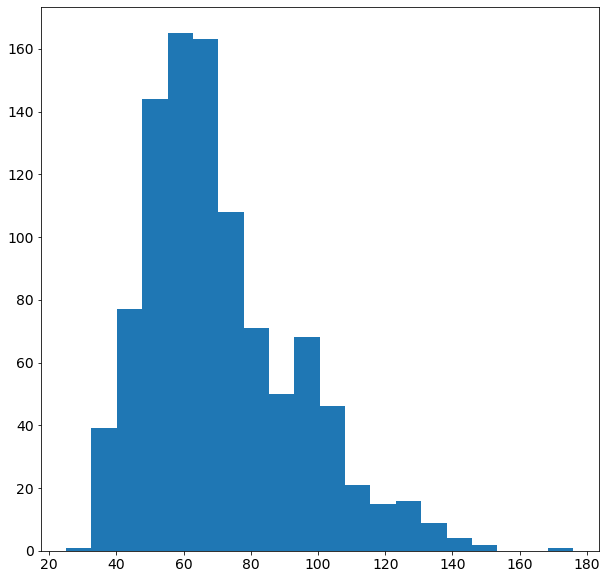

In [60]:
plt.figure(figsize=(10,10))
plt.hist(iterations, bins=20);

In [139]:
%timeit func(initial_a)

318 µs ± 2.95 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [172]:
success_threshold = 0.02
failures = 0
n_runs = 200
maxiter = 200
dts = np.ndarray(n_runs)
attempts = np.ndarray(n_runs)
for i in range(n_runs):
    t0 = time()
    attempt = 0
    while True:
        initial_a = np.random.randn(3)
        initial_R_k = Rk(initial_a)
        initial_transformed_data = data_at_threshold @ initial_R_k
        initial_correspondance_guess = nn_correspondences(initial_transformed_data, sdf_points_at_threshold)
        sol = root(func, initial_a, jac=None, method='lm')
        mean_error = np.mean(sol.fun)
        attempt += 1
        if mean_error < success_threshold:
            break
        if attempt > maxiter:
            failures += 1
            break
    dt = time() - t0
    dts[i] = dt
    attempts[i] = attempt
    
print("# Failures:", failures)
print("median dt: {:5.3f} seconds".format(np.median(dts)))
print("median attempts: {}".format(np.median(attempts)))

# Failures: 0
median dt: 0.093 seconds


In [173]:
attempts

array([ 4.,  1.,  4.,  2.,  2.,  5., 13.,  8.,  7., 23.,  6.,  2.,  2.,  3.,  9.,  1.,  6.,  1.,  1.,  4., 14.,  3., 13.,  4.,  5.,  1.,  6.,  1.,  9.,  9., 13.,  1.,  3., 26.,  7., 12., 15.,  7.,
        3., 10.,  2.,  2., 12., 16.,  2., 16.,  3.,  1.,  6., 18.,  5., 24.,  8., 26., 23.,  7.,  2.,  2.,  7.,  2., 18., 34.,  2.,  8.,  2.,  1., 18., 30., 13.,  7.,  1.,  4.,  6.,  1.,  4.,  5.,
        1.,  6.,  4.,  1.,  4.,  5.,  4.,  3.,  4.,  4., 28.,  4., 20.,  6.,  1.,  5.,  1.,  1., 10.,  3., 17.,  4.,  8.,  3.,  1., 17.,  3., 10.,  4.,  8., 10.,  3.,  1.,  5.,  2.,  5., 11.,  4.,
       10., 13.,  1.,  1.,  3.,  6.,  1.,  4.,  1.,  2., 11., 22., 12.,  2.,  4., 21.,  5.,  6.,  9.,  6.,  8.,  5.,  6.,  4.,  1.,  9.,  3.,  8., 11.,  8., 13.,  3., 11.,  8., 16.,  2.,  8.,  3.,
        1.,  6., 10.,  6.,  2.,  2.,  2.,  1., 18.,  1.,  2., 29.,  1., 11., 12.,  4.,  5.,  3.,  3.,  4., 13.,  2.,  3.,  5.,  8., 17., 25.,  1., 27., 12., 23., 24., 16.,  4.,  4.,  2., 11.,  6.,
        2., 26.

In [174]:
print("median attempts: {}".format(np.median(attempts)))

median attempts: 5.0
